# Project and Presentation - Text Analytics
## Aaron Bromeland

### Purpose:
- To obtain data from the SEC edgar search and stock market to see the impact of reportings to the SEC on stock valutaion of Deere & Co. Will look to develop a model with Deere and then try to apply it to other companies within the industry and then potentially other companies outside of the Agricultural/Construction and Forestry Industry. 

- Background:
     - Deere & Company is an Agriculture and Construction and Forestry manufacturer that is headquartered in Moline, Illinois. Deere & Company started in 1837 after John Deere invented the self scouring plow in 1836 that allowed Midwest farmers to plow the thick black dirt of the Midwest without clogging. The company started in the town of Grad Detour, Illinois, and was moved in 1848 to Moline, Illinois. The company started with the technological advancement of the plow that was made from steel instead of cast iron and has since led the industry in technological advances in agriculture all the way to today with the introduction of the first commercially available fully autonomous tractor.  The company was formally incorporated as Deere & Company in 1868. John Deere served as the Founder and president of the company from 1837-1886. Then decedents of Deere served as President and Chairman from 1886-1982 (Charles Deere, William Butterworth, Charles Deere Wiman, William Hewitt). Then from 1982-today, John Deere has been run by members outside of the Deere family (Robert Hanson, Hans Becherer, Robert Lane, Samuel Allen, and John May)

- Project Goals
    - The project is hoping to identify trends in SEC filings that correlate to positive or negative stock returns. Specifically, we are looking to identify long term trends in the data to determine if SEC filings can help point to long-term growth opportunities in the stock of Deere. Additionally, we would like to extend this analysis beyond Deere to other companies first in the Agricultural and Construction and Forestry industries, and if we get successful results, then extend this to other company filings, as well. 


- Research Questions
    1.	Which standard forms filed with the SEC have the highest sentiment scores?
    2.	Which standard forms filed with the SEC have the lowest sentiment scores? 
    3.	Which standard forms filed with the SEC have the highest variance in sentiment scores?
    4.	Which filings coincide with the greatest change in stock price for the company? 
    5.	Do SEC filings have a material impact on the stock price of Deere & Co?
    6.	Can the sentiment analysis developed for Deere & Co be applied to other companies within the agricultural and construction industry?
    7.	Can the sentiment analysis developed for Deere & Co be applied to other companies outside of Deere’s industry? 


- Data Source
    - The dataset is comprised of 1000 filings of Deere with the SEC from October 3rd, 2011 to May, 31st, 2022. Initially, the shortest document in the dataset was 37 characters long with average character lengths of 24,110. However, 38 documents had under 500 characters in them. These were removed because after review of these documents, they were for PDF files that had been loaded or were references to other paper submissions that had been done.  After removing these documents, the average character lengths of the documents were 25,054 with a maximum character length of 564,539 and minimum character length of 539.


### Required Imports

In [2]:
# imports required
import requests
import pandas as pd
import numpy as np
import json
import re
from lxml import html
#!pip3 install yfinance
import yfinance as yf
import time

#!pip3 install afinn
from afinn import Afinn
#!pip3 install textblob
from textblob import TextBlob
#!pip3 install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
#!pip3 install pysentiment2
import pysentiment2 as ps

from sklearn.preprocessing import MinMaxScaler
import numpy as np

import matplotlib.pyplot as plt                      # a library for visualization

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LassoCV
from sklearn.svm import l1_min_c
from sklearn.linear_model import LogisticRegressionCV

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation  #LDA module from sklearn. 
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression

#!pip3 install PyPDF2
import PyPDF2

#!pip install scipy --upgrade

### Pull SEC Data
- Pull data via the SEC API's that are made available. This pulls by company CIK number. Using the CIK number we can get all the recent filings for a company. Then we used the information from the first data pull to pull all of the text content for the items that have been previously submitted. 

In [2]:
# Request Data from Edgar Search. Pulled by Company CIK number
data = requests.get('https://data.sec.gov/submissions/CIK0000315189.json',headers={'User-Agent':'University of Iowa abromeland@uiowa.edu'})
data = json.loads(data.content)['filings']['recent']
df = pd.DataFrame.from_dict(data)
df.sort_values(by='filingDate',ascending=False,inplace=True)
df.reset_index(inplace=True,drop=True)
df.head()

,accessionNumber,filingDate,reportDate,acceptanceDateTime,act,form,fileNumber,filmNumber,items,size,isXBRL,isInlineXBRL,primaryDocument,primaryDocDescription
0,0001104659-22-082021,2022-07-22,,2022-07-22T16:31:46.000Z,34,SC 13D/A,005-31096,221100263,,72665,0,0,tm2221643d1_sc13da.htm,SC 13D/A
1,0000315189-22-000014,2022-05-31,2022-05-26,2022-05-31T14:43:18.000Z,,4,,,,59067,0,0,xslF345X03/primary_doc.xml,PRIMARY DOCUMENT
2,0001558370-22-009519,2022-05-31,2022-05-31,2022-05-31T08:35:14.000Z,34,8-K,001-04121,22980681,"5.02,7.01,9.01",225690,1,1,de-20220531x8k.htm,8-K
3,0000315189-22-000016,2022-05-31,2022-05-26,2022-05-31T17:23:01.000Z,,4/A,,,,5012,0,0,xslF345X03/primary_doc.xml,PRIMARY DOCUMENT
4,0000315189-22-000015,2022-05-31,2022-05-26,2022-05-31T16:59:24.000Z,,4,,,,33968,0,0,xslF345X03/primary_doc.xml,PRIMARY DOCUMENT


In [3]:
# Pull data by accessionNumber and FileName to be added to the dataframe
for i in range(len(df)):
    accessionNumber = df.loc[i,"accessionNumber"]
    filename = df.loc[i,'primaryDocument']
    URL = f'https://www.sec.gov/Archives/edgar/data/315189/{re.sub("-","",accessionNumber)}/{filename}'
    page = requests.get(URL,headers={'User-Agent':'University of Iowa abromeland@uiowa.edu'})
    if df.loc[i,'form'] == 'UPLOAD':
        with open('/tmp/metadata.pdf','wb') as fd:
            fd.write(page.content)
        fd.close()

        pdfFileObj = open('/tmp/metadata.pdf', 'rb') 
        pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
        text = [pdfReader.getPage(i).extractText() for i in range(pdfReader.numPages)]
        df.loc[i,'text'] = ' '.join(text)
        pdfFileObj.close()
    else:
        root = html.fromstring(page.content)
        text = [s.text_content() for s in root.xpath('/html/body')]
        df.loc[i,'text'] = ' '.join(text)
        
    time.sleep(.25)
df

,accessionNumber,filingDate,reportDate,acceptanceDateTime,act,form,fileNumber,filmNumber,items,size,isXBRL,isInlineXBRL,primaryDocument,primaryDocDescription,text
0,0001104659-22-082021,2022-07-22,,2022-07-22T16:31:46.000Z,34,SC 13D/A,005-31096,221100263,,72665,0,0,tm2221643d1_sc13da.htm,SC 13D/A,\nSC 13D/A\n1\ntm2221643d1_sc13da.htm\nSC 13D/...
1,0000315189-22-000014,2022-05-31,2022-05-26,2022-05-31T14:43:18.000Z,,4,,,,59067,0,0,xslF345X03/primary_doc.xml,PRIMARY DOCUMENT,SEC Form 4 \n \n\nFORM 4\n\nUNITED STATES SE...
2,0001558370-22-009519,2022-05-31,2022-05-31,2022-05-31T08:35:14.000Z,34,8-K,001-04121,22980681,"5.02,7.01,9.01",225690,1,1,de-20220531x8k.htm,8-K,0000315189falseDEERE & CO0000315189us-gaap:Com...
3,0000315189-22-000016,2022-05-31,2022-05-26,2022-05-31T17:23:01.000Z,,4/A,,,,5012,0,0,xslF345X03/primary_doc.xml,PRIMARY DOCUMENT,SEC Form 4 \n \n\nFORM 4\n\nUNITED STATES SE...
4,0000315189-22-000015,2022-05-31,2022-05-26,2022-05-31T16:59:24.000Z,,4,,,,33968,0,0,xslF345X03/primary_doc.xml,PRIMARY DOCUMENT,SEC Form 4 \n \n\nFORM 4\n\nUNITED STATES SE...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,0000315189-11-000041,2011-11-07,2011-09-30,2011-11-07T17:20:44.000Z,34,13F-HR,028-00850,111185525,,112305,0,0,sep1113f.txt,DEERE & COMPANY 13F-HR,\n13F-HR\n1\nsep1113f.txt\nDEERE & COMPANY 13F...
997,0000315189-11-000039,2011-10-03,2011-09-30,2011-10-03T11:12:38.000Z,,4,,,,5674,0,0,xslF345X03/primary_doc.xml,PRIMARY DOCUMENT,SEC Form 4 \n \n\nFORM 4\n\nUNITED STATES SE...
998,0000315189-11-000038,2011-10-03,2011-09-30,2011-10-03T10:54:30.000Z,,4,,,,5874,0,0,xslF345X03/primary_doc.xml,PRIMARY DOCUMENT,SEC Form 4 \n \n\nFORM 4\n\nUNITED STATES SE...
999,0000315189-11-000037,2011-10-03,2011-09-30,2011-10-03T10:19:03.000Z,,4,,,,5885,0,0,xslF345X03/primary_doc.xml,PRIMARY DOCUMENT,SEC Form 4 \n \n\nFORM 4\n\nUNITED STATES SE...


In [5]:
# Clean Data and print out example data
df['text'] = df['text'].str.replace("[\\u200b||\\n||\\xa0]",' ',regex=True)
df['text'] = df['text'].str.replace("\$\d+[\d,\.]*",' moneyToken ',regex=True)
df['text'] = df['text'].str.lower()
print(df.text[0])
print(df.text[1])
print(df.text[2])

/home/abromeland/.local/lib/python3.9/site-packages/pandas/core/strings/object_array.py:158: FutureWarning: Possible set union at position 7
  pat = re.compile(pat, flags=flags)
/home/abromeland/.local/lib/python3.9/site-packages/pandas/core/strings/object_array.py:158: FutureWarning: Possible set union at position 11
  pat = re.compile(pat, flags=flags)


 sc 13d/a 1 tm2221643d1_sc13da.htm sc 13d/a                       united states  securities and exchange commission  washington, d.c. 20549     schedule 13d     under the securities exchange act of 1934  (amendment no. 6)*     deere & company  (name of issuer)     common stock, par value  moneytoken   (title of class of securities)     244199105  (cusip number)                  jacki badal, esq.     2365 carillon point     kirkland, wa 98033     (425) 889-7900      (name, address and telephone number of persons authorized to receive notices and communications)     july 21, 2022    (date of event which requires filing of this statement)     if the filing person has previously filed a statement on schedule 13g to report the acquisition that is the subject of this schedule 13d, and is filing this schedule because of §§240.13d-1(e), 240.13d-1(f) or 240.13d-1(g), check the following box.¨     note: schedules filed in paper format shall include a signed original and five copies of the schedu

In [6]:
# Check for Filing Date nulls, and save filing date so it can be used later in graphing and to merge datasets.
print(df.filingDate.isnull().sum())
print(df.filingDate.dtype)
df["filingDate"] = pd.to_datetime(df["filingDate"],format="%Y-%m-%d %H:%M:%S")
print(df.filingDate.dtype)
df.head()

0
object
datetime64[ns]


,accessionNumber,filingDate,reportDate,acceptanceDateTime,act,form,fileNumber,filmNumber,items,size,isXBRL,isInlineXBRL,primaryDocument,primaryDocDescription,text
0,0001104659-22-082021,2022-07-22,,2022-07-22T16:31:46.000Z,34,SC 13D/A,005-31096,221100263,,72665,0,0,tm2221643d1_sc13da.htm,SC 13D/A,sc 13d/a 1 tm2221643d1_sc13da.htm sc 13d/a ...
1,0000315189-22-000014,2022-05-31,2022-05-26,2022-05-31T14:43:18.000Z,,4,,,,59067,0,0,xslF345X03/primary_doc.xml,PRIMARY DOCUMENT,sec form 4 form 4 united states securit...
2,0001558370-22-009519,2022-05-31,2022-05-31,2022-05-31T08:35:14.000Z,34,8-K,001-04121,22980681,"5.02,7.01,9.01",225690,1,1,de-20220531x8k.htm,8-K,0000315189falsedeere & co0000315189us-gaap:com...
3,0000315189-22-000016,2022-05-31,2022-05-26,2022-05-31T17:23:01.000Z,,4/A,,,,5012,0,0,xslF345X03/primary_doc.xml,PRIMARY DOCUMENT,sec form 4 form 4 united states securit...
4,0000315189-22-000015,2022-05-31,2022-05-26,2022-05-31T16:59:24.000Z,,4,,,,33968,0,0,xslF345X03/primary_doc.xml,PRIMARY DOCUMENT,sec form 4 form 4 united states securit...


In [7]:
# Print the shape and save the data for later use
print(df.shape)
df.to_csv("Deere_SEC.csv",index=False)

(1001, 15)


### Obtain Stock Market Data
- Obtained from the yfinance API. 
- Will be used to generate if the stock is decreasing or increasing in a given time period.
- Added the columns 
    1. dayDiff - Holds the differences that are recorded daily
    2. weekDiff - Holds the differences that are recorded for 5 business days (week)
    3. monthDiff - Holds the differences that are recorded monthly. 5x4 + 2 - Five Days over four weeks, and add two days for the quarters. 

In [4]:
df_price = yf.download("DE",start='2011-08-01',end='2022-07-20',progress=False)
df_price.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-08-01,81.110001,81.139999,77.550003,78.720001,62.467770,5108300
2011-08-02,78.360001,79.900002,76.820000,76.820000,60.960014,6441600
2011-08-03,77.339996,77.690002,74.540001,77.070000,61.158394,6289100
2011-08-04,75.910004,75.910004,72.370003,72.410004,57.460484,8001800
2011-08-05,73.489998,74.300003,70.500000,72.660004,57.658886,9047300


In [5]:
print(type(df_price.index))
df_price.sort_index(ascending=False,inplace=True)
df_price.head()

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-07-19,301.559998,312.200012,300.820007,311.589996,311.589996,1282200
2022-07-18,301.140015,306.480011,296.950012,297.950012,297.950012,1056200
2022-07-15,298.070007,299.649994,293.190002,297.700012,297.700012,1184200
2022-07-14,290.049988,294.859985,288.339996,294.329987,294.329987,1366800
2022-07-13,292.029999,299.170013,291.290009,296.779999,296.779999,1199900


In [6]:
df_price['dayDiff'] = -1*df_price['Adj Close'].diff()
df_price['dayDiffCL'] = -1*df_price['Close'].diff()
df_price['dayPCT'] = -1*df_price['Adj Close'].pct_change()
df_price['dayPCTCL'] = -1*df_price['Close'].pct_change()
df_price['weekDiff'] = -1*df_price['Adj Close'].diff(periods=5)
df_price['weekDiffCL'] = -1*df_price['Close'].diff(periods=5)
df_price['weekPCT'] = -1*df_price['Adj Close'].pct_change(periods=5)
df_price['weekPCTCL'] = -1*df_price['Close'].pct_change(periods=5)
df_price['monthDiff'] = -1*df_price['Adj Close'].diff(periods=22)
df_price['monthDiffCL'] = -1*df_price['Close'].diff(periods=22)
df_price['monthPCT'] = -1*df_price['Adj Close'].pct_change(periods=22)
df_price['monthPCTCL'] = -1*df_price['Close'].pct_change(periods=22)
df_price.head(40)

,Open,High,Low,Close,Adj Close,Volume,dayDiff,dayDiffCL,dayPCT,dayPCTCL,weekDiff,weekDiffCL,weekPCT,weekPCTCL,monthDiff,monthDiffCL,monthPCT,monthPCTCL
Date,,,,,,,,,,,,,,,,,,
2022-07-19,301.559998,312.200012,300.820007,311.589996,311.589996,1282200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-18,301.140015,306.480011,296.950012,297.950012,297.950012,1056200,13.639984,13.639984,0.043775,0.043775,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-15,298.070007,299.649994,293.190002,297.700012,297.700012,1184200,0.250000,0.250000,0.000839,0.000839,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-14,290.049988,294.859985,288.339996,294.329987,294.329987,1366800,3.370026,3.370026,0.011320,0.011320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-13,292.029999,299.170013,291.290009,296.779999,296.779999,1199900,-2.450012,-2.450012,-0.008324,-0.008324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-12,294.000000,301.269989,293.140015,295.959991,295.959991,1210200,0.820007,0.820007,0.002763,0.002763,15.630005,15.630005,0.050162,0.050162,NaN,NaN,NaN,NaN
2022-07-11,300.559998,303.980011,297.859985,298.410004,298.410004,993900,-2.450012,-2.450012,-0.008278,-0.008278,-0.459991,-0.459991,-0.001544,-0.001544,NaN,NaN,NaN,NaN
2022-07-08,304.700012,308.019989,301.260010,304.640015,304.640015,1516100,-6.230011,-6.230011,-0.020877,-0.020877,-6.940002,-6.940002,-0.023312,-0.023312,NaN,NaN,NaN,NaN
2022-07-07,297.820007,304.589996,295.540009,303.970001,303.970001,2051800,0.670013,0.670013,0.002199,0.002199,-9.640015,-9.640015,-0.032752,-0.032752,NaN,NaN,NaN,NaN


### Sentiment Analysis 

- Running the sentiment Analysis of all documents, and will plot this against the changes in stock price that are obtained for the same time period. 
- The sentiment analizers that were used are below:
    1. AFINN
    2. TextBlob
    3. VADER
    4. LM - Loughran and McDonald Financial Sentiment Dictionaries

In [12]:
# WARNING - THIS CELL WILL TAKE A LONG TIME TO RUN
print(type(df.text[0]))
# AFINN Sentiment Analysis Scores
afinn = Afinn(emoticons=True)
df["AFINN"]=[afinn.score(s) for s in df.text]

# TextBlob Sentiment Analysis Scores
df["TextBlob"]=[TextBlob(s).sentiment.polarity for s in df.text]

# VADER Sentiment Analysis Scores
analyzer=SentimentIntensityAnalyzer()
df["VADER"]=[analyzer.polarity_scores(s)['compound'] for s in df.text]

# Loughran and McDonald Sentiment Scores
lm = ps.LM()
df['LMTitle'] = 0
for i in range(len(df['text'])):
    tokens = lm.tokenize(df['text'][i])
    score = lm.get_score(tokens)
    df.loc[i,"LMTitle"]=score["Polarity"]

df

<class 'str'>


,accessionNumber,filingDate,reportDate,acceptanceDateTime,act,form,fileNumber,filmNumber,items,size,isXBRL,isInlineXBRL,primaryDocument,primaryDocDescription,text,Type,AFINN,TextBlob,VADER,LMTitle
0,0001104659-22-082021,2022-07-22,,2022-07-22T16:31:46.000Z,34,SC 13D/A,005-31096,221100263,,72665,0,0,tm2221643d1_sc13da.htm,SC 13D/A,sc 13d/a 1 tm2221643d1_sc13da.htm sc 13d/a ...,<class 'str'>,97.0,0.027128,0.9999,0.428571
1,0000315189-22-000014,2022-05-31,2022-05-26,2022-05-31T14:43:18.000Z,,4,,,,59067,0,0,xslF345X03/primary_doc.xml,PRIMARY DOCUMENT,sec form 4 form 4 united states securit...,<class 'str'>,31.0,-0.097595,0.9990,0.083333
2,0001558370-22-009519,2022-05-31,2022-05-31,2022-05-31T08:35:14.000Z,34,8-K,001-04121,22980681,"5.02,7.01,9.01",225690,1,1,de-20220531x8k.htm,8-K,0000315189falsedeere & co0000315189us-gaap:com...,<class 'str'>,31.0,0.016007,0.9970,0.714286
3,0000315189-22-000016,2022-05-31,2022-05-26,2022-05-31T17:23:01.000Z,,4/A,,,,5012,0,0,xslF345X03/primary_doc.xml,PRIMARY DOCUMENT,sec form 4 form 4 united states securit...,<class 'str'>,1.0,0.054667,0.9966,-0.142857
4,0000315189-22-000015,2022-05-31,2022-05-26,2022-05-31T16:59:24.000Z,,4,,,,33968,0,0,xslF345X03/primary_doc.xml,PRIMARY DOCUMENT,sec form 4 form 4 united states securit...,<class 'str'>,19.0,-0.061198,0.9986,0.043478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,0000315189-11-000041,2011-11-07,2011-09-30,2011-11-07T17:20:44.000Z,34,13F-HR,028-00850,111185525,,112305,0,0,sep1113f.txt,DEERE & COMPANY 13F-HR,13f-hr 1 sep1113f.txt deere & company 13f-hr ...,<class 'str'>,57.0,0.116311,0.9993,0.300000
997,0000315189-11-000039,2011-10-03,2011-09-30,2011-10-03T11:12:38.000Z,,4,,,,5674,0,0,xslF345X03/primary_doc.xml,PRIMARY DOCUMENT,sec form 4 form 4 united states securit...,<class 'str'>,-5.0,0.047333,0.9961,-0.090909
998,0000315189-11-000038,2011-10-03,2011-09-30,2011-10-03T10:54:30.000Z,,4,,,,5874,0,0,xslF345X03/primary_doc.xml,PRIMARY DOCUMENT,sec form 4 form 4 united states securit...,<class 'str'>,-6.0,0.047333,0.9961,-0.090909
999,0000315189-11-000037,2011-10-03,2011-09-30,2011-10-03T10:19:03.000Z,,4,,,,5885,0,0,xslF345X03/primary_doc.xml,PRIMARY DOCUMENT,sec form 4 form 4 united states securit...,<class 'str'>,-4.0,0.047333,0.9965,-0.090909


In [13]:
# Write Out Results
df.to_csv("Deere_Sentiment_Scores.csv",index=False)

### Visualize Sentiment Analysis 
    1. Graph All Sentiment Scores together
    2. Graph Daily, Weekly, and Monthly Changes
    3. Merge Sentiment Scores with Stock Data 
    4. Graph Stock data with Sentiment Scores

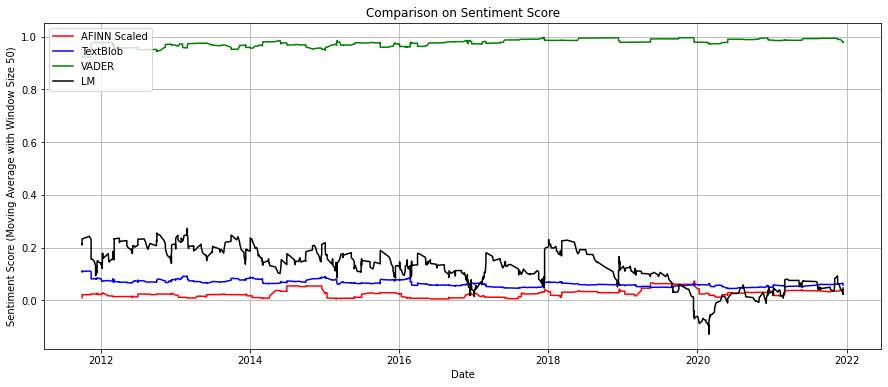

In [14]:
# Scale AFINN score to compare it with other sentiment analyzers
df['AFINN_SCALE'] = MinMaxScaler().fit_transform(np.array(df['AFINN']).reshape(-1,1))


# inline display of plots
%matplotlib inline
plt.figure(figsize=(15, 6))

plt.plot(df.filingDate, df.AFINN_SCALE.rolling(window=50).mean(), "-r", label="AFINN Scaled")
plt.plot(df.filingDate, df.TextBlob.rolling(window=50).mean(), "-b", label="TextBlob")
plt.plot(df.filingDate, df.VADER.rolling(window=50).mean(), "-g", label="VADER")
plt.plot(df.filingDate, df.LMTitle.rolling(window=50).mean(), "-k", label="LM")


plt.legend(loc="upper left")
plt.title("Comparison on Sentiment Score")
plt.xlabel("Date")
plt.ylabel("Sentiment Score (Moving Average with Window Size 50)")
plt.grid(axis='both')
plt.show()

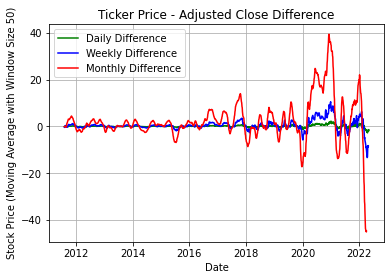

In [17]:
# Plot daily, weekly, and monthly difference

plt.plot(df_price.index, df_price['dayDiff'].rolling(window=50).mean(), "-g", label="Daily Difference")
plt.plot(df_price.index, df_price['weekDiff'].rolling(window=50).mean(), "-b", label="Weekly Difference")
plt.plot(df_price.index, df_price['monthDiff'].rolling(window=50).mean(), "-r", label="Monthly Difference")


plt.legend(loc="upper left")
plt.title("Ticker Price - Adjusted Close Difference")
plt.xlabel("Date")
plt.ylabel("Stock Price (Moving Average with Window Size 50)")
plt.grid(axis='both')
plt.show()

#### Re-load Location - Allows for csv to be reloaded and merged with original data.

In [7]:

# Re-load data set location - uncomment to re-laod 
#df = pd.read_csv("Deere_Sentiment_Scores.csv")
#print(df.filingDate.isnull().sum())
#print(df.filingDate.dtype)
#df["filingDate"] = pd.to_datetime(df["filingDate"],format="%Y-%m-%d %H:%M:%S")
#print(df.filingDate.dtype)
#df['AFINN_SCALE'] = MinMaxScaler().fit_transform(np.array(df['AFINN']).reshape(-1,1))

# Merge Stock and Sentiment Data
df_all = pd.merge(df,df_price,how='left',left_on = 'filingDate',right_index = True, copy=True)
df_all = df_all[df_all['dayPCT'].isna() == False]
df_all

0
object
datetime64[ns]


,accessionNumber,filingDate,reportDate,acceptanceDateTime,act,form,fileNumber,filmNumber,items,size,...,dayPCT,dayPCTCL,weekDiff,weekDiffCL,weekPCT,weekPCTCL,monthDiff,monthDiffCL,monthPCT,monthPCTCL
1,0000315189-22-000014,2022-05-31,2022-05-26,2022-05-31T14:43:18.000Z,NaN,4,NaN,NaN,NaN,59067,...,-0.015988,-0.015988,10.023224,10.059998,0.027349,0.027349,-54.842285,-56.149994,-0.181820,-0.186155
2,0001558370-22-009519,2022-05-31,2022-05-31,2022-05-31T08:35:14.000Z,34.0,8-K,001-04121,22980681.0,"5.02,7.01,9.01",225690,...,-0.015988,-0.015988,10.023224,10.059998,0.027349,0.027349,-54.842285,-56.149994,-0.181820,-0.186155
3,0000315189-22-000016,2022-05-31,2022-05-26,2022-05-31T17:23:01.000Z,NaN,4/A,NaN,NaN,NaN,5012,...,-0.015988,-0.015988,10.023224,10.059998,0.027349,0.027349,-54.842285,-56.149994,-0.181820,-0.186155
4,0000315189-22-000015,2022-05-31,2022-05-26,2022-05-31T16:59:24.000Z,NaN,4,NaN,NaN,NaN,33968,...,-0.015988,-0.015988,10.023224,10.059998,0.027349,0.027349,-54.842285,-56.149994,-0.181820,-0.186155
5,0001104659-22-065984,2022-05-27,NaN,2022-05-27T16:48:50.000Z,34.0,IRANNOTICE,001-04121,22978525.0,NaN,11971,...,-0.008245,-0.008245,2.171997,2.179993,0.006007,0.006007,-59.941528,-61.260010,-0.200159,-0.204561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,0000315189-11-000041,2011-11-07,2011-09-30,2011-11-07T17:20:44.000Z,34.0,13F-HR,028-00850,111185525.0,NaN,112305,...,0.006347,0.006347,-0.359200,-0.450005,-0.006024,-0.006024,1.380959,1.729996,0.022502,0.022503
997,0000315189-11-000039,2011-10-03,2011-09-30,2011-10-03T11:12:38.000Z,NaN,4,NaN,NaN,NaN,5674,...,0.027725,0.027725,6.114616,7.659996,0.110406,0.110406,9.858440,12.349998,0.166734,0.166734
998,0000315189-11-000038,2011-10-03,2011-09-30,2011-10-03T10:54:30.000Z,NaN,4,NaN,NaN,NaN,5874,...,0.027725,0.027725,6.114616,7.659996,0.110406,0.110406,9.858440,12.349998,0.166734,0.166734
999,0000315189-11-000037,2011-10-03,2011-09-30,2011-10-03T10:19:03.000Z,NaN,4,NaN,NaN,NaN,5885,...,0.027725,0.027725,6.114616,7.659996,0.110406,0.110406,9.858440,12.349998,0.166734,0.166734


In [8]:
#check for NA columns
print(df_all['dayDiff'].isna().sum())
print(df_all['dayDiffCL'].isna().sum())
print(df_all['dayPCT'].isna().sum())
print(df_all['dayPCTCL'].isna().sum())
print(df_all['weekDiff'].isna().sum())
print(df_all['weekDiffCL'].isna().sum())
print(df_all['weekPCT'].isna().sum())
print(df_all['weekPCTCL'].isna().sum())
print(df_all['monthDiff'].isna().sum())
print(df_all['monthDiffCL'].isna().sum())
print(df_all['monthPCT'].isna().sum())
print(df_all['monthPCTCL'].isna().sum())


0
0
0
0
0
0
0
0
0
0
0
0


In [9]:
# Write out Data set so it can be used and re-loaded at a later date.
df_all.to_csv("Deere_All.csv",index=False)
df_all

,accessionNumber,filingDate,reportDate,acceptanceDateTime,act,form,fileNumber,filmNumber,items,size,...,dayPCT,dayPCTCL,weekDiff,weekDiffCL,weekPCT,weekPCTCL,monthDiff,monthDiffCL,monthPCT,monthPCTCL
1,0000315189-22-000014,2022-05-31,2022-05-26,2022-05-31T14:43:18.000Z,NaN,4,NaN,NaN,NaN,59067,...,-0.015988,-0.015988,10.023224,10.059998,0.027349,0.027349,-54.842285,-56.149994,-0.181820,-0.186155
2,0001558370-22-009519,2022-05-31,2022-05-31,2022-05-31T08:35:14.000Z,34.0,8-K,001-04121,22980681.0,"5.02,7.01,9.01",225690,...,-0.015988,-0.015988,10.023224,10.059998,0.027349,0.027349,-54.842285,-56.149994,-0.181820,-0.186155
3,0000315189-22-000016,2022-05-31,2022-05-26,2022-05-31T17:23:01.000Z,NaN,4/A,NaN,NaN,NaN,5012,...,-0.015988,-0.015988,10.023224,10.059998,0.027349,0.027349,-54.842285,-56.149994,-0.181820,-0.186155
4,0000315189-22-000015,2022-05-31,2022-05-26,2022-05-31T16:59:24.000Z,NaN,4,NaN,NaN,NaN,33968,...,-0.015988,-0.015988,10.023224,10.059998,0.027349,0.027349,-54.842285,-56.149994,-0.181820,-0.186155
5,0001104659-22-065984,2022-05-27,NaN,2022-05-27T16:48:50.000Z,34.0,IRANNOTICE,001-04121,22978525.0,NaN,11971,...,-0.008245,-0.008245,2.171997,2.179993,0.006007,0.006007,-59.941528,-61.260010,-0.200159,-0.204561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,0000315189-11-000041,2011-11-07,2011-09-30,2011-11-07T17:20:44.000Z,34.0,13F-HR,028-00850,111185525.0,NaN,112305,...,0.006347,0.006347,-0.359200,-0.450005,-0.006024,-0.006024,1.380959,1.729996,0.022502,0.022503
997,0000315189-11-000039,2011-10-03,2011-09-30,2011-10-03T11:12:38.000Z,NaN,4,NaN,NaN,NaN,5674,...,0.027725,0.027725,6.114616,7.659996,0.110406,0.110406,9.858440,12.349998,0.166734,0.166734
998,0000315189-11-000038,2011-10-03,2011-09-30,2011-10-03T10:54:30.000Z,NaN,4,NaN,NaN,NaN,5874,...,0.027725,0.027725,6.114616,7.659996,0.110406,0.110406,9.858440,12.349998,0.166734,0.166734
999,0000315189-11-000037,2011-10-03,2011-09-30,2011-10-03T10:19:03.000Z,NaN,4,NaN,NaN,NaN,5885,...,0.027725,0.027725,6.114616,7.659996,0.110406,0.110406,9.858440,12.349998,0.166734,0.166734


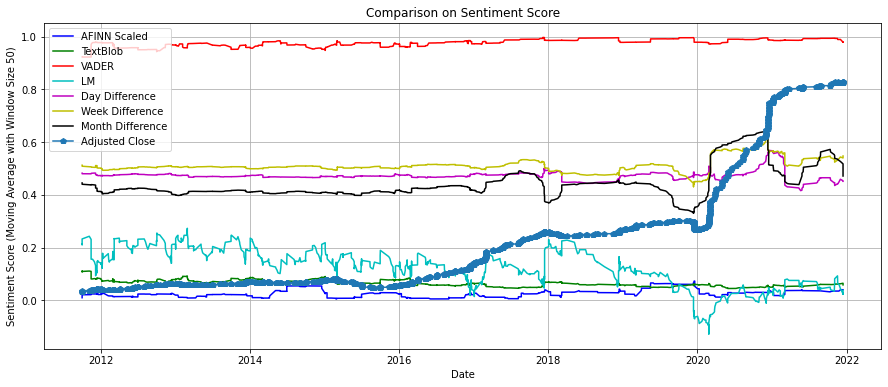

In [10]:
# Graph all stock data with Sentiment Data - First Scale difference data to be graphed and compared with sentiment data.
df_all['dayDiff_SCALE'] = MinMaxScaler().fit_transform(np.array(df_all['dayDiff']).reshape(-1,1))
df_all['weekDiff_SCALE'] = MinMaxScaler().fit_transform(np.array(df_all['weekDiff']).reshape(-1,1))
df_all['monthDiff_SCALE'] = MinMaxScaler().fit_transform(np.array(df_all['monthDiff']).reshape(-1,1))
df_all['Adj_Close_SCALE'] = MinMaxScaler().fit_transform(np.array(df_all['Adj Close']).reshape(-1,1))


# inline display of plots
%matplotlib inline
plt.figure(figsize=(15, 6))

plt.plot(df_all.filingDate, df_all.AFINN_SCALE.rolling(window=50).mean(), "-b", label="AFINN Scaled")
plt.plot(df_all.filingDate, df_all.TextBlob.rolling(window=50).mean(), "-g", label="TextBlob")
plt.plot(df_all.filingDate, df_all.VADER.rolling(window=50).mean(), "-r", label="VADER")
plt.plot(df_all.filingDate, df_all.LMTitle.rolling(window=50).mean(), "-c", label="LM")
plt.plot(df_all.filingDate, df_all.dayDiff_SCALE.rolling(window=50).mean(), "-m", label="Day Difference")
plt.plot(df_all.filingDate, df_all.weekDiff_SCALE.rolling(window=50).mean(), "-y", label="Week Difference")
plt.plot(df_all.filingDate, df_all.monthDiff_SCALE.rolling(window=50).mean(), "-k", label="Month Difference")
plt.plot(df_all.filingDate, df_all.Adj_Close_SCALE.rolling(window=50).mean(), "-p", label="Adjusted Close")


plt.legend(loc="upper left")
plt.title("Comparison on Sentiment Score")
plt.xlabel("Date")
plt.ylabel("Sentiment Score (Moving Average with Window Size 50)")
plt.grid(axis='both')
plt.show()

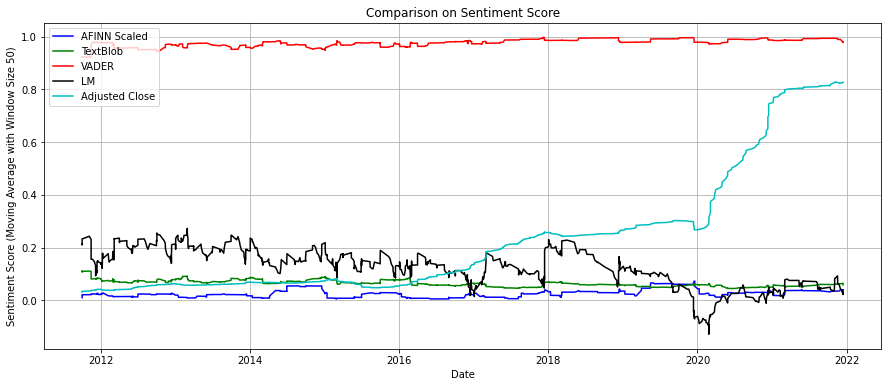

In [11]:
# Graph Sentiment scores with Adjusted Closing Values
plt.figure(figsize=(15, 6))

plt.plot(df_all.filingDate, df_all.AFINN_SCALE.rolling(window=50).mean(), "-b", label="AFINN Scaled")
plt.plot(df_all.filingDate, df_all.TextBlob.rolling(window=50).mean(), "-g", label="TextBlob")
plt.plot(df_all.filingDate, df_all.VADER.rolling(window=50).mean(), "-r", label="VADER")
plt.plot(df_all.filingDate, df_all.LMTitle.rolling(window=50).mean(), "-k", label="LM")
plt.plot(df_all.filingDate, df_all.Adj_Close_SCALE.rolling(window=50).mean(), "-c", label="Adjusted Close")


plt.legend(loc="upper left")
plt.title("Comparison on Sentiment Score")
plt.xlabel("Date")
plt.ylabel("Sentiment Score (Moving Average with Window Size 50)")
plt.grid(axis='both')
plt.show()

### Summary Statistics on Data Set

1. Obtain the character counts and throw out data that is too small.
2. Create DTM's
    1. Unigrams
    2. Bigrams
    3. Trigrams
    
    
#### Remove and Review of Small Character Count Documents

In [12]:
df_all['characters'] = [len(s) for s in df_all['text']]
print(f"Average character length: {df_all['characters'].mean()}")
print(f"Minimum character length: {df_all['characters'].min()}")
print(f"Maximum character length: {df_all['characters'].max()}")

Average character length: 28137.885
Minimum character length: 217
Maximum character length: 570774


In [13]:
df_small = df_all[df_all['characters']<500].copy()
print(df_small.shape)
df_small

(26, 44)


,accessionNumber,filingDate,reportDate,acceptanceDateTime,act,form,fileNumber,filmNumber,items,size,...,weekPCTCL,monthDiff,monthDiffCL,monthPCT,monthPCTCL,dayDiff_SCALE,weekDiff_SCALE,monthDiff_SCALE,Adj_Close_SCALE,characters
492,9999999997-17-000003,2016-12-05,2016-10-14,2017-01-03T09:51:33.000Z,34.0,NO ACT,001-04121,16005040.0,NaN,1303,...,0.011033,5.284874,5.199997,0.054324,0.048831,0.497991,0.509880,0.442204,0.112256,220
556,9999999997-16-023280,2016-02-25,2015-10-31,2016-05-31T14:30:28.000Z,34.0,11-K,001-04121,16004072.0,NaN,1267,...,0.048643,1.338699,0.900002,0.018581,0.011180,0.468314,0.537334,0.416003,0.056326,218
557,9999999997-16-023279,2016-02-25,2015-10-31,2016-05-31T14:29:08.000Z,34.0,11-K,001-04121,16004071.0,NaN,1267,...,0.048643,1.338699,0.900002,0.018581,0.011180,0.468314,0.537334,0.416003,0.056326,218
599,9999999997-15-015684,2015-12-03,2015-10-05,2015-12-14T15:22:59.000Z,34.0,NO ACT,001-04121,15008364.0,NaN,1303,...,0.003817,-1.809883,-2.639999,-0.026929,-0.034893,0.498469,0.501800,0.395097,0.051886,220
662,9999999997-15-003501,2015-03-02,2014-10-31,2015-03-12T11:58:18.000Z,34.0,11-K,001-04121,15005489.0,NaN,1267,...,0.010759,-2.441139,-3.430000,-0.032071,-0.039155,0.476081,0.508056,0.390906,0.076944,218
663,9999999997-15-003499,2015-03-02,2014-10-31,2015-03-12T11:56:41.000Z,34.0,11-K,001-04121,15005490.0,NaN,1267,...,0.010759,-2.441139,-3.430000,-0.032071,-0.039155,0.476081,0.508056,0.390906,0.076944,218
674,9999999997-15-000194,2015-01-15,2014-10-31,2015-01-15T13:44:48.000Z,34.0,ARS,001-04121,15005007.0,NaN,1294,...,0.013016,4.789627,5.550003,0.059839,0.059838,0.473172,0.509520,0.438916,0.068261,217
680,9999999997-15-000313,2015-01-05,2014-12-12,2015-01-23T10:22:53.000Z,34.0,NO ACT,001-04121,15005095.0,NaN,1303,...,-0.011703,2.304169,2.670006,0.029959,0.029960,0.456135,0.489845,0.422413,0.066561,220
756,9999999997-14-001455,2014-03-04,2013-10-31,2014-03-07T11:58:03.000Z,34.0,11-K,001-04121,14005072.0,NaN,1267,...,0.027831,5.013611,5.430000,0.064417,0.058983,0.476963,0.521101,0.440403,0.061864,218
757,9999999997-14-001452,2014-03-04,2013-10-31,2014-03-07T11:57:25.000Z,34.0,11-K,001-04121,14005073.0,NaN,1267,...,0.027831,5.013611,5.430000,0.064417,0.058983,0.476963,0.521101,0.440403,0.061864,218


In [14]:
df_small['text'][674]

' ars 1 9999999997-15-000194.paper auto-generated paper document  this document was generated as part of a paper submission. please reference the document control number 15005007 for access to the original document.   '

In [15]:
df_small['text'][680]

' no act 1 9999999997-15-000313.paper auto-generated paper document  this document was generated as part of a paper submission. please reference the document control number 15005095 for access to the original document.   '

In [16]:
df_small['text'][756]

' 11-k 1 9999999997-14-001455.paper auto-generated paper document  this document was generated as part of a paper submission. please reference the document control number 14005072 for access to the original document.   '

In [17]:
df_all = df_all[df_all['characters']>500].copy()
df_all.sort_values(by='filingDate',ascending=False,inplace=True)
df_all.reset_index(inplace=True,drop=True)
print(df_all.shape)
df_all

(974, 44)


,accessionNumber,filingDate,reportDate,acceptanceDateTime,act,form,fileNumber,filmNumber,items,size,...,weekPCTCL,monthDiff,monthDiffCL,monthPCT,monthPCTCL,dayDiff_SCALE,weekDiff_SCALE,monthDiff_SCALE,Adj_Close_SCALE,characters
0,0000315189-22-000014,2022-05-31,2022-05-26,2022-05-31T14:43:18.000Z,NaN,4,NaN,NaN,NaN,59067,...,0.027349,-54.842285,-56.149994,-0.181820,-0.186155,0.336050,0.605282,0.042977,0.807021,11674
1,0000315189-22-000015,2022-05-31,2022-05-26,2022-05-31T16:59:24.000Z,NaN,4,NaN,NaN,NaN,33968,...,0.027349,-54.842285,-56.149994,-0.181820,-0.186155,0.336050,0.605282,0.042977,0.807021,8429
2,0001558370-22-009519,2022-05-31,2022-05-31,2022-05-31T08:35:14.000Z,34.0,8-K,001-04121,22980681.0,"5.02,7.01,9.01",225690,...,0.027349,-54.842285,-56.149994,-0.181820,-0.186155,0.336050,0.605282,0.042977,0.807021,6486
3,0000315189-22-000016,2022-05-31,2022-05-26,2022-05-31T17:23:01.000Z,NaN,4/A,NaN,NaN,NaN,5012,...,0.027349,-54.842285,-56.149994,-0.181820,-0.186155,0.336050,0.605282,0.042977,0.807021,4324
4,0001104659-22-065984,2022-05-27,NaN,2022-05-27T16:48:50.000Z,34.0,IRANNOTICE,001-04121,22978525.0,NaN,11971,...,0.006007,-59.941528,-61.260010,-0.200159,-0.204561,0.400334,0.522028,0.009120,0.814742,1190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
969,0000315189-11-000041,2011-11-07,2011-09-30,2011-11-07T17:20:44.000Z,34.0,13F-HR,028-00850,111185525.0,NaN,112305,...,-0.006024,1.380959,1.729996,0.022502,0.022503,0.480319,0.495187,0.416283,0.028163,111193
970,0000315189-11-000039,2011-10-03,2011-09-30,2011-10-03T11:12:38.000Z,NaN,4,NaN,NaN,NaN,5674,...,0.110406,9.858440,12.349998,0.166734,0.166734,0.504918,0.563836,0.472571,0.000000,4541
971,0000315189-11-000038,2011-10-03,2011-09-30,2011-10-03T10:54:30.000Z,NaN,4,NaN,NaN,NaN,5874,...,0.110406,9.858440,12.349998,0.166734,0.166734,0.504918,0.563836,0.472571,0.000000,4710
972,0000315189-11-000037,2011-10-03,2011-09-30,2011-10-03T10:19:03.000Z,NaN,4,NaN,NaN,NaN,5885,...,0.110406,9.858440,12.349998,0.166734,0.166734,0.504918,0.563836,0.472571,0.000000,4755


In [18]:
print(f"Average character length: {df_all['characters'].mean()}")
print(f"Minimum character length: {df_all['characters'].min()}")
print(f"Maximum character length: {df_all['characters'].max()}")

Average character length: 28883.156057494867
Minimum character length: 569
Maximum character length: 570774


#### Creation Of DTM's

##### Unigrams - Use of LM Dictionary

In [20]:
custom_stop_words = ['moneytoken','font','serif','famili','helvetica','size',
                                                            'includ','arial','px','form','weight','color','text',
                                                            'align','de','file','solid','e','c','b','k','f','r',
                    'p','g','n','q','h']

In [34]:
# Use LM dictionary for DTM - No Stop word Removal
lm = ps.LM()
vectorizer = CountVectorizer(tokenizer = lm.tokenize)
DTM = vectorizer.fit_transform(df_all['text'])

In [35]:
dffreq = pd.DataFrame({'Term': vectorizer.get_feature_names_out(),
                   'Frequency': DTM.sum(axis=0).tolist()[0]
                  })

dffreq.sort_values(by="Frequency",inplace=True,ascending=False)
dffreq.reset_index(inplace=True,drop=True)
dffreq.head(10)

,Term,Frequency
0,moneytoken,28060
1,s,24099
2,secur,23518
3,on,22778
4,compani,22771
5,report,11969
6,oper,11873
7,interest,10875
8,financi,10649
9,form,10326


In [36]:
# Use LM dictionary for DTM - No Stop word Removal except custom stop words
lm = ps.LM()
vectorizer = CountVectorizer(tokenizer = lm.tokenize,stop_words=custom_stop_words)
DTM = vectorizer.fit_transform(df_all['text'])
dffreq = pd.DataFrame({'Term': vectorizer.get_feature_names_out(),
                   'Frequency': DTM.sum(axis=0).tolist()[0]
                  })

dffreq.sort_values(by="Frequency",inplace=True,ascending=False)
dffreq.reset_index(inplace=True,drop=True)
dffreq.head(10)

,Term,Frequency
0,s,24099
1,secur,23518
2,on,22778
3,compani,22771
4,report,11969
5,oper,11873
6,interest,10875
7,financi,10649
8,plan,9875
9,gaap,9753


In [37]:
# Use LM dictionary for DTM - Stop Word Removal
nltk_stopwords = nltk.corpus.stopwords.words("english") + custom_stop_words
vectorizer = CountVectorizer(tokenizer = lm.tokenize,stop_words=nltk_stopwords)
DTM = vectorizer.fit_transform(df_all['text'])
dffreq = pd.DataFrame({'Term': vectorizer.get_feature_names_out(),
                   'Frequency': DTM.sum(axis=0).tolist()[0]
                  })

dffreq.sort_values(by="Frequency",inplace=True,ascending=False)
dffreq.reset_index(inplace=True,drop=True)
dffreq.head(10)

/home/abromeland/.local/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['onc'] not in stop_words.
  warnings.warn(


,Term,Frequency
0,secur,23518
1,compani,22771
2,report,11969
3,oper,11873
4,interest,10875
5,financi,10649
6,plan,9875
7,gaap,9753
8,rate,9411
9,incom,9316


##### Bi-grams - Use LM Dictionary and custom Stop word List

In [38]:
vectorizer = CountVectorizer(tokenizer = lm.tokenize,ngram_range=(2,2),stop_words=custom_stop_words)
DTM = vectorizer.fit_transform(df_all['text'])
dffreq = pd.DataFrame({'Term': vectorizer.get_feature_names_out(),
                   'Frequency': DTM.sum(axis=0).tolist()[0]
                  })

dffreq.sort_values(by="Frequency",inplace=True,ascending=False)
dffreq.reset_index(inplace=True,drop=True)
dffreq.head(10)

,Term,Frequency
0,compani s,6389
1,u s,5212
2,deriv secur,4541
3,debt secur,4074
4,financi servic,3757
5,secur exchang,3578
6,interest rate,3268
7,base on,2871
8,equip oper,2784
9,exchang act,2768


In [39]:
nltk_stopwords = nltk.corpus.stopwords.words("english") + custom_stop_words
vectorizer = CountVectorizer(tokenizer = lm.tokenize,stop_words=nltk_stopwords,ngram_range=(2,2))
DTM = vectorizer.fit_transform(df_all['text'])
dffreq = pd.DataFrame({'Term': vectorizer.get_feature_names_out(),
                   'Frequency': DTM.sum(axis=0).tolist()[0]
                  })

dffreq.sort_values(by="Frequency",inplace=True,ascending=False)
dffreq.reset_index(inplace=True,drop=True)
dffreq.head(10)

/home/abromeland/.local/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['onc'] not in stop_words.
  warnings.warn(


,Term,Frequency
0,deriv secur,4541
1,debt secur,4074
2,financi servic,3757
3,equip oper,3721
4,secur exchang,3578
5,interest rate,3286
6,exchang act,2768
7,tabl content,2530
8,financi statement,2465
9,incom tax,2383


##### Tri-grams - LM Tokenizer with custom stop word list

In [40]:
vectorizer = CountVectorizer(tokenizer = lm.tokenize,ngram_range=(3,3),stop_words = custom_stop_words)
DTM = vectorizer.fit_transform(df_all['text'])
dffreq = pd.DataFrame({'Term': vectorizer.get_feature_names_out(),
                   'Frequency': DTM.sum(axis=0).tolist()[0]
                  })

dffreq.sort_values(by="Frequency",inplace=True,ascending=False)
dffreq.reset_index(inplace=True,drop=True)
dffreq.head(10)

,Term,Frequency
0,secur acquir dispos,2212
1,prospectu supplement term,1763
2,deriv secur instr,1705
3,secur exchang act,1674
4,deriv secur acquir,1659
5,instr deriv secur,1659
6,consolid financi statement,1322
7,interest rate contract,1293
8,instr natur indirect,1152
9,benefici ownership instr,1152


In [41]:
nltk_stopwords = nltk.corpus.stopwords.words("english") + custom_stop_words
vectorizer = CountVectorizer(tokenizer = lm.tokenize,stop_words=nltk_stopwords,ngram_range=(3,3))
DTM = vectorizer.fit_transform(df_all['text'])
dffreq = pd.DataFrame({'Term': vectorizer.get_feature_names_out(),
                   'Frequency': DTM.sum(axis=0).tolist()[0]
                  })

dffreq.sort_values(by="Frequency",inplace=True,ascending=False)
dffreq.reset_index(inplace=True,drop=True)
dffreq.head(10)

/home/abromeland/.local/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['onc'] not in stop_words.
  warnings.warn(


,Term,Frequency
0,secur acquir dispos,2212
1,prospectu supplement term,1763
2,deriv secur instr,1705
3,secur exchang act,1674
4,instr deriv secur,1659
5,deriv secur acquir,1659
6,consolid financi statement,1322
7,interest rate contract,1293
8,instr natur indirect,1152
9,expir titl amount,1152


##### Topic Model

/home/abromeland/.local/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['onc'] not in stop_words.
  warnings.warn(


1
2
3
4
5
6
7
8
9
10
11
12
13


Text(0, 0.5, 'Perplexity')

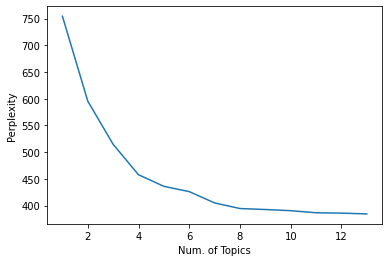

In [42]:
nltk_stopwords = nltk.corpus.stopwords.words("english") + custom_stop_words
vectorizer = CountVectorizer(tokenizer = lm.tokenize,stop_words=nltk_stopwords,ngram_range=(1,1))
DTM =vectorizer.fit_transform(df_all['text'])


num_topics=[1,2,3,4,5,6,7,8,9,10,11,12,13]
lda = LatentDirichletAllocation(n_jobs=-1,   
                                max_iter=10,  
                                random_state=2021 
                               )
perplexity=[]
for i in num_topics:
    print(i)
    lda.set_params(n_components=i)
    lda.fit(DTM)
    perplexity.append(lda.perplexity(DTM))

plt.plot(num_topics, perplexity)
plt.xlabel('Num. of Topics')
plt.ylabel('Perplexity')

In [43]:
lda = LatentDirichletAllocation(n_components=4,
                                n_jobs=-1,   
                                max_iter=20,   
                                random_state=2021 
                               )
lda.fit(DTM)

LatentDirichletAllocation(max_iter=20, n_components=4, n_jobs=-1,
                          random_state=2021)

In [44]:
#Create the top words for each topic and put them together in the same data frame.
temparray = preprocessing.normalize(lda.components_,norm="l1")
TTopicM = pd.DataFrame(np.transpose(temparray), index = vectorizer.get_feature_names())
TermOfTopic =pd.DataFrame([])
for i in range(4):
    TermOfTopic[i]=(list(TTopicM.sort_values(by=i,ascending=False).iloc[:10,i].index))
TermOfTopic

/home/abromeland/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,0,1,2,3
0,secur,secur,plan,compani
1,debt,report,com,oper
2,interest,instr,compens,gaap
3,rate,benefici,director,equip
4,note,deriv,award,net
5,warrant,transact,compani,incom
6,term,act,committe,financi
7,prospectu,titl,perform,receiv
8,fund,exchang,fiscal,total
9,supplement,compani,vote,interest


In [45]:
df_main = df_all[['form','text','filingDate']]
DTopicM = pd.DataFrame(lda.transform(DTM))
dfnew = pd.concat([df_main, DTopicM], axis=1)
dfnew.sort_values(by=0,ascending=False,inplace=True)
dfnew.reset_index(inplace=True,drop=True)
dfnew.head(5)

,form,text,filingDate,0,1,2,3
0,424B2,424b2 1 a2241156z424b2.htm 424b2 use t...,2020-03-27,0.999962,0.000013,0.000013,0.000013
1,424B3,424b3 1 a2241125z424b3.htm 424b3 use t...,2020-03-25,0.999961,0.000013,0.000013,0.000013
2,424B2,424b2 1 a2239597z424b2.htm 424b2 use t...,2019-09-05,0.999961,0.000013,0.000013,0.000013
3,424B3,424b3 1 a2239570z424b3.htm 424b3 use t...,2019-09-03,0.999961,0.000013,0.000013,0.000013
4,424B2,424b2 1 a2209838z424b2.htm 424b2 ...,2012-06-07,0.999957,0.000014,0.000014,0.000014


In [46]:
dfnew.text[0]

' 424b2 1 a2241156z424b2.htm 424b2        use these links to rapidly review the document   table of contents    table of contents                                        table of contents   filed pursuant to rule 424(b)(2) registration statement no. 333-218760     calculation of registration fee                                             title of each class of securities to be registered   amount to be registered   proposed maximum offering price per note   proposed maximum aggregate offering price   amount of registration fee(1)        2.750% senior notes due 2025    moneytoken    99.864%    moneytoken     moneytoken         3.100% senior notes due 2030    moneytoken    99.811%    moneytoken     moneytoken         3.750% senior notes due 2050    moneytoken    99.998%    moneytoken     moneytoken             moneytoken         moneytoken     moneytoken            (1)calculated in accordance with rule 457(r) of the securities act of 1933, as amended.                                     

In [49]:
dfnew.sort_values(by=1,ascending=False,inplace=True)
dfnew.reset_index(inplace=True,drop=True)
dfnew.head(5)

,form,text,filingDate,0,1,2,3
0,4,sec form 4 form 4 united states securit...,2021-01-06,0.000500,0.998502,0.000500,0.000498
1,4,sec form 4 form 4 united states securit...,2022-05-31,0.000514,0.998459,0.000514,0.000512
2,4,sec form 4 form 4 united states securit...,2021-06-03,0.000516,0.998452,0.000517,0.000514
3,4,sec form 4 form 4 united states securit...,2021-01-06,0.000527,0.998422,0.000526,0.000525
4,4,sec form 4 form 4 united states securit...,2020-12-03,0.000566,0.998304,0.000566,0.000564


In [48]:
dfnew.text[4]

'sec form 4       form 4  united states securities and exchange commissionwashington, d.c. 20549statement of changes in beneficial ownershipfiled pursuant to section 16(a) of the securities exchange act of 1934or section 30(h) of the investment company act of 1940   omb approval   omb number: 3235-0287  estimated average burden  hours per response: 0.5         check this box if no longer subject to section 16. form 4 or form 5 obligations may continue.           see           instruction 1(b).      1. name and address of reporting person*kalathur rajesh   (last) (first) (middle)   deere & company one john deere place   (street) moline il 61265    (city) (state) (zip)    2. issuer name and ticker or trading symbol       deere & co      [ de ]      5. relationship of reporting person(s) to issuer       (check all applicable)   director  10% owner   x officer (give title below)  other (specify below)  president, jd financial & cio     3. date of earliest transaction          (month/day/ye

In [50]:
dfnew.sort_values(by=2,ascending=False,inplace=True)
dfnew.reset_index(inplace=True,drop=True)
dfnew.head(5)

,form,text,filingDate,0,1,2,3
0,DEF 14A,def 14a 1 deere3307111-def14a.htm definitive ...,2018-01-12,0.000012,0.000012,0.999962,0.000014
1,DEF 14A,def 14a 1 deere3159451-def14a.htm definitive ...,2017-01-13,0.000014,0.000014,0.999959,0.000014
2,DEF 14A,def 14a 1 de3809451-def14a.htm definitive pro...,2021-01-08,0.000014,0.000014,0.999957,0.000015
3,DEF 14A,def 14a 1 deereandco_def14a.htm definitive pr...,2013-01-14,0.000015,0.000015,0.999955,0.000015
4,DEF 14A,def 14a 1 deereandco_def14a.htm definitive pr...,2012-01-13,0.000016,0.000019,0.999950,0.000015


In [51]:
dfnew.sort_values(by=3,ascending=False,inplace=True)
dfnew.reset_index(inplace=True,drop=True)
dfnew.head(5)

,form,text,filingDate,0,1,2,3
0,10-Q,us-gaap:othercostofoperatingrevenueus-gaap:oth...,2020-05-28,0.000019,0.000018,0.000018,0.999945
1,10-Q,0.0850.085http://fasb.org/us-gaap/2021-01-31#o...,2021-08-26,0.000019,0.000019,0.000019,0.999944
2,10-Q,us-gaap:othercostofoperatingrevenueus-gaap:oth...,2020-08-27,0.000019,0.000019,0.000019,0.999944
3,10-Q,0.0850.085us-gaap:otherassetsus-gaap:otherasse...,2021-05-27,0.000019,0.000019,0.000019,0.999942
4,10-Q,false--11-03q320190000315189deere & comodified...,2019-08-29,0.000021,0.000021,0.000021,0.999938


/home/abromeland/.local/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['onc'] not in stop_words.
  warnings.warn(


1
2
3
4
5
6
7
8
9
10
11
12
13


Text(0, 0.5, 'Perplexity')

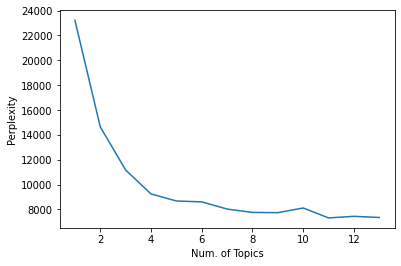

In [52]:
nltk_stopwords = nltk.corpus.stopwords.words("english") + custom_stop_words
vectorizer = CountVectorizer(tokenizer = lm.tokenize,stop_words=nltk_stopwords,ngram_range=(2,2))
DTM =vectorizer.fit_transform(df_all['text'])


num_topics=[1,2,3,4,5,6,7,8,9,10,11,12,13]
lda = LatentDirichletAllocation(n_jobs=-1,   
                                max_iter=10,  
                                random_state=2021 
                               )
perplexity=[]
for i in num_topics:
    print(i)
    lda.set_params(n_components=i)
    lda.fit(DTM)
    perplexity.append(lda.perplexity(DTM))

plt.plot(num_topics, perplexity)
plt.xlabel('Num. of Topics')
plt.ylabel('Perplexity')

In [53]:
lda = LatentDirichletAllocation(n_components=4,
                                n_jobs=-1,   
                                max_iter=20,   
                                random_state=2021 
                               )
lda.fit(DTM)

LatentDirichletAllocation(max_iter=20, n_components=4, n_jobs=-1,
                          random_state=2021)

In [54]:
#Create the top words for each topic and put them together in the same data frame.
temparray = preprocessing.normalize(lda.components_,norm="l1")
TTopicM = pd.DataFrame(np.transpose(temparray), index = vectorizer.get_feature_names())
TermOfTopic =pd.DataFrame([])
for i in range(4):
    TermOfTopic[i]=(list(TTopicM.sort_values(by=i,ascending=False).iloc[:10,i].index))
TermOfTopic

/home/abromeland/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,0,1,2,3
0,financi servic,debt secur,deriv secur,proxi statement
1,equip oper,prospectu supplement,secur instr,tabl content
2,interest rate,supplement term,secur acquir,perform period
3,net incom,interest determin,acquir dispos,execut offic
4,financ receiv,tabl content,secur benefici,corpor govern
5,construct forestri,currenc warrant,instr deriv,statement tabl
6,agricultur turf,shelf warrant,secur exchang,compani proxi
7,financi statement,feder fund,corp com,compens tabl
8,retail note,applic prospectu,follow report,elect director
9,exchang act,guarante debt,benefici ownership,audit review


In [55]:
df_main = df_all[['form','text','filingDate']]
DTopicM = pd.DataFrame(lda.transform(DTM))
dfnew = pd.concat([df_main, DTopicM], axis=1)
dfnew.sort_values(by=0,ascending=False,inplace=True)
dfnew.reset_index(inplace=True,drop=True)
dfnew.head(5)

,form,text,filingDate,0,1,2,3
0,10-K,http://fasb.org/us-gaap/2021-01-31#othercostof...,2021-12-16,0.999978,0.000007,0.000007,0.000008
1,10-K,0.0850.085us-gaap:othercostofoperatingrevenueu...,2020-12-17,0.999976,0.000008,0.000008,0.000008
2,10-K,p1mp1y0.0850.085us-gaap:othercomprehensiveinco...,2019-12-19,0.999974,0.000009,0.000009,0.000009
3,10-K,10-k 1 a2236950z10-k.htm 10-k use thes...,2018-12-17,0.999970,0.000010,0.000010,0.000010
4,10-K,10-k 1 a2233505z10-k.htm 10-k use thes...,2017-12-18,0.999969,0.000010,0.000010,0.000010


In [56]:
dfnew.sort_values(by=1,ascending=False,inplace=True)
dfnew.reset_index(inplace=True,drop=True)
dfnew.head(5)

,form,text,filingDate,0,1,2,3
0,424B2,424b2 1 a2241156z424b2.htm 424b2 use t...,2020-03-27,0.000012,0.999964,0.000012,0.000012
1,424B3,424b3 1 a2241125z424b3.htm 424b3 use t...,2020-03-25,0.000012,0.999964,0.000012,0.000012
2,424B2,424b2 1 a2239597z424b2.htm 424b2 use t...,2019-09-05,0.000012,0.999963,0.000012,0.000012
3,424B3,424b3 1 a2239570z424b3.htm 424b3 use t...,2019-09-03,0.000012,0.999963,0.000012,0.000012
4,424B2,424b2 1 a2209838z424b2.htm 424b2 ...,2012-06-07,0.000014,0.999959,0.000014,0.000014


In [60]:
dfnew.sort_values(by=2,ascending=False,inplace=True)
dfnew.reset_index(inplace=True,drop=True)
dfnew.head(5)


,form,text,filingDate,0,1,2,3
0,13F-HR,13f-hr 1 sep1213f.txt deere & company 13f-hr ...,2012-11-07,0.000086,0.000086,0.999742,0.000086
1,13F-HR,13f-hr 1 jun1213f.txt deere & company 13f-hr ...,2012-08-02,0.000087,0.000087,0.999739,0.000087
2,13F-HR,13f-hr 1 dec1113f.txt deere & company 13f-hr ...,2012-02-10,0.000088,0.000088,0.999736,0.000088
3,13F-HR,13f-hr 1 mar1313f.txt deere & company 13f-hr ...,2013-05-07,0.000089,0.000088,0.999735,0.000088
4,13F-HR,13f-hr 1 mar1213f.txt deere & company 13f-hr ...,2012-05-09,0.000089,0.000088,0.999734,0.000089


In [59]:
dfnew.sort_values(by=3,ascending=False,inplace=True)
dfnew.reset_index(inplace=True,drop=True)
dfnew.head(5)

,form,text,filingDate,0,1,2,3
0,DEF 14A,def 14a 1 deereandco_def14a.htm definitive pr...,2015-01-14,0.000009,0.000009,0.000009,0.999972
1,PRE 14A,pre 14a 1 deereandco_pre14a.htm preliminary p...,2014-12-19,0.000010,0.000010,0.000010,0.999971
2,PRE 14A,pre 14a 1 de3653751-pre14a.htm preliminary pr...,2019-12-19,0.000010,0.000010,0.000010,0.999971
3,DEF 14A,def 14a 1 de3653751-def14a.htm definitive pro...,2020-01-10,0.000010,0.000010,0.000010,0.999971
4,DEF 14A,def 14a 1 de3958541-def14a.htm definitive pro...,2022-01-07,0.000011,0.000011,0.000011,0.999966


/home/abromeland/.local/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['onc'] not in stop_words.
  warnings.warn(


1
2
3
4
5
6
7
8
9
10
11
12
13


Text(0, 0.5, 'Perplexity')

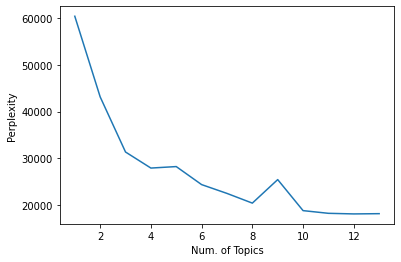

In [61]:
nltk_stopwords = nltk.corpus.stopwords.words("english") + custom_stop_words
vectorizer = CountVectorizer(tokenizer = lm.tokenize,stop_words=nltk_stopwords,ngram_range=(3,3))
DTM =vectorizer.fit_transform(df_all['text'])


num_topics=[1,2,3,4,5,6,7,8,9,10,11,12,13]
lda = LatentDirichletAllocation(n_jobs=-1,   
                                max_iter=10,  
                                random_state=2021 
                               )
perplexity=[]
for i in num_topics:
    print(i)
    lda.set_params(n_components=i)
    lda.fit(DTM)
    perplexity.append(lda.perplexity(DTM))

plt.plot(num_topics, perplexity)
plt.xlabel('Num. of Topics')
plt.ylabel('Perplexity')

In [67]:
lda = LatentDirichletAllocation(n_components=4,
                                n_jobs=-1,   
                                max_iter=20,   
                                random_state=2021 
                               )
lda.fit(DTM)

LatentDirichletAllocation(max_iter=20, n_components=4, n_jobs=-1,
                          random_state=2021)

In [68]:
#Create the top words for each topic and put them together in the same data frame.
temparray = preprocessing.normalize(lda.components_,norm="l1")
TTopicM = pd.DataFrame(np.transpose(temparray), index = vectorizer.get_feature_names())
TermOfTopic =pd.DataFrame([])
for i in range(4):
    TermOfTopic[i]=(list(TTopicM.sort_values(by=i,ascending=False).iloc[:10,i].index))
TermOfTopic

/home/abromeland/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,0,1,2,3
0,secur acquir dispos,secur exchang act,prospectu supplement term,proxi statement tabl
1,deriv secur instr,pursuant exchang act,interest rate contract,statement tabl content
2,deriv secur acquir,exchang act cfr,consolid financi statement,compani proxi statement
3,instr deriv secur,commun pursuant exchang,gaap fairvalueinputslevel memberu,audit review committe
4,expir titl amount,commenc commun pursuant,fairvalueinputslevel memberu gaap,independ public account
5,indirect instr natur,act cfr pre,financi servic oper,advisori vote execut
6,ownership direct indirect,pre commenc commun,equip oper leas,chief execut offic
7,indirect benefici ownership,cfr pre commenc,turf construct forestri,public account firm
8,direct indirect instr,secur exchang commiss,agricultur turf construct,corpor govern committe
9,benefici ownership instr,www johndeer com,comprehens incom loss,summari compens tabl


In [69]:
df_main = df_all[['form','text','filingDate']]
DTopicM = pd.DataFrame(lda.transform(DTM))
dfnew = pd.concat([df_main, DTopicM], axis=1)
dfnew.sort_values(by=0,ascending=False,inplace=True)
dfnew.reset_index(inplace=True,drop=True)
dfnew.head(5)

,form,text,filingDate,0,1,2,3
0,4,sec form 4 form 4 united states securit...,2021-01-06,0.998526,0.000492,0.000491,0.000491
1,4,sec form 4 form 4 united states securit...,2022-05-31,0.998481,0.000507,0.000506,0.000506
2,4,sec form 4 form 4 united states securit...,2021-06-03,0.998475,0.000509,0.000508,0.000508
3,4,sec form 4 form 4 united states securit...,2021-01-06,0.998446,0.000518,0.000518,0.000518
4,4,sec form 4 form 4 united states securit...,2020-12-03,0.998329,0.000558,0.000557,0.000557


In [70]:
dfnew.sort_values(by=1,ascending=False,inplace=True)
dfnew.reset_index(inplace=True,drop=True)
dfnew.head(5)

,form,text,filingDate,0,1,2,3
0,S-8,s-8 1 a15-5170_1s8.htm s-8 as fi...,2015-02-26,0.000212,0.999363,0.000214,0.000212
1,SC 13G,sc 13g 1 d256062dsc13g.htm sc 13g sc 13g ...,2016-02-16,0.000226,0.999322,0.000226,0.000226
2,S-8 POS,s-8 pos 1 tm209665d2_s8pos.htm s-8 pos ...,2020-02-26,0.000227,0.999319,0.000227,0.000227
3,S-8 POS,s-8 pos 1 tm209665d3_s8pos.htm s-8 pos ...,2020-02-26,0.000227,0.999319,0.000227,0.000227
4,S-8 POS,s-8 pos 1 tm209665d1_s8pos.htm s-8 pos ...,2020-02-26,0.000227,0.999319,0.000227,0.000227


In [71]:
dfnew.sort_values(by=2,ascending=False,inplace=True)
dfnew.reset_index(inplace=True,drop=True)
dfnew.head(5)

,form,text,filingDate,0,1,2,3
0,10-K,http://fasb.org/us-gaap/2021-01-31#othercostof...,2021-12-16,0.000007,0.000007,0.999978,0.000007
1,10-K,0.0850.085us-gaap:othercostofoperatingrevenueu...,2020-12-17,0.000008,0.000008,0.999977,0.000008
2,10-K,p1mp1y0.0850.085us-gaap:othercomprehensiveinco...,2019-12-19,0.000008,0.000009,0.999974,0.000009
3,10-K,10-k 1 a2236950z10-k.htm 10-k use thes...,2018-12-17,0.000010,0.000010,0.999971,0.000010
4,10-K,10-k 1 a2233505z10-k.htm 10-k use thes...,2017-12-18,0.000010,0.000010,0.999969,0.000010


In [72]:
dfnew.sort_values(by=3,ascending=False,inplace=True)
dfnew.reset_index(inplace=True,drop=True)
dfnew.head(5)

,form,text,filingDate,0,1,2,3
0,DEF 14A,def 14a 1 deereandco_def14a.htm definitive pr...,2015-01-14,0.000009,0.000009,0.000009,0.999972
1,PRE 14A,pre 14a 1 deereandco_pre14a.htm preliminary p...,2014-12-19,0.000009,0.000009,0.000009,0.999972
2,PRE 14A,pre 14a 1 de3653751-pre14a.htm preliminary pr...,2019-12-19,0.000009,0.000010,0.000009,0.999972
3,DEF 14A,def 14a 1 de3653751-def14a.htm definitive pro...,2020-01-10,0.000009,0.000010,0.000009,0.999972
4,DEF 14A,def 14a 1 de3958541-def14a.htm definitive pro...,2022-01-07,0.000011,0.000011,0.000011,0.999966


### Data Questions

1.	Which standard forms filed with the SEC have the highest sentiment scores?

In [73]:
df_forms = df.copy()
df_forms.sort_values(by='form',ascending=False,inplace=True)
df_forms.reset_index(inplace=True,drop=True)
df_forms = df_forms.set_index(['form',df.index])
df_forms

accessionNumber filingDate  reportDate  \
form                                                       
UPLOAD 0     0000000000-13-016575 2013-03-28               
       1     0000000000-17-004743 2017-02-10               
       2     0000000000-20-003469 2020-04-22               
       3     0000000000-16-066018 2016-02-23               
       4     0000000000-20-001947 2020-03-03               
...                           ...        ...         ...   
10-K   996   0001047469-17-007719 2017-12-18  2017-10-29   
       997   0001104659-11-070023 2011-12-19  2011-10-31   
       998   0001104659-13-090354 2013-12-16  2013-10-31   
       999   0001047469-16-017244 2016-12-19  2016-10-31   
       1000  0001047469-15-009300 2015-12-18  2015-10-31   

                   acceptanceDateTime act fileNumber filmNumber items  \
form                                                                    
UPLOAD 0     2013-03-28T13:58:24.000Z                                   
       1     2017-02-10T12:01:46.000Z                                   
       2     2020-04-22T17:09:40.000Z                                   
       3     2016-02-23T16:39:18.000Z                                   
       4     2020-03-03T17:11:05.000Z                                   
...                               ...  ..        ...        ...   ...   
10-K   996   2017-12-18T11:40:12.000Z  34  001-04121  171260760         
       997   2011-12-19T10:24:03.000Z  34  001-04121  111268216         
       998   2013-12-16T12:34:48.000Z  34  001-04121  131278357         
       999   2016-12-19T10:46:49.000Z  34  001-04121  162058076         
       1000  2015-12-18T13:02:26.000Z  34  001-04121  151296127         

                 size  isXBRL  isInlineXBRL     primaryDocument  \
form                                                              
UPLOAD 0       201296       0             0       filename1.pdf   
       1        33311       0             0       filename1.pdf   
       2        39305       0             0       filename1.pdf   
       3        36020       0             0       filename1.pdf   
       4        49597       0             0       filename1.pdf   
...               ...     ...           ...                 ...   
10-K   996   36920361       1             0   a2233505z10-k.htm   
       997   39511294       1             0  a11-24734_110k.htm   
       998   43455188       1             0  a13-17985_110k.htm   
       999   35585821       1             0   a2230400z10-k.htm   
       1000  36106600       1             0   a2226814z10-k.htm   

            primaryDocDescription  \
form                                
UPLOAD 0                            
       1                            
       2                            
       3                            
       4                            
...                           ...   
10-K   996                   10-K   
       997                   10-K   
       998                   10-K   
       999                   10-K   
       1000                  10-K   

                                                          text           Type  \
form                                                                            
UPLOAD 0                                 united states   se...  <class 'str'>   
       1         mail stop 3030   february 10 , 2017       ...  <class 'str'>   
       2     april 22, 2020 ryan d. campbell chief financia...  <class 'str'>   
       3         mail stop 3030   february 23 , 2016     vi...  <class 'str'>   
       4     march 3, 2020 ryan d. campbell chief financial...  <class 'str'>   
...                                                        ...            ...   
10-K   996    10-k 1 a2233505z10-k.htm 10-k        use thes...  <class 'str'>   
       997    10-k 1 a11-24734_110k.htm 10-k               ...  <class 'str'>   
       998    10-k 1 a13-17985_110k.htm 10-k             ta...  <class 'str'>   
       999    10-k 1 a2230400z10-k.htm 10-

In [74]:
sentiment = df_forms[['AFINN','TextBlob','VADER','LMTitle']].groupby(level='form').mean()
df_sent = pd.DataFrame([])
for i in ['AFINN','TextBlob','VADER','LMTitle']:
    df_sent[i] = (list(sentiment.sort_values(by=i,ascending=False)[i][:10].index))
df_sent

,AFINN,TextBlob,VADER,LMTitle
0,PRE 14A,NO ACT,10-K,25-NSE
1,DEF 14A,ARS,424B3,NO ACT
2,10-K,11-K,S-3ASR,ARS
3,10-K/A,SD,DEF 14A,8-K
4,424B2,PX14A6G,10-K/A,DEFA14A
5,424B3,UPLOAD,424B2,13F-HR
6,10-Q,IRANNOTICE,10-Q,11-K
7,S-3ASR,8-K,PRE 14A,3
8,11-K,3/A,10-Q/A,SC 13D/A
9,S-8 POS,13F-HR,S-8 POS,PX14A6G


In [75]:
sentiment = df_forms[['AFINN','TextBlob','VADER','LMTitle']].groupby(level='form').max()
df_sent = pd.DataFrame([])
for i in ['AFINN','TextBlob','VADER','LMTitle']:
    df_sent[i] = (list(sentiment.sort_values(by=i,ascending=False)[i][:10].index))
df_sent

,AFINN,TextBlob,VADER,LMTitle
0,DEF 14A,11-K,10-K,8-K
1,PRE 14A,NO ACT,PRE 14A,25-NSE
2,10-K,ARS,DEF 14A,11-K
3,10-Q,PX14A6G,10-K/A,ARS
4,10-K/A,SD,424B3,NO ACT
5,424B2,UPLOAD,424B2,DEFA14A
6,424B3,8-K,S-3ASR,13F-HR
7,S-3ASR,13F-HR,11-K,SC 13G
8,11-K,CORRESP,10-Q,SC 13D/A
9,SC 13G,4,SC 13G,SC 13G/A


In [76]:
sentiment = df_forms[['AFINN','TextBlob','VADER','LMTitle']].groupby(level='form').min()
df_sent = pd.DataFrame([])
for i in ['AFINN','TextBlob','VADER','LMTitle']:
    df_sent[i] = (list(sentiment.sort_values(by=i,ascending=True)[i][:10].index))
df_sent

,AFINN,TextBlob,VADER,LMTitle
0,4,4,NO ACT,UPLOAD
1,3,3,SD,IRANNOTICE
2,3/A,DEFA14A,IRANNOTICE,CORRESP
3,SD,8-K,11-K,FWP
4,25-NSE,FWP,ARS,8-K
5,4/A,25-NSE,UPLOAD,SD
6,IRANNOTICE,CORRESP,8-K,11-K
7,NO ACT,SC 13G,13F-HR,SC 13D/A
8,8-K,SC 13D/A,CORRESP,SC 13G/A
9,11-K,SC 13G/A,25-NSE,S-3ASR


In [77]:
sentiment = df_forms[['AFINN','TextBlob','VADER','LMTitle']].groupby(level='form').var()
df_sent = pd.DataFrame([])
for i in ['AFINN','TextBlob','VADER','LMTitle']:
    df_sent[i] = (list(sentiment.sort_values(by=i,ascending=False)[i][:10].index))
df_sent

,AFINN,TextBlob,VADER,LMTitle
0,DEF 14A,11-K,11-K,11-K
1,10-K,PX14A6G,SD,UPLOAD
2,11-K,3,UPLOAD,8-K
3,10-Q,8-K,13F-HR,SC 13G
4,424B3,CORRESP,CORRESP,CORRESP
5,424B2,UPLOAD,8-K,SC 13D/A
6,SC 13G,DEFA14A,PX14A6G,DEFA14A
7,13F-HR,SC 13G,DEFA14A,SC 13G/A
8,DEFA14A,13F-HR,4/A,FWP
9,SC 13D/A,4,3,S-8


In [78]:
sentiment = df_forms[['AFINN','TextBlob','VADER','LMTitle']].groupby(level='form').std()
df_sent = pd.DataFrame([])
for i in ['AFINN','TextBlob','VADER','LMTitle']:
    df_sent[i] = (list(sentiment.sort_values(by=i,ascending=False)[i][:10].index))
df_sent

,AFINN,TextBlob,VADER,LMTitle
0,DEF 14A,11-K,11-K,11-K
1,10-K,PX14A6G,SD,UPLOAD
2,11-K,3,UPLOAD,8-K
3,10-Q,8-K,13F-HR,SC 13G
4,424B3,CORRESP,CORRESP,CORRESP
5,424B2,UPLOAD,8-K,SC 13D/A
6,SC 13G,DEFA14A,PX14A6G,DEFA14A
7,13F-HR,SC 13G,DEFA14A,SC 13G/A
8,DEFA14A,13F-HR,4/A,FWP
9,SC 13D/A,4,3,S-8


In [ ]:
#print(df_all[df_all['LMTitle'] == df_all['LMTitle'].max()])
#df_all['text'][842]

In [79]:
df_8K = df_all[df_all['form']=='8-K']
max_form = df_8K[df_8K['LMTitle'] == df_8K['LMTitle'].max()]
max_form = max_form[['form','filingDate','LMTitle','Adj Close']]
max_form


,form,filingDate,LMTitle,Adj Close
135,8-K,2020-11-18,1.0,252.205902
146,8-K,2020-08-12,1.0,187.835083
239,8-K,2019-08-07,1.0,144.844498
248,8-K,2019-05-08,1.0,148.328842
269,8-K,2019-02-06,1.0,155.291962
304,8-K,2018-11-14,1.0,138.951981
309,8-K,2018-08-08,1.0,136.058197
316,8-K,2018-05-09,1.0,135.711823
341,8-K,2018-02-07,1.0,150.337051
383,8-K,2017-11-15,1.0,122.707199


In [80]:
#print(df_all[df_all['LMTitle'] == df_all['LMTitle'].min()])
#print(df_all['text'][139])

In [81]:
df_forms = df_all.copy()
df_forms.sort_values(by='form',ascending=False,inplace=True)
df_forms.reset_index(inplace=True,drop=True)
df_forms = df_forms.set_index(['form',df_all.index])
df_forms
print(df_forms[['dayDiff','weekDiff','monthDiff']].groupby(level='form').max())
priceDiff = df_forms[['dayDiff','weekDiff','monthDiff']].groupby(level='form').max().abs()
print(priceDiff)
df_sent = pd.DataFrame([])
for i in ['dayDiff','weekDiff','monthDiff']:
    df_sent[i] = (list(priceDiff.sort_values(by=i,ascending=False)[i][:10].index))
df_sent

              dayDiff   weekDiff  monthDiff
form                                       
10-K         6.047119   4.586792  41.014252
10-K/A      -1.972046   0.239845   6.102676
10-Q        13.171692  38.927582  89.293915
10-Q/A       3.939102  13.614517  -3.866272
11-K        10.212402   0.697815  25.277130
13F-HR       2.890892  12.041565  20.196075
25-NSE       0.685760   4.024963  13.207764
3            7.728210  13.683990  24.535477
3/A          0.847443   5.782959   0.661316
4           11.676819  38.838165  59.367371
4/A          1.726864  14.632690  46.995117
424B2        6.685623   6.665665  12.389801
424B3       10.242592  12.660965  14.141800
8-K         21.969391  47.246704  65.531952
CORRESP      5.674683  21.297318  37.488327
DEF 14A      1.265869   6.005569  19.392670
DEFA14A      1.265869   6.005569  19.392670
FWP         10.242592  12.660965  14.141800
IRANNOTICE  -2.939240   2.171997 -59.941528
PRE 14A      1.818375   2.934433   0.045212
PX14A6G      0.914951   1.447941

,dayDiff,weekDiff,monthDiff
0,8-K,8-K,10-Q
1,10-Q,10-Q,8-K
2,4,4,IRANNOTICE
3,FWP,SC 13G/A,SC 13G/A
4,424B3,SD,4
5,11-K,CORRESP,4/A
6,UPLOAD,SC 13D/A,10-K
7,3,UPLOAD,CORRESP
8,S-8 POS,4/A,S-8 POS
9,424B2,3,11-K


In [82]:
print(df_all[df_all['dayDiff']==df_all['dayDiff'].max()])

        accessionNumber filingDate  reportDate        acceptanceDateTime act  \
8  0001558370-22-009205 2022-05-20  2022-05-20  2022-05-20T06:02:47.000Z  34   

  form fileNumber filmNumber           items     size  ...  weekPCTCL  \
8  8-K  001-04121   22945209  2.02,7.01,9.01  6198958  ...   0.131456   

   monthDiff monthDiffCL  monthPCT monthPCTCL dayDiff_SCALE  weekDiff_SCALE  \
8 -15.742249  -15.799988 -0.053107  -0.053107           1.0             1.0   

   monthDiff_SCALE  Adj_Close_SCALE  characters  
8          0.30259         0.690626        3838  

[1 rows x 44 columns]


In [83]:
print(df_all[df_all['weekDiff']==df_all['weekDiff'].max()])

        accessionNumber filingDate  reportDate        acceptanceDateTime act  \
8  0001558370-22-009205 2022-05-20  2022-05-20  2022-05-20T06:02:47.000Z  34   

  form fileNumber filmNumber           items     size  ...  weekPCTCL  \
8  8-K  001-04121   22945209  2.02,7.01,9.01  6198958  ...   0.131456   

   monthDiff monthDiffCL  monthPCT monthPCTCL dayDiff_SCALE  weekDiff_SCALE  \
8 -15.742249  -15.799988 -0.053107  -0.053107           1.0             1.0   

   monthDiff_SCALE  Adj_Close_SCALE  characters  
8          0.30259         0.690626        3838  

[1 rows x 44 columns]


In [84]:
df_8K = df_all[df_all['form'] == '8-K']
print(df_8K[df_8K['weekDiff']==df_8K['weekDiff'].max()])

        accessionNumber filingDate  reportDate        acceptanceDateTime act  \
8  0001558370-22-009205 2022-05-20  2022-05-20  2022-05-20T06:02:47.000Z  34   

  form fileNumber filmNumber           items     size  ...  weekPCTCL  \
8  8-K  001-04121   22945209  2.02,7.01,9.01  6198958  ...   0.131456   

   monthDiff monthDiffCL  monthPCT monthPCTCL dayDiff_SCALE  weekDiff_SCALE  \
8 -15.742249  -15.799988 -0.053107  -0.053107           1.0             1.0   

   monthDiff_SCALE  Adj_Close_SCALE  characters  
8          0.30259         0.690626        3838  

[1 rows x 44 columns]


In [85]:
print(df_all[df_all['monthDiff']==df_all['monthDiff'].max()])

         accessionNumber filingDate  reportDate        acceptanceDateTime act  \
27  0001558370-22-001900 2022-02-24  2022-01-30  2022-02-24T14:35:21.000Z  34   

    form fileNumber filmNumber items      size  ...  weekPCTCL  monthDiff  \
27  10-Q  001-04121   22669887        20479679  ...   0.102558  89.293915   

   monthDiffCL  monthPCT monthPCTCL dayDiff_SCALE  weekDiff_SCALE  \
27   89.849976  0.207693   0.207693      0.572061        0.911784   

    monthDiff_SCALE  Adj_Close_SCALE  characters  
27              1.0         0.765426      201978  

[1 rows x 44 columns]


In [86]:
print(df_forms[['dayDiff','weekDiff','monthDiff']].groupby(level='form').mean())
priceDiff = df_forms[['dayDiff','weekDiff','monthDiff']].groupby(level='form').mean().abs()
print(priceDiff)
df_sent = pd.DataFrame([])
for i in ['dayDiff','weekDiff','monthDiff']:
    df_sent[i] = (list(priceDiff.sort_values(by=i,ascending=False)[i][:10].index))
df_sent

             dayDiff   weekDiff  monthDiff
form                                      
10-K        1.310493   1.313620  11.252209
10-K/A     -1.972046   0.239845   6.102676
10-Q        0.315808   2.357522   2.219782
10-Q/A      3.939102  13.614517  -3.866272
11-K       -3.228224  -4.163686 -10.457785
13F-HR      0.376672  -0.141984   0.939147
25-NSE      0.685760   4.024963  13.207764
3           0.390260   1.641866   5.475946
3/A         0.419632   2.752670  -0.465515
4           0.337324   0.939831   5.681612
4/A        -2.504324   4.145694   3.946608
424B2       2.513953   2.923654   9.143929
424B3       4.201815   6.780579  11.145640
8-K         0.128053   0.921698   1.108157
CORRESP    -0.828094   0.470355  11.946628
DEF 14A     0.080407   1.791316   3.831519
DEFA14A     0.004853   2.195563   3.928655
FWP         4.201815   6.780579  11.145640
IRANNOTICE -2.939240   2.171997 -59.941528
PRE 14A     0.969204   1.742973  -0.474014
PX14A6G    -0.620802  -1.795317  -5.758841
S-3ASR     

,dayDiff,weekDiff,monthDiff
0,S-8 POS,10-Q/A,IRANNOTICE
1,FWP,424B3,S-8 POS
2,424B3,FWP,S-8
3,10-Q/A,11-K,25-NSE
4,S-8,4/A,CORRESP
5,11-K,25-NSE,10-K
6,IRANNOTICE,S-8 POS,FWP
7,424B2,UPLOAD,424B3
8,4/A,SC 13D/A,11-K
9,10-K/A,424B2,424B2


## Sparse Logistic Regression

1. Dataset Preparation
    - Add column for daily difference - positive or negative
    - Add column for weekly difference - positive or negative
    - Add column for monthly difference - positive or negative
    - Data was already cleaned in prior steps
    - Create DTMs for training and testing data
2. Feature Engineering
3. Model Training
4. Descriptive Analytics
5. Performance Metric

### Daily Difference

In [87]:
df = df_all[["text","dayDiff"]].copy()
df['dayDiff'] = np.where(df.dayDiff > 0 ,'postive','negative')
df

,text,dayDiff
0,sec form 4 form 4 united states securit...,negative
1,sec form 4 form 4 united states securit...,negative
2,0000315189falsedeere & co0000315189us-gaap:com...,negative
3,sec form 4 form 4 united states securit...,negative
4,irannotice 1 tm2217194d1_irannotice.htm irann...,negative
...,...,...
969,13f-hr 1 sep1113f.txt deere & company 13f-hr ...,postive
970,sec form 4 form 4 united states securit...,postive
971,sec form 4 form 4 united states securit...,postive
972,sec form 4 form 4 united states securit...,postive


In [88]:
df_train, df_test = train_test_split(df, test_size=0.33, random_state=2021)
df_train.reset_index(drop=True,inplace=True)
df_test.reset_index(drop=True,inplace=True)

In [89]:
lm = ps.LM()
vectorizer = TfidfVectorizer(tokenizer = lm.tokenize,stop_words=custom_stop_words)
#Create the training DTM and the labels
train_x = vectorizer.fit_transform(df_train["text"])
train_y = df_train["dayDiff"]
train_x.shape

(652, 5521)

In [90]:
#Create the testing DTM and the labels
test_x = vectorizer.transform(df_test["text"])
test_y = df_test["dayDiff"]
test_x.shape

(322, 5521)

In [91]:
pd.DataFrame({'Train': train_y.value_counts(),
              'Test': test_y.value_counts()})

,Train,Test
postive,367,181
negative,285,141


In [92]:
sparselr = LogisticRegression(penalty='l1', 
                              solver='liblinear',
                              random_state=2021,
                              tol=0.0001,
                              max_iter=1000, 
                              C=1)
sparselr.fit(train_x,train_y)

LogisticRegression(C=1, max_iter=1000, penalty='l1', random_state=2021,
                   solver='liblinear')

In [93]:
#How many non-zero betas in total
sum(sparselr.coef_[0]!=0)

5

In [94]:
dfbeta = pd.DataFrame({'Term': vectorizer.get_feature_names(),
                       'Beta': sparselr.coef_[0]
                     })

/home/abromeland/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [95]:
#Show the most positive terms
dfbeta.sort_values(by="Beta",inplace=True,ascending=False)
dfbeta.reset_index(inplace=True,drop=True)
dfbeta.head(10)

,Term,Beta
0,nonemploye,5.668664
1,debt,1.191403
2,interest,0.483186
3,aa,0.000000
4,plantron,0.000000
5,planter,0.000000
6,plansnot,0.000000
7,plansapprov,0.000000
8,planpursu,0.000000
9,plannot,0.000000


In [96]:
#Show the most negative terms
dfbeta.sort_values(by="Beta",inplace=True,ascending=True)
dfbeta.reset_index(inplace=True,drop=True)
dfbeta.head(10)

,Term,Beta
0,registr,-0.773863
1,exhibit,-0.021967
2,faa,0.000000
3,abm,0.000000
4,abovemarket,0.000000
5,abruptli,0.000000
6,absen,0.000000
7,accountspayableandaccruedliabilitiesmemberu,0.000000
8,absenc,0.000000
9,absolut,0.000000


In [97]:
# Accuracy
print("Train:")
print(accuracy_score(train_y,sparselr.predict(train_x)))
print("Test:")
print(accuracy_score(test_y,sparselr.predict(test_x)))

Train:
0.5766871165644172
Test:
0.5434782608695652


In [98]:
# AUC Score
print("Train:")
print(roc_auc_score(train_y,sparselr.predict_proba(train_x)[:, 1]))
print("Test:")
print(roc_auc_score(test_y,sparselr.predict_proba(test_x)[:, 1]))

Train:
0.6207180075529424
Test:
0.5417107480114416


### Weekly Difference

In [99]:
df = df_all[["text","weekDiff"]].copy()
df['weekDiff'] = np.where(df.weekDiff > 0 ,'postive','negative')

df_train, df_test = train_test_split(df, test_size=0.33, random_state=2021)
df_train.reset_index(drop=True,inplace=True)
df_test.reset_index(drop=True,inplace=True)

lm = ps.LM()
vectorizer = TfidfVectorizer(tokenizer = lm.tokenize,stop_words=custom_stop_words)
#Create the training DTM and the labels
train_x = vectorizer.fit_transform(df_train["text"])
train_y = df_train["weekDiff"]
train_x.shape

#Create the testing DTM and the labels
test_x = vectorizer.transform(df_test["text"])
test_y = df_test["weekDiff"]
test_x.shape

print(pd.DataFrame({'Train': train_y.value_counts(),
              'Test': test_y.value_counts()}))

sparselr = LogisticRegression(penalty='l1', 
                              solver='liblinear',
                              random_state=2021,
                              tol=0.0001,
                              max_iter=1000, 
                              C=1)
sparselr.fit(train_x,train_y)

#How many non-zero betas in total
print(sum(sparselr.coef_[0]!=0))

dfbeta = pd.DataFrame({'Term': vectorizer.get_feature_names(),
                       'Beta': sparselr.coef_[0]
                     })

          Train  Test
postive     382   195
negative    270   127
10


/home/abromeland/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [100]:
#Show the most positive terms
dfbeta.sort_values(by="Beta",inplace=True,ascending=False)
dfbeta.reset_index(inplace=True,drop=True)
dfbeta.head(10)

,Term,Beta
0,settlement,8.313902
1,equiti,8.024136
2,vote,0.804315
3,incent,0.722808
4,proxi,0.586951
5,gaap,0.142171
6,plancompens,0.000000
7,planpursu,0.000000
8,plannot,0.000000
9,plannet,0.000000


In [101]:
#Show the most negative terms
dfbeta.sort_values(by="Beta",inplace=True,ascending=True)
dfbeta.reset_index(inplace=True,drop=True)
dfbeta.head(10)

,Term,Beta
0,director,-0.879645
1,particip,-0.817201
2,earn,-0.519970
3,report,-0.177201
4,commerc,0.000000
5,abil,0.000000
6,abm,0.000000
7,abovemarket,0.000000
8,abruptli,0.000000
9,absen,0.000000


In [102]:
# Accuracy
print("Train:")
print(accuracy_score(train_y,sparselr.predict(train_x)))
print("Test:")
print(accuracy_score(test_y,sparselr.predict(test_x)))

Train:
0.6073619631901841
Test:
0.6211180124223602


In [103]:
# AUC Score
print("Train:")
print(roc_auc_score(train_y,sparselr.predict_proba(train_x)[:, 1]))
print("Test:")
print(roc_auc_score(test_y,sparselr.predict_proba(test_x)[:, 1]))

Train:
0.6950649602482064
Test:
0.6865737936604078


### Monthly Difference

In [104]:
df = df_all[["text","monthDiff"]].copy()
df['monthDiff'] = np.where(df.monthDiff > 0 ,'postive','negative')

df_train, df_test = train_test_split(df, test_size=0.33, random_state=2021)
df_train.reset_index(drop=True,inplace=True)
df_test.reset_index(drop=True,inplace=True)

lm = ps.LM()
vectorizer = TfidfVectorizer(tokenizer = lm.tokenize,stop_words=custom_stop_words)
#Create the training DTM and the labels
train_x = vectorizer.fit_transform(df_train["text"])
train_y = df_train["monthDiff"]
print(train_x.shape)

#Create the testing DTM and the labels
test_x = vectorizer.transform(df_test["text"])
test_y = df_test["monthDiff"]
print(test_x.shape)

print(pd.DataFrame({'Train': train_y.value_counts(),
              'Test': test_y.value_counts()}))

sparselr = LogisticRegression(penalty='l1', 
                              solver='liblinear',
                              random_state=2021,
                              tol=0.0001,
                              max_iter=1000, 
                              C=1)
sparselr.fit(train_x,train_y)

#How many non-zero betas in total
print(sum(sparselr.coef_[0]!=0))

dfbeta = pd.DataFrame({'Term': vectorizer.get_feature_names(),
                       'Beta': sparselr.coef_[0]
                     })

#Show the most positive terms
dfbeta.sort_values(by="Beta",inplace=True,ascending=False)
dfbeta.reset_index(inplace=True,drop=True)
dfbeta.head(10)

(652, 5521)
(322, 5521)
          Train  Test
postive     417   207
negative    235   115
10


/home/abromeland/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Term,Beta
0,equiti,3.385010
1,d,0.726470
2,instr,0.665112
3,exempt,0.206815
4,comment,0.159968
5,plannot,0.000000
6,plantron,0.000000
7,planth,0.000000
8,planter,0.000000
9,plansnot,0.000000


In [105]:
#Show the most negative terms
dfbeta.sort_values(by="Beta",inplace=True,ascending=True)
dfbeta.reset_index(inplace=True,drop=True)
dfbeta.head(10)

,Term,Beta
0,plan,-4.393259
1,nonemploye,-1.120513
2,blackrock,-0.627604
3,com,-0.394447
4,manag,-0.030871
5,abm,0.000000
6,abovemarket,0.000000
7,abruptli,0.000000
8,absen,0.000000
9,accountspayableandaccruedliabilitiesmemberu,0.000000


In [106]:
# Accuracy
print("Train:")
print(accuracy_score(train_y,sparselr.predict(train_x)))
print("Test:")
print(accuracy_score(test_y,sparselr.predict(test_x)))

# AUC Score
print("Train:")
print(roc_auc_score(train_y,sparselr.predict_proba(train_x)[:, 1]))
print("Test:")
print(roc_auc_score(test_y,sparselr.predict_proba(test_x)[:, 1]))

Train:
0.6579754601226994
Test:
0.6490683229813664
Train:
0.665457421297005
Test:
0.6497584541062802


### Regression Analysis
    - First Attempt at Regression Analysis using Lasso

In [123]:
df = df_all[["text","Adj Close"]].copy()


df_train, df_test = train_test_split(df, test_size=0.33, random_state=2021)
df_train.reset_index(drop=True,inplace=True)
df_test.reset_index(drop=True,inplace=True)

lm = ps.LM()
vectorizer = TfidfVectorizer(tokenizer = lm.tokenize,stop_words=custom_stop_words)
#Create the training DTM and the labels
train_x = vectorizer.fit_transform(df_train["text"])
train_y = df_train["Adj Close"]
print(train_x.shape)

#Create the testing DTM and the labels
test_x = vectorizer.transform(df_test["text"])
test_y = df_test["Adj Close"]
print(test_x.shape)

scaler = MaxAbsScaler()
scaler.fit(train_x)
train_x=scaler.transform(train_x)
test_x=scaler.transform(test_x)



(652, 5521)
(322, 5521)


In [128]:
lasso = Lasso(alpha=0.01, #Regularization parameter.
              max_iter=75000
              )
lasso.fit(train_x,train_y)
print(np.count_nonzero(lasso.coef_))
#Check the percentage of non-zero slopes
print(np.count_nonzero(lasso.coef_)/len(lasso.coef_))

dfbeta = pd.DataFrame({'Term': vectorizer.get_feature_names_out(),
                       'Beta': lasso.coef_
                     })
dfbeta.sort_values(by="Beta",inplace=True,ascending=False)
dfbeta.reset_index(inplace=True,drop=True)
dfbeta.head(10)

284
0.0514399565296142


,Term,Beta
0,incent,508.696005
1,nonemploye,421.509580
2,spous,308.279592
3,caret,261.692956
4,aperio,230.546451
5,defer,214.959160
6,sum,213.533944
7,rate,206.110521
8,par,185.359732
9,lifecycl,179.224636


In [129]:
dfbeta.sort_values(by="Beta",inplace=True,ascending=True)
dfbeta.reset_index(inplace=True,drop=True)
dfbeta.head(10)

,Term,Beta
0,acquir,-486.771527
1,award,-390.962555
2,plan,-352.028603
3,children,-316.602940
4,lagemann,-284.914084
5,elect,-230.702192
6,exempt,-224.060506
7,benefit,-205.569948
8,convert,-197.396144
9,abil,-194.492189


In [130]:
#Apply the model to the reviews testing set and predict the star ratings
print(lasso.predict(test_x)[0:10])
print(test_y[0:10])

[410.82253331 115.29513727 -39.60053739  74.78518337  84.70909339
 195.34676393  53.12176597  69.17424975 106.42815966  81.69820551]
0    327.556183
1     92.036453
2    153.100128
3     77.526787
4     75.266930
5    253.842636
6     76.534294
7     77.522095
8     73.685997
9    140.147949
Name: Adj Close, dtype: float64


In [131]:
print("Mean Squared Error:")
print("Training:")
print(mean_squared_error(train_y,lasso.predict(train_x),squared=False))
print()
print("Testing:")
print(mean_squared_error(test_y,lasso.predict(test_x),squared=False))
print()
print("R-Squared:")
print("Training:")
print(r2_score(train_y,lasso.predict(train_x)))
print()
print("Testing:")
print(r2_score(test_y,lasso.predict(test_x)))

Mean Squared Error:
Training:
33.54341148357659

Testing:
94.50583151073442

R-Squared:
Training:
0.8579526850421331

Testing:
-0.10544621655637987


### Lasso Regression Cross-Fold Validation

    Lasso Regression k-fold cross validation using different alphas. 

Starting Regression Analysis on : Adj Close
(652, 5521)
(322, 5521)


/home/abromeland/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2306.088310075167, tolerance: 407.46454733803046
  model = cd_fast.sparse_enet_coordinate_descent(
/home/abromeland/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7469.2642592076445, tolerance: 407.46454733803046
  model = cd_fast.sparse_enet_coordinate_descent(
/home/abromeland/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44037.92837879871, tolerance: 407.46454733803046
  model = cd_fast.sparse_enet_coordinate_descent(
/home/abromeland/.local/lib/python3.9/site-packages/sklea

(652, 5521)
[1.00000000e+00 3.59381366e-01 1.29154967e-01 4.64158883e-02
 1.66810054e-02 5.99484250e-03 2.15443469e-03 7.74263683e-04
 2.78255940e-04 1.00000000e-04]


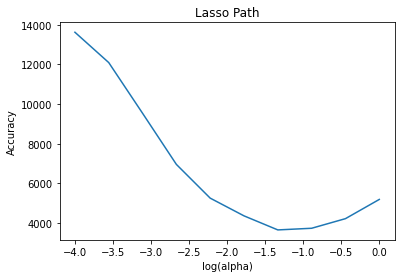

0.046415888336127774

Mean Squared Error:
Training:
38.81712392685279

Testing:
72.46226038282263

R-Squared:
Training:
0.8097760120619097

Testing:
0.35010357259431935
239
0.04328925919217533
Finishing Regression Analysis on : Adj Close
Starting Regression Analysis on : dayDiff
(652, 5521)
(322, 5521)


/home/abromeland/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.538527309789629, tolerance: 0.5417955450211513
  model = cd_fast.sparse_enet_coordinate_descent(
/home/abromeland/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9373542030077715, tolerance: 0.5271775622004321
  model = cd_fast.sparse_enet_coordinate_descent(
/home/abromeland/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.568344527773661, tolerance: 0.5271775622004321
  model = cd_fast.sparse_enet_coordinate_descent(
/home/abromeland/.local/lib/python3.9/site-packages/skle

(652, 5521)
[1.00000000e+00 3.59381366e-01 1.29154967e-01 4.64158883e-02
 1.66810054e-02 5.99484250e-03 2.15443469e-03 7.74263683e-04
 2.78255940e-04 1.00000000e-04]


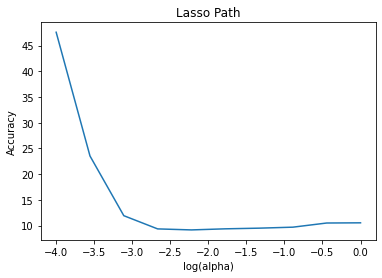

0.005994842503189409

Mean Squared Error:
Training:
2.144051792432151

Testing:
3.5548923121043337

R-Squared:
Training:
0.5629332975898462

Testing:
-0.03449177802326053
157
0.028436877377286722
Finishing Regression Analysis on : dayDiff
Starting Regression Analysis on : weekDiff
(652, 5521)
(322, 5521)


/home/abromeland/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.50532088241198, tolerance: 2.5402229172000954
  model = cd_fast.sparse_enet_coordinate_descent(
/home/abromeland/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.29090765255023, tolerance: 2.8063719079328004
  model = cd_fast.sparse_enet_coordinate_descent(
/home/abromeland/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1094.2617120323011, tolerance: 2.8063719079328004
  model = cd_fast.sparse_enet_coordinate_descent(
/home/abromeland/.local/lib/python3.9/site-packages/sklea

(652, 5521)
[1.00000000e+00 3.59381366e-01 1.29154967e-01 4.64158883e-02
 1.66810054e-02 5.99484250e-03 2.15443469e-03 7.74263683e-04
 2.78255940e-04 1.00000000e-04]


/home/abromeland/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 459.81916642947726, tolerance: 2.662579619179965
  model = cd_fast.sparse_enet_coordinate_descent(


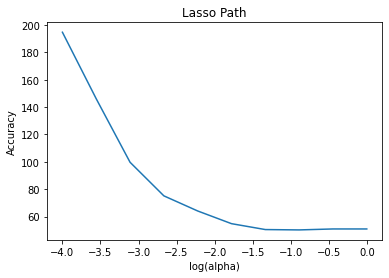

0.12915496650148828

Mean Squared Error:
Training:
7.040406580956235

Testing:
7.093925967433393

R-Squared:
Training:
0.020072093569045935

Testing:
0.004513937672349755
1
0.00018112660749864155
Finishing Regression Analysis on : weekDiff
Starting Regression Analysis on : monthDiff
(652, 5521)
(322, 5521)


/home/abromeland/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 313.2941243982641, tolerance: 10.853052156936686
  model = cd_fast.sparse_enet_coordinate_descent(
/home/abromeland/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1669.3662646300363, tolerance: 10.853052156936686
  model = cd_fast.sparse_enet_coordinate_descent(
/home/abromeland/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.482086408177565, tolerance: 10.199615428976818
  model = cd_fast.sparse_enet_coordinate_descent(
/home/abromeland/.local/lib/python3.9/site-packages/skle

(652, 5521)
[1.00000000e+00 3.59381366e-01 1.29154967e-01 4.64158883e-02
 1.66810054e-02 5.99484250e-03 2.15443469e-03 7.74263683e-04
 2.78255940e-04 1.00000000e-04]


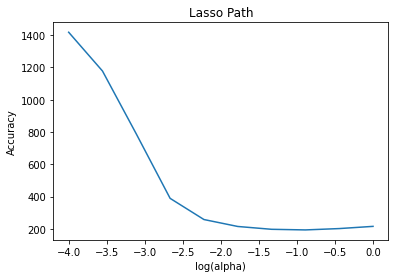

0.12915496650148828

Mean Squared Error:
Training:
13.307793059099463

Testing:
14.484755161572139

R-Squared:
Training:
0.1841281282607654

Testing:
0.06530827815814966
22
0.003984785364970114
Finishing Regression Analysis on : monthDiff
Starting Regression Analysis on : dayPCT
(652, 5521)
(322, 5521)


/home/abromeland/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000464189838861772, tolerance: 1.5837850986112213e-05
  model = cd_fast.sparse_enet_coordinate_descent(
/home/abromeland/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007797896502791182, tolerance: 1.5837850986112213e-05
  model = cd_fast.sparse_enet_coordinate_descent(
/home/abromeland/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014880616125409162, tolerance: 1.5837850986112213e-05
  model = cd_fast.sparse_enet_coordinate_descent(
/home/abromeland/.local/lib/python3

/home/abromeland/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010521207257945878, tolerance: 1.555047709629222e-05
  model = cd_fast.sparse_enet_coordinate_descent(
/home/abromeland/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001216888452000492, tolerance: 1.555047709629222e-05
  model = cd_fast.sparse_enet_coordinate_descent(
/home/abromeland/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010036570461941091, tolerance: 1.555047709629222e-05
  model = cd_fast.sparse_enet_coordinate_descent(
/home/abromeland/.local/lib/python3.9/

(652, 5521)
[1.00000000e+00 2.97635144e-01 8.85866790e-02 2.63665090e-02
 7.84759970e-03 2.33572147e-03 6.95192796e-04 2.06913808e-04
 6.15848211e-05 1.83298071e-05 5.45559478e-06 1.62377674e-06
 4.83293024e-07 1.43844989e-07 4.28133240e-08 1.27427499e-08
 3.79269019e-09 1.12883789e-09 3.35981829e-10 1.00000000e-10]


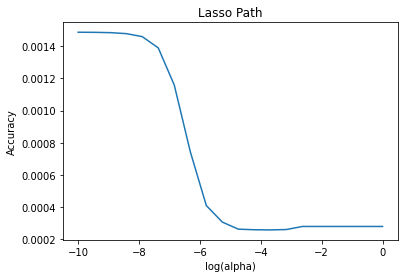

0.00020691380811147902

Mean Squared Error:
Training:
0.015236888787862328

Testing:
0.018651758232769683

R-Squared:
Training:
0.17134003205769455

Testing:
0.07936220714529418
15
0.0027168991124796233
Finishing Regression Analysis on : dayPCT
Starting Regression Analysis on : weekPCT
(652, 5521)
(322, 5521)


/home/abromeland/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016160983459911904, tolerance: 9.532249939128454e-05
  model = cd_fast.sparse_enet_coordinate_descent(
/home/abromeland/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007902912821511843, tolerance: 9.532249939128454e-05
  model = cd_fast.sparse_enet_coordinate_descent(
/home/abromeland/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017866491928369754, tolerance: 9.532249939128454e-05
  model = cd_fast.sparse_enet_coordinate_descent(
/home/abromeland/.local/lib/python3.9/

/home/abromeland/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009413002266090376, tolerance: 8.884277129381923e-05
  model = cd_fast.sparse_enet_coordinate_descent(
/home/abromeland/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01737501011814291, tolerance: 8.884277129381923e-05
  model = cd_fast.sparse_enet_coordinate_descent(
/home/abromeland/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.020449762025662566, tolerance: 8.884277129381923e-05
  model = cd_fast.sparse_enet_coordinate_descent(
/home/abromeland/.local/lib/python3.9/sit

(652, 5521)
[1.00000000e+00 2.97635144e-01 8.85866790e-02 2.63665090e-02
 7.84759970e-03 2.33572147e-03 6.95192796e-04 2.06913808e-04
 6.15848211e-05 1.83298071e-05 5.45559478e-06 1.62377674e-06
 4.83293024e-07 1.43844989e-07 4.28133240e-08 1.27427499e-08
 3.79269019e-09 1.12883789e-09 3.35981829e-10 1.00000000e-10]


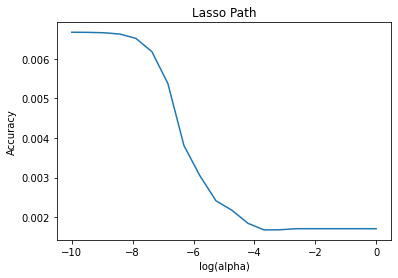

0.00020691380811147902

Mean Squared Error:
Training:
0.038180543297778834

Testing:
0.03925645122880576

R-Squared:
Training:
0.14123884723839109

Testing:
0.011744310661909951
39
0.007063937692447021
Finishing Regression Analysis on : weekPCT
Starting Regression Analysis on : monthPCT
(652, 5521)
(322, 5521)


/home/abromeland/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.020798196057287388, tolerance: 0.0002997286643507942
  model = cd_fast.sparse_enet_coordinate_descent(
/home/abromeland/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04366980273842458, tolerance: 0.0002997286643507942
  model = cd_fast.sparse_enet_coordinate_descent(
/home/abromeland/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.037113631291555205, tolerance: 0.0002997286643507942
  model = cd_fast.sparse_enet_coordinate_descent(
/home/abromeland/.local/lib/python3.9/sit

/home/abromeland/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06908244111162143, tolerance: 0.00030646068350008156
  model = cd_fast.sparse_enet_coordinate_descent(
/home/abromeland/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006583603046181885, tolerance: 0.0003189332898832475
  model = cd_fast.sparse_enet_coordinate_descent(
/home/abromeland/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012583941692908662, tolerance: 0.0003189332898832475
  model = cd_fast.sparse_enet_coordinate_descent(
/home/abromeland/.local/lib/python3.9/s

(652, 5521)
[1.00000000e+00 2.97635144e-01 8.85866790e-02 2.63665090e-02
 7.84759970e-03 2.33572147e-03 6.95192796e-04 2.06913808e-04
 6.15848211e-05 1.83298071e-05 5.45559478e-06 1.62377674e-06
 4.83293024e-07 1.43844989e-07 4.28133240e-08 1.27427499e-08
 3.79269019e-09 1.12883789e-09 3.35981829e-10 1.00000000e-10]


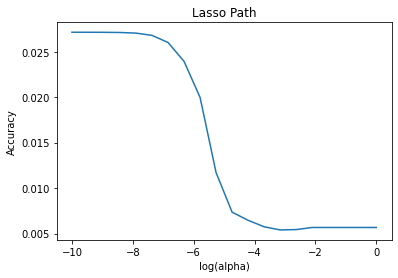

0.0006951927961775605

Mean Squared Error:
Training:
0.07048178170948698

Testing:
0.07061143921750357

R-Squared:
Training:
0.12127300323177981

Testing:
0.07619533218305952
17
0.003079152327476906
Finishing Regression Analysis on : monthPCT


In [21]:
stockReturns = ['Adj Close','dayDiff','weekDiff','monthDiff','dayPCT','weekPCT','monthPCT']
measures = []
regTrainShape = []
regTestShape = []
msePathAll = []
bestalphaAll = []
trainMSE = []
testMSE = []
trainR2 = []
testR2 = []
nonzeroCoef = []
nonzeroCoefPCT = []
dfBetaAll = []

for sreturn in stockReturns:
    
    print(f'Starting Regression Analysis on : {sreturn}')
    
    # Generate Data Set 
    df = df_all[["text",sreturn]].copy()

    # Create Training/Testing Split
    df_train, df_test = train_test_split(df, test_size=0.33, random_state=2021)
    df_train.reset_index(drop=True,inplace=True)
    df_test.reset_index(drop=True,inplace=True)

    # Tokenize the data in training set
    lm = ps.LM()
    vectorizer = TfidfVectorizer(tokenizer = lm.tokenize,stop_words=custom_stop_words)
    #Create the training DTM and the labels
    train_x = vectorizer.fit_transform(df_train["text"])
    train_y = df_train[sreturn]
    print(train_x.shape)

    #Create the testing DTM and the labels
    test_x = vectorizer.transform(df_test["text"])
    test_y = df_test[sreturn]
    print(test_x.shape)
    
    scaler = MaxAbsScaler()
    scaler.fit(train_x)
    train_x=scaler.transform(train_x)
    test_x=scaler.transform(test_x)


    # Create List of alphas
    if sreturn in ['dayPCT','weekPCT','monthPCT']:
        alphaList = np.logspace(start=-10,stop=0,num=20)
    else:
        alphaList = np.logspace(start=-4,stop=0,num=10)
    
    
    # Create Model
    lasso = LassoCV(alphas=alphaList,  
                   cv=5,       #Number of folds, i.e., K
                   max_iter=75000)
    
    # Fit Model
    lasso.fit(train_x, train_y)
    
    msePath = pd.DataFrame(lasso.mse_path_)
    
    
    print(train_x.shape)
    print(lasso.alphas_)
    %matplotlib inline
    plt.plot(np.log10(lasso.alphas_), lasso.mse_path_.mean(axis=1))
    plt.xlabel('log(alpha)')
    plt.ylabel('Accuracy')
    plt.title('Lasso Path')
    plt.axis('tight')
    plt.show()
    bestalpha=lasso.alpha_
    print(bestalpha)
    print()
    print("Mean Squared Error:")
    print("Training:")
    print(mean_squared_error(train_y,lasso.predict(train_x),squared=False))
    print()
    print("Testing:")
    print(mean_squared_error(test_y,lasso.predict(test_x),squared=False))
    print()
    print("R-Squared:")
    print("Training:")
    print(r2_score(train_y,lasso.predict(train_x)))
    print()
    print("Testing:")
    print(r2_score(test_y,lasso.predict(test_x)))
    print(np.count_nonzero(lasso.coef_))
    #Check the percentage of non-zero slopes
    print(np.count_nonzero(lasso.coef_)/len(lasso.coef_))

    dfbeta = pd.DataFrame({'Term': vectorizer.get_feature_names_out(),
                       'Beta': lasso.coef_
                     })
    measures.append(sreturn)
    regTrainShape.append(train_x.shape)
    regTestShape.append(test_x.shape)
    msePathAll.append(msePath)
    bestalphaAll.append(bestalpha)
    trainMSE.append(mean_squared_error(train_y,lasso.predict(train_x),squared=False))
    testMSE.append(mean_squared_error(test_y,lasso.predict(test_x),squared=False))
    trainR2.append(r2_score(train_y,lasso.predict(train_x)))
    testR2.append(r2_score(test_y,lasso.predict(test_x)))
    nonzeroCoef.append(np.count_nonzero(lasso.coef_))
    nonzeroCoefPCT.append(np.count_nonzero(lasso.coef_)/len(lasso.coef_))
    dfBetaAll.append(dfbeta)
    print(f'Finishing Regression Analysis on : {sreturn}')

In [22]:
regresults = pd.DataFrame({'Prediction': measures,
                           'Training Shape': regTrainShape,
                           'Testing Shape': regTestShape,
                           'Best Alpha':bestalphaAll,
                           'Training MSE':trainMSE,
                           'Testing MSE':testMSE,
                           'Train R2': trainR2,
                           'Test R2':testR2,
                           'NonZero Coef':nonzeroCoef,
                           'NonZero Coef PCT':nonzeroCoefPCT})
regresults.sort_values(by='Test R2',ascending=False,inplace=True)
regresults

,Prediction,Training Shape,Testing Shape,Best Alpha,Training MSE,Testing MSE,Train R2,Test R2,NonZero Coef,NonZero Coef PCT
0,Adj Close,"(652, 5521)","(322, 5521)",0.046416,38.817124,72.462260,0.809776,0.350104,239,0.043289
4,dayPCT,"(652, 5521)","(322, 5521)",0.000207,0.015237,0.018652,0.171340,0.079362,15,0.002717
6,monthPCT,"(652, 5521)","(322, 5521)",0.000695,0.070482,0.070611,0.121273,0.076195,17,0.003079
3,monthDiff,"(652, 5521)","(322, 5521)",0.129155,13.307793,14.484755,0.184128,0.065308,22,0.003985
5,weekPCT,"(652, 5521)","(322, 5521)",0.000207,0.038181,0.039256,0.141239,0.011744,39,0.007064
2,weekDiff,"(652, 5521)","(322, 5521)",0.129155,7.040407,7.093926,0.020072,0.004514,1,0.000181
1,dayDiff,"(652, 5521)","(322, 5521)",0.005995,2.144052,3.554892,0.562933,-0.034492,157,0.028437


In [23]:
regresults.to_csv("Regression_Results.csv")

In [31]:
stockReturns = ['Adj Close','dayPCT','weekPCT','monthPCT']
measures = []
regTrainShape = []
regTestShape = []
msePathAll = []
bestalphaAll = []
trainMSE = []
testMSE = []
trainR2 = []
testR2 = []
nonzeroCoef = []
nonzeroCoefPCT = []
dfBetaAll = []

for sreturn in stockReturns:
    
    print(f'Starting Regression Analysis on : {sreturn}')
    
    # Generate Data Set 
    df = df_all[["text",sreturn]].copy()

    # Create Training/Testing Split
    df_train, df_test = train_test_split(df, test_size=0.33, random_state=2021)
    df_train.reset_index(drop=True,inplace=True)
    df_test.reset_index(drop=True,inplace=True)

    # Tokenize the data in training set
    lm = ps.LM()
    vectorizer = CountVectorizer(tokenizer = lm.tokenize,
                                             stop_words=custom_stop_words,
                                             ngram_range =(2,2),
                                             binary=True)
    #Create the training DTM and the labels
    train_x = vectorizer.fit_transform(df_train["text"])
    train_y = df_train[sreturn]
    print(train_x.shape)

    #Create the testing DTM and the labels
    test_x = vectorizer.transform(df_test["text"])
    test_y = df_test[sreturn]
    print(test_x.shape)
    
    scaler = MaxAbsScaler()
    scaler.fit(train_x)
    train_x=scaler.transform(train_x)
    test_x=scaler.transform(test_x)


    # Create List of alphas
    if sreturn == 'Adj Close':
        bestAlpha = 0.046416
    elif sreturn == 'dayPCT':
        bestAlpha = 0.000207
    elif sreturn == 'weekPCT':
        bestAlpha = 0.000207
    elif sreturn == 'monthPCT':
        bestAlpha = 0.000695
        
    
    
    lasso = Lasso(alpha=bestAlpha, #Regularization parameter.
              max_iter=75000
              )
    lasso.fit(train_x,train_y)
    

    print()
    print("Mean Squared Error:")
    print("Training:")
    print(mean_squared_error(train_y,lasso.predict(train_x),squared=False))
    print()
    print("Testing:")
    print(mean_squared_error(test_y,lasso.predict(test_x),squared=False))
    print()
    print("R-Squared:")
    print("Training:")
    print(r2_score(train_y,lasso.predict(train_x)))
    print()
    print("Testing:")
    print(r2_score(test_y,lasso.predict(test_x)))
    print(np.count_nonzero(lasso.coef_))
    #Check the percentage of non-zero slopes
    print(np.count_nonzero(lasso.coef_)/len(lasso.coef_))

    dfbeta = pd.DataFrame({'Term': vectorizer.get_feature_names_out(),
                       'Beta': lasso.coef_
                     })
    measures.append(sreturn)
    regTrainShape.append(train_x.shape)
    regTestShape.append(test_x.shape)
    trainMSE.append(mean_squared_error(train_y,lasso.predict(train_x),squared=False))
    testMSE.append(mean_squared_error(test_y,lasso.predict(test_x),squared=False))
    trainR2.append(r2_score(train_y,lasso.predict(train_x)))
    testR2.append(r2_score(test_y,lasso.predict(test_x)))
    nonzeroCoef.append(np.count_nonzero(lasso.coef_))
    nonzeroCoefPCT.append(np.count_nonzero(lasso.coef_)/len(lasso.coef_))
    dfBetaAll.append(dfbeta)
    print(f'Finishing Regression Analysis on : {sreturn}')

Starting Regression Analysis on : Adj Close
(652, 69176)
(322, 69176)

Mean Squared Error:
Training:
31.845219983939838

Testing:
53.568830059311374

R-Squared:
Training:
0.8719713752157182

Testing:
0.6448230953441864
296
0.004278940673065803
Finishing Regression Analysis on : Adj Close
Starting Regression Analysis on : dayPCT
(652, 69176)
(322, 69176)

Mean Squared Error:
Training:
0.014388828372401201

Testing:
0.018330470939272862

R-Squared:
Training:
0.26101669276060224

Testing:
0.11080606901578383
35
0.0005059558228287267
Finishing Regression Analysis on : dayPCT
Starting Regression Analysis on : weekPCT
(652, 69176)
(322, 69176)

Mean Squared Error:
Training:
0.03666324481612314

Testing:
0.03934359137095401

R-Squared:
Training:
0.20813712943375284

Testing:
0.007352048087821084
95
0.0013733086619636867
Finishing Regression Analysis on : weekPCT
Starting Regression Analysis on : monthPCT
(652, 69176)
(322, 69176)

Mean Squared Error:
Training:
0.06607592970748279

Testing:
0.

In [32]:
regresults_new = pd.DataFrame({'Prediction': measures,
                           'Training Shape': regTrainShape,
                           'Testing Shape': regTestShape,
                           'Training MSE':trainMSE,
                           'Testing MSE':testMSE,
                           'Train R2': trainR2,
                           'Test R2':testR2,
                           'NonZero Coef':nonzeroCoef,
                           'NonZero Coef PCT':nonzeroCoefPCT})
regresults_new.sort_values(by='Test R2',ascending=False,inplace=True)
regresults_new

,Prediction,Training Shape,Testing Shape,Training MSE,Testing MSE,Train R2,Test R2,NonZero Coef,NonZero Coef PCT
0,Adj Close,"(652, 69176)","(322, 69176)",31.845220,53.568830,0.871971,0.644823,296,0.004279
1,dayPCT,"(652, 69176)","(322, 69176)",0.014389,0.018330,0.261017,0.110806,35,0.000506
3,monthPCT,"(652, 69176)","(322, 69176)",0.066076,0.070424,0.227699,0.081099,61,0.000882
2,weekPCT,"(652, 69176)","(322, 69176)",0.036663,0.039344,0.208137,0.007352,95,0.001373


In [33]:
regresults_new.to_csv("Regression_Binary_Bigrams.csv")

### Logistic Regression - K-fold cross Validation
    - Used different predictor columns, vectorizers, and N-grams
    - Then printed results by predictor columns.
    - Only trying to predict if the differences were positive.

In [24]:
columns = ['dayDiff','weekDiff','monthDiff']
scorer = ['TF','Binary','NormTfidf','UnnormalizedTfidf']
ngrams = [1,2,3]
lm = ps.LM()
measures = []
vector = []
grams = []
trainAcc = []
testAcc = []
trainROC = []
testROC = []
cCandidate = []
trainTestSplit = []
trainShape = []
testShape = []

for column in columns:
    for score in scorer:
        for ngram in ngrams:
            if score == 'TF':
                vectorizer = CountVectorizer(tokenizer = lm.tokenize,
                                             stop_words=custom_stop_words,
                                             ngram_range =(ngram,ngram),
                                             binary=False)
            elif score == 'Binary':
                vectorizer = CountVectorizer(tokenizer = lm.tokenize,
                                             stop_words=custom_stop_words,
                                             ngram_range =(ngram,ngram),
                                             binary=True)
            elif score == 'NormTfidf':
                vectorizer = TfidfVectorizer(tokenizer = lm.tokenize,
                                             stop_words=custom_stop_words,
                                             norm = 'l1',
                                             ngram_range = (ngram,ngram),
                                             binary=False)
            elif score == 'UnnormalizedTfidf':
                vectorizer = TfidfVectorizer(tokenizer = lm.tokenize,
                                             stop_words=custom_stop_words,
                                             norm = None,
                                             ngram_range = (ngram,ngram),
                                             binary=False)
            
            print(f"Starting: Measure - {column}, Scorer - {score}, N-Grams - {ngram}")
            df = df_all[["text",column]].copy()
            df[column] = np.where(df[column]> 0 ,'postive','negative')
            df_train, df_test = train_test_split(df, test_size=0.33, random_state=2021)
            df_train.reset_index(drop=True,inplace=True)
            df_test.reset_index(drop=True,inplace=True)

            #Create the training DTM and the labels
            train_x = vectorizer.fit_transform(df_train["text"])
            train_y = df_train[column]
            print(train_x.shape)

            #Create the testing DTM and the labels
            test_x = vectorizer.transform(df_test["text"])
            test_y = df_test[column]
            print(test_x.shape)

            splits = pd.DataFrame({'Train': train_y.value_counts(),
                      'Test': test_y.value_counts()})
            print(splits)

            param_grid = l1_min_c(train_x, train_y, loss='log') * np.logspace(start=0, stop=5, num=20) 
            print(param_grid)

            sparselr = LogisticRegressionCV(penalty='l1', 
                                        solver='liblinear', 
                                        Cs=param_grid,   #Use the grid generated above
                                        cv=5,            #Number of folds, that is, K
                                        scoring='accuracy', #The performance metric to select the best C.
                                        random_state=2021,  #To make sure the result is reproducible
                                        tol=0.001,
                                        max_iter=1000)
            sparselr.fit(train_x, train_y)

            #All candicates
            print("All candicates")
            print(sparselr.Cs)
            print("best value of C among Candidates")
            print(sparselr.C_)


            print("Train Accuracy:")
            print(accuracy_score(train_y,sparselr.predict(train_x)))
            print("Test Accuracy:")
            print(accuracy_score(test_y,sparselr.predict(test_x)))
            print("Train AUC:")
            print(roc_auc_score(train_y,sparselr.predict_proba(train_x)[:, 1]))
            print("Test AUC:")
            print(roc_auc_score(test_y,sparselr.predict_proba(test_x)[:, 1]))
            
            measures.append(column)
            vector.append(score)
            grams.append(ngram)
            trainAcc.append(accuracy_score(train_y,sparselr.predict(train_x)))
            testAcc.append(accuracy_score(test_y,sparselr.predict(test_x)))
            trainROC.append(roc_auc_score(train_y,sparselr.predict_proba(train_x)[:, 1]))
            testROC.append(roc_auc_score(test_y,sparselr.predict_proba(test_x)[:, 1]))
            cCandidate.append(sparselr.C_)
            trainTestSplit.append(splits)
            trainShape.append(train_x.shape)
            testShape.append(test_x.shape)
            
            print(f"Finishing: Measure - {column}, Scorer - {score}, N-Grams - {ngram}")

Starting: Measure - dayDiff, Scorer - TF, N-Grams - 1
(652, 5521)
(322, 5521)
          Train  Test
postive     367   181
negative    285   141
[2.79056788e-04 5.11505710e-04 9.37580099e-04 1.71856624e-03
 3.15009876e-03 5.77407027e-03 1.05837594e-02 1.93998269e-02
 3.55595085e-02 6.51798931e-02 1.19473487e-01 2.18992597e-01
 4.01409206e-01 7.35775331e-01 1.34866199e+00 2.47207141e+00
 4.53125921e+00 8.30571073e+00 1.52242076e+01 2.79056788e+01]


/home/abromeland/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/abromeland/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


All candicates
[2.79056788e-04 5.11505710e-04 9.37580099e-04 1.71856624e-03
 3.15009876e-03 5.77407027e-03 1.05837594e-02 1.93998269e-02
 3.55595085e-02 6.51798931e-02 1.19473487e-01 2.18992597e-01
 4.01409206e-01 7.35775331e-01 1.34866199e+00 2.47207141e+00
 4.53125921e+00 8.30571073e+00 1.52242076e+01 2.79056788e+01]
best value of C among Candidates
[8.30571073]
Train Accuracy:
0.8266871165644172
Test Accuracy:
0.562111801242236
Train AUC:
0.9124623547970745
Test AUC:
0.5802280474903021
Finishing: Measure - dayDiff, Scorer - TF, N-Grams - 1
Starting: Measure - dayDiff, Scorer - TF, N-Grams - 2
(652, 69176)
(322, 69176)
          Train  Test
postive     367   181
negative    285   141
[7.53579503e-04 1.38129669e-03 2.53189019e-03 4.64090589e-03
 8.50669097e-03 1.55926005e-02 2.85809359e-02 5.23883042e-02
 9.60267510e-02 1.76015182e-01 3.22632434e-01 5.91379028e-01
 1.08398635e+00 1.98692607e+00 3.64199717e+00 6.67571055e+00
 1.22364487e+01 2.24291744e+01 4.11122440e+01 7.53579503e+01]

(652, 5521)
(322, 5521)
          Train  Test
postive     367   181
negative    285   141
[1.53777540e-04 2.81871265e-04 5.16664592e-04 9.47036230e-04
 1.73589914e-03 3.18186964e-03 5.83230568e-03 1.06905038e-02
 1.95954873e-02 3.59181502e-02 6.58372765e-02 1.20678458e-01
 2.21201286e-01 4.05457690e-01 7.43196124e-01 1.36226416e+00
 2.49700393e+00 4.57696003e+00 8.38947946e+00 1.53777540e+01]


/home/abromeland/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/abromeland/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


All candicates
[1.53777540e-04 2.81871265e-04 5.16664592e-04 9.47036230e-04
 1.73589914e-03 3.18186964e-03 5.83230568e-03 1.06905038e-02
 1.95954873e-02 3.59181502e-02 6.58372765e-02 1.20678458e-01
 2.21201286e-01 4.05457690e-01 7.43196124e-01 1.36226416e+00
 2.49700393e+00 4.57696003e+00 8.38947946e+00 1.53777540e+01]
best value of C among Candidates
[0.40545769]
Train Accuracy:
0.8021472392638037
Test Accuracy:
0.5590062111801242
Train AUC:
0.877412878244658
Test AUC:
0.5794835625563262
Finishing: Measure - dayDiff, Scorer - UnnormalizedTfidf, N-Grams - 1
Starting: Measure - dayDiff, Scorer - UnnormalizedTfidf, N-Grams - 2
(652, 69176)
(322, 69176)
          Train  Test
postive     367   181
negative    285   141
[2.03814045e-04 3.73587214e-04 6.84778157e-04 1.25518515e-03
 2.30073017e-03 4.21719403e-03 7.73003531e-03 1.41690056e-02
 2.59715140e-02 4.76052841e-02 8.72595676e-02 1.59945104e-01
 2.93176291e-01 5.37386486e-01 9.85019063e-01 1.80552094e+00
 3.30948506e+00 6.06622228e+00 

(652, 5521)
(322, 5521)
          Train  Test
postive     382   195
negative    270   127
[1.78571429e-02 3.27317984e-02 5.99967551e-02 1.09972895e-01
 2.01578195e-01 3.69488943e-01 6.77266105e-01 1.24141571e+00
 2.27549105e+00 4.17093119e+00 7.64523643e+00 1.40135709e+01
 2.56866051e+01 4.70830518e+01 8.63023257e+01 1.58190498e+02
 2.89960132e+02 5.31491329e+02 9.74213354e+02 1.78571429e+03]
All candicates
[1.78571429e-02 3.27317984e-02 5.99967551e-02 1.09972895e-01
 2.01578195e-01 3.69488943e-01 6.77266105e-01 1.24141571e+00
 2.27549105e+00 4.17093119e+00 7.64523643e+00 1.40135709e+01
 2.56866051e+01 4.70830518e+01 8.63023257e+01 1.58190498e+02
 2.89960132e+02 5.31491329e+02 9.74213354e+02 1.78571429e+03]
best value of C among Candidates
[25.68660515]
Train Accuracy:
0.6625766871165644
Test Accuracy:
0.6459627329192547
Train AUC:
0.7264397905759161
Test AUC:
0.7004643650312942
Finishing: Measure - weekDiff, Scorer - NormTfidf, N-Grams - 1
Starting: Measure - weekDiff, Scorer - NormTf

/home/abromeland/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


All candicates
[1.89689254e-04 3.47696744e-04 6.37321426e-04 1.16819788e-03
 2.14128418e-03 3.92493260e-03 7.19432575e-03 1.31870603e-02
 2.41716272e-02 4.43061264e-02 8.12122751e-02 1.48860534e-01
 2.72858487e-01 5.00144343e-01 9.16754934e-01 1.68039411e+00
 3.08012999e+00 5.64581886e+00 1.03486771e+01 1.89689254e+01]
best value of C among Candidates
[0.08121228]
Train Accuracy:
0.6947852760736196
Test Accuracy:
0.6459627329192547
Train AUC:
0.7887434554973821
Test AUC:
0.683928931960428
Finishing: Measure - weekDiff, Scorer - UnnormalizedTfidf, N-Grams - 1
Starting: Measure - weekDiff, Scorer - UnnormalizedTfidf, N-Grams - 2
(652, 69176)
(322, 69176)
          Train  Test
postive     382   195
negative    270   127
[4.32737981e-04 7.93200372e-04 1.45392098e-03 2.66500912e-03
 4.88491030e-03 8.95394636e-03 1.64124110e-02 3.00836327e-02
 5.51427185e-02 1.01075539e-01 1.85269514e-01 3.39595445e-01
 6.22471901e-01 1.14097899e+00 2.09139247e+00 3.83348206e+00
 7.02669868e+00 1.28798031e+0

(652, 5521)
(322, 5521)
          Train  Test
postive     417   207
negative    235   115
[1.09890110e-02 2.01426452e-02 3.69210801e-02 6.76756276e-02
 1.24048120e-01 2.27377811e-01 4.16779142e-01 7.63948128e-01
 1.40030218e+00 2.56672689e+00 4.70476088e+00 8.62373594e+00
 1.58071416e+01 2.89741857e+01 5.31091235e+01 9.73479989e+01
 1.78437004e+02 3.27071587e+02 5.99515910e+02 1.09890110e+03]
All candicates
[1.09890110e-02 2.01426452e-02 3.69210801e-02 6.76756276e-02
 1.24048120e-01 2.27377811e-01 4.16779142e-01 7.63948128e-01
 1.40030218e+00 2.56672689e+00 4.70476088e+00 8.62373594e+00
 1.58071416e+01 2.89741857e+01 5.31091235e+01 9.73479989e+01
 1.78437004e+02 3.27071587e+02 5.99515910e+02 1.09890110e+03]
best value of C among Candidates
[599.51591002]
Train Accuracy:
0.8266871165644172
Test Accuracy:
0.6304347826086957
Train AUC:
0.9131231185264554
Test AUC:
0.6426170972484772
Finishing: Measure - monthDiff, Scorer - NormTfidf, N-Grams - 1
Starting: Measure - monthDiff, Scorer - Nor

In [25]:
results = pd.DataFrame({'Prediction': measures,
                        'Vectorizer': vector,
                        'N-Grams': grams,
                        'Training Accuracy': trainAcc,
                        'Testing Accuracy': testAcc,
                        'Training ROC': trainROC,
                        'Testing ROC': testROC,
                        'C Candidate': cCandidate,
                        'trainShape': trainShape,
                        'testShape': testShape})
results.sort_values(by='Testing ROC',ascending=False,inplace=True)
results

,Prediction,Vectorizer,N-Grams,Training Accuracy,Testing Accuracy,Training ROC,Testing ROC,C Candidate,trainShape,testShape
16,weekDiff,Binary,2,0.742331,0.642857,0.820574,0.703937,[0.6374269228121427],"(652, 69176)","(322, 69176)"
17,weekDiff,Binary,3,0.694785,0.642857,0.758009,0.701898,[0.35985010106344156],"(652, 124524)","(322, 124524)"
12,weekDiff,TF,1,0.680982,0.645963,0.758590,0.701514,[0.1314703638482847],"(652, 5521)","(322, 5521)"
18,weekDiff,NormTfidf,1,0.662577,0.645963,0.726440,0.700464,[25.68660514799398],"(652, 5521)","(322, 5521)"
22,weekDiff,UnnormalizedTfidf,2,0.717791,0.633540,0.808493,0.686634,[0.10107553928918586],"(652, 69176)","(322, 69176)"
19,weekDiff,NormTfidf,2,0.676380,0.627329,0.750087,0.685706,[47.08305176304211],"(652, 69176)","(322, 69176)"
21,weekDiff,UnnormalizedTfidf,1,0.694785,0.645963,0.788743,0.683929,[0.08121227506751749],"(652, 5521)","(322, 5521)"
23,weekDiff,UnnormalizedTfidf,3,0.687117,0.614907,0.784017,0.674379,[0.07646144640695914],"(652, 124524)","(322, 124524)"
14,weekDiff,TF,3,0.707055,0.611801,0.796296,0.672764,[0.41305510071414375],"(652, 124524)","(322, 124524)"
28,monthDiff,Binary,2,0.797546,0.649068,0.861876,0.670006,[0.763948127667649],"(652, 69176)","(322, 69176)"


In [26]:
results_day = results.copy()
results_day = results_day[results_day['Prediction'] == 'dayDiff']
results_day.sort_values(by='Testing ROC',ascending=False,inplace=True)
results_day.reset_index(inplace=True,drop=True)
results_day

,Prediction,Vectorizer,N-Grams,Training Accuracy,Testing Accuracy,Training ROC,Testing ROC,C Candidate,trainShape,testShape
0,dayDiff,Binary,2,0.854294,0.602484,0.935585,0.653717,[2.8635392937149065],"(652, 69176)","(322, 69176)"
1,dayDiff,UnnormalizedTfidf,2,0.866564,0.593168,0.953798,0.630931,[11.119268421138546],"(652, 69176)","(322, 69176)"
2,dayDiff,Binary,3,0.866564,0.568323,0.946226,0.629932,[3.1079877700076426],"(652, 124524)","(322, 124524)"
3,dayDiff,NormTfidf,3,0.852761,0.586957,0.944314,0.626895,[725.9393760076389],"(652, 124524)","(322, 124524)"
4,dayDiff,TF,2,0.861963,0.586957,0.942870,0.624407,[3.6419971654647716],"(652, 69176)","(322, 69176)"
5,dayDiff,UnnormalizedTfidf,3,0.874233,0.565217,0.959487,0.624309,[4.397666756488766],"(652, 124524)","(322, 124524)"
6,dayDiff,NormTfidf,2,0.846626,0.586957,0.927210,0.623134,[396.0431071192003],"(652, 69176)","(322, 69176)"
7,dayDiff,TF,3,0.868098,0.555901,0.950944,0.622546,[3.857572638961753],"(652, 124524)","(322, 124524)"
8,dayDiff,NormTfidf,1,0.776074,0.586957,0.870109,0.611496,[216.06507083172738],"(652, 5521)","(322, 5521)"
9,dayDiff,Binary,1,0.822086,0.571429,0.909542,0.599291,[5.07765536758722],"(652, 5521)","(322, 5521)"


In [27]:
results_week = results.copy()
results_week = results_week[results_week['Prediction'] == 'weekDiff']
results_week.sort_values(by='Testing ROC',ascending=False,inplace=True)
results_week.reset_index(inplace=True,drop=True)
results_week

,Prediction,Vectorizer,N-Grams,Training Accuracy,Testing Accuracy,Training ROC,Testing ROC,C Candidate,trainShape,testShape
0,weekDiff,Binary,2,0.742331,0.642857,0.820574,0.703937,[0.6374269228121427],"(652, 69176)","(322, 69176)"
1,weekDiff,Binary,3,0.694785,0.642857,0.758009,0.701898,[0.35985010106344156],"(652, 124524)","(322, 124524)"
2,weekDiff,TF,1,0.680982,0.645963,0.758590,0.701514,[0.1314703638482847],"(652, 5521)","(322, 5521)"
3,weekDiff,NormTfidf,1,0.662577,0.645963,0.726440,0.700464,[25.68660514799398],"(652, 5521)","(322, 5521)"
4,weekDiff,UnnormalizedTfidf,2,0.717791,0.633540,0.808493,0.686634,[0.10107553928918586],"(652, 69176)","(322, 69176)"
5,weekDiff,NormTfidf,2,0.676380,0.627329,0.750087,0.685706,[47.08305176304211],"(652, 69176)","(322, 69176)"
6,weekDiff,UnnormalizedTfidf,1,0.694785,0.645963,0.788743,0.683929,[0.08121227506751749],"(652, 5521)","(322, 5521)"
7,weekDiff,UnnormalizedTfidf,3,0.687117,0.614907,0.784017,0.674379,[0.07646144640695914],"(652, 124524)","(322, 124524)"
8,weekDiff,TF,3,0.707055,0.611801,0.796296,0.672764,[0.41305510071414375],"(652, 124524)","(322, 124524)"
9,weekDiff,NormTfidf,3,0.667178,0.642857,0.729150,0.662326,[47.08305176304211],"(652, 124524)","(322, 124524)"


In [28]:
results_month = results.copy()
results_month = results_month[results_month['Prediction'] == 'monthDiff']
results_month.sort_values(by='Testing ROC',ascending=False,inplace=True)
results_month.reset_index(inplace=True,drop=True)
results_month

,Prediction,Vectorizer,N-Grams,Training Accuracy,Testing Accuracy,Training ROC,Testing ROC,C Candidate,trainShape,testShape
0,monthDiff,Binary,2,0.797546,0.649068,0.861876,0.670006,[0.763948127667649],"(652, 69176)","(322, 69176)"
1,monthDiff,Binary,3,0.825153,0.633540,0.903699,0.666583,[1.4003021820913555],"(652, 124524)","(322, 124524)"
2,monthDiff,TF,3,0.838957,0.627329,0.916419,0.652972,[1.6163954075210312],"(652, 124524)","(322, 124524)"
3,monthDiff,UnnormalizedTfidf,3,0.854294,0.636646,0.917899,0.649485,[0.29921414990625295],"(652, 124524)","(322, 124524)"
4,monthDiff,TF,2,0.822086,0.614907,0.907439,0.645705,[1.504654694861572],"(652, 69176)","(322, 69176)"
5,monthDiff,NormTfidf,1,0.826687,0.630435,0.913123,0.642617,[599.5159100185182],"(652, 5521)","(322, 5521)"
6,monthDiff,UnnormalizedTfidf,2,0.814417,0.618012,0.889454,0.633228,[0.22201585067978657],"(652, 69176)","(322, 69176)"
7,monthDiff,NormTfidf,2,0.797546,0.633540,0.878249,0.626549,[178.43700430645288],"(652, 69176)","(322, 69176)"
8,monthDiff,UnnormalizedTfidf,1,0.809816,0.639752,0.894755,0.624029,[0.5843639230708159],"(652, 5521)","(322, 5521)"
9,monthDiff,NormTfidf,3,0.800613,0.642857,0.875739,0.615060,[178.43700430645288],"(652, 124524)","(322, 124524)"


In [29]:
results.to_csv("Logistic_Regression_Model.csv")

### Pull in Catapillar Data and Apply Lasso and Logistic Regression Models
    - Testing if models developed for Deere and Company can be applied to other companies within the same industry

In [34]:
# Request Data from Edgar Search. Pulled by Company CIK number
data = requests.get('https://data.sec.gov/submissions/CIK0000018230.json',headers={'User-Agent':'University of Iowa abromeland@uiowa.edu'})
data = json.loads(data.content)['filings']['recent']
df = pd.DataFrame.from_dict(data)
df.sort_values(by='filingDate',ascending=False,inplace=True)
df.reset_index(inplace=True,drop=True)
df.head()

,accessionNumber,filingDate,reportDate,acceptanceDateTime,act,form,fileNumber,filmNumber,items,size,isXBRL,isInlineXBRL,primaryDocument,primaryDocDescription
0,0000018230-22-000175,2022-07-28,2022-07-26,2022-07-28T11:12:12.000Z,,4,,,,6413,0,0,xslF345X03/wf-form4_165902111422635.xml,FORM 4
1,0000018230-22-000174,2022-07-28,2022-07-26,2022-07-28T11:11:50.000Z,,4,,,,6368,0,0,xslF345X03/wf-form4_165902107974162.xml,FORM 4
2,0000018230-22-000169,2022-07-01,2022-06-30,2022-07-01T08:53:25.000Z,,4,,,,5874,0,0,xslF345X03/wf-form4_165667999134195.xml,FORM 4
3,0000018230-22-000168,2022-07-01,2022-06-30,2022-07-01T08:53:00.000Z,,4,,,,5772,0,0,xslF345X03/wf-form4_165667996578027.xml,FORM 4
4,0000018230-22-000165,2022-06-27,2022-06-24,2022-06-27T20:50:06.000Z,,4,,,,6413,0,0,xslF345X03/wf-form4_165637739228578.xml,FORM 4


In [35]:
# Pull data by accessionNumber and FileName to be added to the dataframe
for i in range(len(df)):
    accessionNumber = df.loc[i,"accessionNumber"]
    filename = df.loc[i,'primaryDocument']
    URL = f'https://www.sec.gov/Archives/edgar/data/18230/{re.sub("-","",accessionNumber)}/{filename}'
    page = requests.get(URL,headers={'User-Agent':'University of Iowa abromeland@uiowa.edu'})
    if df.loc[i,'form'] == 'UPLOAD':
        with open('/tmp/metadata.pdf','wb') as fd:
            fd.write(page.content)
        fd.close()

        pdfFileObj = open('/tmp/metadata.pdf', 'rb') 
        pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
        text = [pdfReader.getPage(i).extractText() for i in range(pdfReader.numPages)]
        df.loc[i,'text'] = ' '.join(text)
        pdfFileObj.close()
    else:
        root = html.fromstring(page.content)
        text = [s.text_content() for s in root.xpath('/html/body')]
        df.loc[i,'text'] = ' '.join(text)
        
    time.sleep(.25)
df

,accessionNumber,filingDate,reportDate,acceptanceDateTime,act,form,fileNumber,filmNumber,items,size,isXBRL,isInlineXBRL,primaryDocument,primaryDocDescription,text
0,0000018230-22-000175,2022-07-28,2022-07-26,2022-07-28T11:12:12.000Z,,4,,,,6413,0,0,xslF345X03/wf-form4_165902111422635.xml,FORM 4,SEC Form 4 \n \n\nFORM 4\n\nUNITED STATES SE...
1,0000018230-22-000174,2022-07-28,2022-07-26,2022-07-28T11:11:50.000Z,,4,,,,6368,0,0,xslF345X03/wf-form4_165902107974162.xml,FORM 4,SEC Form 4 \n \n\nFORM 4\n\nUNITED STATES SE...
2,0000018230-22-000169,2022-07-01,2022-06-30,2022-07-01T08:53:25.000Z,,4,,,,5874,0,0,xslF345X03/wf-form4_165667999134195.xml,FORM 4,SEC Form 4 \n \n\nFORM 4\n\nUNITED STATES SE...
3,0000018230-22-000168,2022-07-01,2022-06-30,2022-07-01T08:53:00.000Z,,4,,,,5772,0,0,xslF345X03/wf-form4_165667996578027.xml,FORM 4,SEC Form 4 \n \n\nFORM 4\n\nUNITED STATES SE...
4,0000018230-22-000165,2022-06-27,2022-06-24,2022-06-27T20:50:06.000Z,,4,,,,6413,0,0,xslF345X03/wf-form4_165637739228578.xml,FORM 4,SEC Form 4 \n \n\nFORM 4\n\nUNITED STATES SE...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0000018230-15-000293,2015-09-02,2015-08-31,2015-09-02T16:23:42.000Z,,4,,,,5765,0,0,xslF345X03/edgar.xml,PRIMARY DOCUMENT,SEC Form 4 \n \n\nFORM 4\n\nUNITED STATES SE...
996,0000018230-15-000291,2015-09-02,2015-08-31,2015-09-02T16:15:34.000Z,,4,,,,5748,0,0,xslF345X03/edgar.xml,PRIMARY DOCUMENT,SEC Form 4 \n \n\nFORM 4\n\nUNITED STATES SE...
997,0000018230-15-000289,2015-09-02,2015-08-31,2015-09-02T16:09:54.000Z,,4,,,,5753,0,0,xslF345X03/edgar.xml,PRIMARY DOCUMENT,SEC Form 4 \n \n\nFORM 4\n\nUNITED STATES SE...
998,0000018230-15-000287,2015-09-02,2015-08-31,2015-09-02T16:04:41.000Z,,4,,,,5767,0,0,xslF345X03/edgar.xml,PRIMARY DOCUMENT,SEC Form 4 \n \n\nFORM 4\n\nUNITED STATES SE...


In [36]:
# Clean Data and print out example data
df['text'] = df['text'].str.replace("[\\u200b||\\n||\\xa0]",' ',regex=True)
df['text'] = df['text'].str.replace("\$\d+[\d,\.]*",' moneyToken ',regex=True)
df['text'] = df['text'].str.lower()
print(df.filingDate.isnull().sum())
print(df.filingDate.dtype)
df["filingDate"] = pd.to_datetime(df["filingDate"],format="%Y-%m-%d %H:%M:%S")
print(df.filingDate.dtype)

/home/abromeland/.local/lib/python3.9/site-packages/pandas/core/strings/object_array.py:158: FutureWarning: Possible set union at position 7
  pat = re.compile(pat, flags=flags)
/home/abromeland/.local/lib/python3.9/site-packages/pandas/core/strings/object_array.py:158: FutureWarning: Possible set union at position 11
  pat = re.compile(pat, flags=flags)


0
object
datetime64[ns]


In [37]:
df.sort_values(by='filingDate',ascending=False,inplace=True)
df

,accessionNumber,filingDate,reportDate,acceptanceDateTime,act,form,fileNumber,filmNumber,items,size,isXBRL,isInlineXBRL,primaryDocument,primaryDocDescription,text
0,0000018230-22-000175,2022-07-28,2022-07-26,2022-07-28T11:12:12.000Z,,4,,,,6413,0,0,xslF345X03/wf-form4_165902111422635.xml,FORM 4,sec form 4 form 4 united states securit...
1,0000018230-22-000174,2022-07-28,2022-07-26,2022-07-28T11:11:50.000Z,,4,,,,6368,0,0,xslF345X03/wf-form4_165902107974162.xml,FORM 4,sec form 4 form 4 united states securit...
2,0000018230-22-000169,2022-07-01,2022-06-30,2022-07-01T08:53:25.000Z,,4,,,,5874,0,0,xslF345X03/wf-form4_165667999134195.xml,FORM 4,sec form 4 form 4 united states securit...
3,0000018230-22-000168,2022-07-01,2022-06-30,2022-07-01T08:53:00.000Z,,4,,,,5772,0,0,xslF345X03/wf-form4_165667996578027.xml,FORM 4,sec form 4 form 4 united states securit...
4,0000018230-22-000165,2022-06-27,2022-06-24,2022-06-27T20:50:06.000Z,,4,,,,6413,0,0,xslF345X03/wf-form4_165637739228578.xml,FORM 4,sec form 4 form 4 united states securit...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0000018230-15-000293,2015-09-02,2015-08-31,2015-09-02T16:23:42.000Z,,4,,,,5765,0,0,xslF345X03/edgar.xml,PRIMARY DOCUMENT,sec form 4 form 4 united states securit...
996,0000018230-15-000291,2015-09-02,2015-08-31,2015-09-02T16:15:34.000Z,,4,,,,5748,0,0,xslF345X03/edgar.xml,PRIMARY DOCUMENT,sec form 4 form 4 united states securit...
997,0000018230-15-000289,2015-09-02,2015-08-31,2015-09-02T16:09:54.000Z,,4,,,,5753,0,0,xslF345X03/edgar.xml,PRIMARY DOCUMENT,sec form 4 form 4 united states securit...
998,0000018230-15-000287,2015-09-02,2015-08-31,2015-09-02T16:04:41.000Z,,4,,,,5767,0,0,xslF345X03/edgar.xml,PRIMARY DOCUMENT,sec form 4 form 4 united states securit...


In [38]:
df_price = yf.download("CAT",start='2015-08-01',end='2022-07-30',progress=False)
print(type(df_price.index))
df_price.sort_index(ascending=False,inplace=True)
df_price['dayDiff'] = -1*df_price['Adj Close'].diff()
df_price['dayDiffCL'] = -1*df_price['Close'].diff()
df_price['dayPCT'] = -1*df_price['Adj Close'].pct_change()
df_price['dayPCTCL'] = -1*df_price['Close'].pct_change()
df_price['weekDiff'] = -1*df_price['Adj Close'].diff(periods=5)
df_price['weekDiffCL'] = -1*df_price['Close'].diff(periods=5)
df_price['weekPCT'] = -1*df_price['Adj Close'].pct_change(periods=5)
df_price['weekPCTCL'] = -1*df_price['Close'].pct_change(periods=5)
df_price['monthDiff'] = -1*df_price['Adj Close'].diff(periods=22)
df_price['monthDiffCL'] = -1*df_price['Close'].diff(periods=22)
df_price['monthPCT'] = -1*df_price['Adj Close'].pct_change(periods=22)
df_price['monthPCTCL'] = -1*df_price['Close'].pct_change(periods=22)
df_price

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


,Open,High,Low,Close,Adj Close,Volume,dayDiff,dayDiffCL,dayPCT,dayPCTCL,weekDiff,weekDiffCL,weekPCT,weekPCTCL,monthDiff,monthDiffCL,monthPCT,monthPCTCL
Date,,,,,,,,,,,,,,,,,,
2022-07-29,189.190002,199.490005,189.119995,198.250000,198.250000,5184800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-28,186.850006,189.520004,184.199997,187.839996,187.839996,2229200,10.410004,10.410004,0.052509,0.052509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-27,182.919998,186.179993,180.320007,185.250000,185.250000,1856500,2.589996,2.589996,0.013788,0.013788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-26,181.160004,183.649994,180.580002,181.229996,181.229996,1767700,4.020004,4.020004,0.021700,0.021700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-25,179.169998,182.600006,177.770004,181.809998,181.809998,1845600,-0.580002,-0.580002,-0.003200,-0.003200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-07,77.519997,78.150002,76.940002,77.290001,63.387409,7851300,2.353741,2.870003,0.035803,0.035803,0.984119,1.199997,0.015288,0.015289,-3.551163,-4.330002,-0.059348,-0.059348
2015-08-06,76.980003,77.650002,76.180000,77.459999,63.526829,5609500,-0.139420,-0.169998,-0.002199,-0.002199,0.246037,0.300003,0.003858,0.003858,-2.591587,-3.159996,-0.042530,-0.042530
2015-08-05,77.500000,77.919998,76.720001,76.879997,63.051144,4581900,0.475685,0.580002,0.007488,0.007488,1.673069,2.040001,0.025849,0.025849,-3.100044,-3.779999,-0.051710,-0.051710


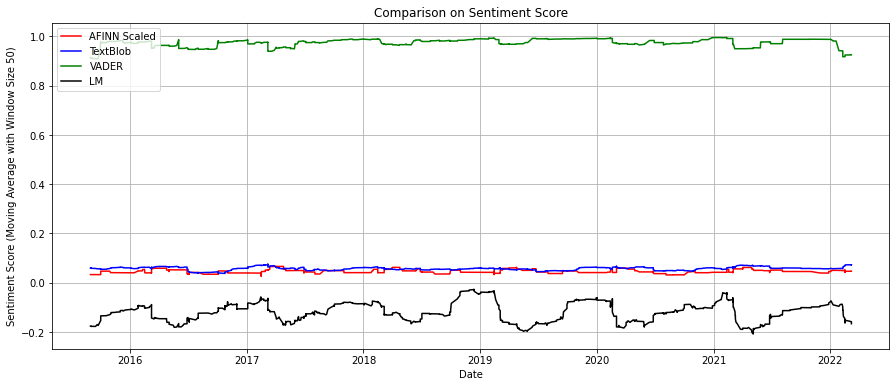

In [39]:
# WARNING - THIS CELL WILL TAKE A LONG TIME TO RUN

# AFINN Sentiment Analysis Scores
afinn = Afinn(emoticons=True)
df["AFINN"]=[afinn.score(s) for s in df.text]

# TextBlob Sentiment Analysis Scores
df["TextBlob"]=[TextBlob(s).sentiment.polarity for s in df.text]

# VADER Sentiment Analysis Scores
analyzer=SentimentIntensityAnalyzer()
df["VADER"]=[analyzer.polarity_scores(s)['compound'] for s in df.text]

# Loughran and McDonald Sentiment Scores
lm = ps.LM()
df['LMTitle'] = 0
for i in range(len(df['text'])):
    tokens = lm.tokenize(df['text'][i])
    score = lm.get_score(tokens)
    df.loc[i,"LMTitle"]=score["Polarity"]

df

# Scale AFINN score to compare it with other sentiment analyzers
df['AFINN_SCALE'] = MinMaxScaler().fit_transform(np.array(df['AFINN']).reshape(-1,1))


# inline display of plots
%matplotlib inline
plt.figure(figsize=(15, 6))

plt.plot(df.filingDate, df.AFINN_SCALE.rolling(window=50).mean(), "-r", label="AFINN Scaled")
plt.plot(df.filingDate, df.TextBlob.rolling(window=50).mean(), "-b", label="TextBlob")
plt.plot(df.filingDate, df.VADER.rolling(window=50).mean(), "-g", label="VADER")
plt.plot(df.filingDate, df.LMTitle.rolling(window=50).mean(), "-k", label="LM")


plt.legend(loc="upper left")
plt.title("Comparison on Sentiment Score")
plt.xlabel("Date")
plt.ylabel("Sentiment Score (Moving Average with Window Size 50)")
plt.grid(axis='both')
plt.show()

In [40]:
df.to_csv("Cat_sentiment_scores.csv")
df_price.to_csv("Cat_stock_prices.csv")
df_cat = pd.merge(df,df_price,how='left',left_on = 'filingDate',right_index = True, copy=True)
df_cat.to_csv("Cat_all_Data.csv")

In [41]:
print(df_all['dayDiff'].isna().sum())
print(df_all['dayDiffCL'].isna().sum())
print(df_all['dayPCT'].isna().sum())
print(df_all['dayPCTCL'].isna().sum())
print(df_all['weekDiff'].isna().sum())
print(df_all['weekDiffCL'].isna().sum())
print(df_all['weekPCT'].isna().sum())
print(df_all['weekPCTCL'].isna().sum())
print(df_all['monthDiff'].isna().sum())
print(df_all['monthDiffCL'].isna().sum())
print(df_all['monthPCT'].isna().sum())
print(df_all['monthPCTCL'].isna().sum())

0
0
0
0
0
0
0
0
0
0
0
0


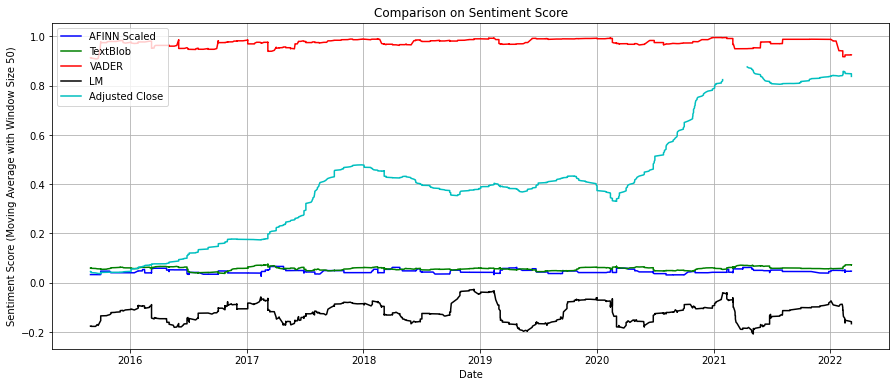

In [42]:
# Graph all stock data with Sentiment Data - First Scale difference data to be graphed and compared with sentiment data.
df_cat['dayDiff_SCALE'] = MinMaxScaler().fit_transform(np.array(df_cat['dayDiff']).reshape(-1,1))
df_cat['weekDiff_SCALE'] = MinMaxScaler().fit_transform(np.array(df_cat['weekDiff']).reshape(-1,1))
df_cat['monthDiff_SCALE'] = MinMaxScaler().fit_transform(np.array(df_cat['monthDiff']).reshape(-1,1))
df_cat['Adj_Close_SCALE'] = MinMaxScaler().fit_transform(np.array(df_cat['Adj Close']).reshape(-1,1))

# Graph Sentiment scores with Adjusted Closing Values
plt.figure(figsize=(15, 6))

plt.plot(df_cat.filingDate, df_cat.AFINN_SCALE.rolling(window=50).mean(), "-b", label="AFINN Scaled")
plt.plot(df_cat.filingDate, df_cat.TextBlob.rolling(window=50).mean(), "-g", label="TextBlob")
plt.plot(df_cat.filingDate, df_cat.VADER.rolling(window=50).mean(), "-r", label="VADER")
plt.plot(df_cat.filingDate, df_cat.LMTitle.rolling(window=50).mean(), "-k", label="LM")
plt.plot(df_cat.filingDate, df_cat.Adj_Close_SCALE.rolling(window=50).mean(), "-c", label="Adjusted Close")


plt.legend(loc="upper left")
plt.title("Comparison on Sentiment Score")
plt.xlabel("Date")
plt.ylabel("Sentiment Score (Moving Average with Window Size 50)")
plt.grid(axis='both')
plt.show()

In [43]:
df_cat['characters'] = [len(s) for s in df_cat['text']]
print(f"Average character length: {df_cat['characters'].mean()}")
print(f"Minimum character length: {df_cat['characters'].min()}")
print(f"Maximum character length: {df_cat['characters'].max()}")

Average character length: 20052.963
Minimum character length: 220
Maximum character length: 726582


In [45]:
df_small = df_cat[df_cat['characters']<500].copy()
print(df_small.shape)
df_small

(2, 43)


,accessionNumber,filingDate,reportDate,acceptanceDateTime,act,form,fileNumber,filmNumber,items,size,...,weekPCTCL,monthDiff,monthDiffCL,monthPCT,monthPCTCL,dayDiff_SCALE,weekDiff_SCALE,monthDiff_SCALE,Adj_Close_SCALE,characters
694,0001377739-17-000023,2017-06-08,,2017-06-08T13:36:30.000Z,34,PX14A6G,001-00768,17899859,,87310,...,0.013064,2.835892,3.229996,0.029841,0.029841,0.522608,0.620136,0.622700,0.229384,390
728,9999999997-17-005343,2017-03-28,2017-01-31,2017-04-06T15:19:24.000Z,34,NO ACT,001-00768,20170221,,1387,...,0.012536,8.846306,9.310005,0.098530,0.091042,0.481135,0.616134,0.694273,0.169629,220


In [46]:
df_cat = df_cat[df_cat['characters']>500].copy()
df_cat.sort_values(by='filingDate',ascending=False,inplace=True)
df_cat.reset_index(inplace=True,drop=True)
print(df_cat.shape)
df_cat

(998, 43)


,accessionNumber,filingDate,reportDate,acceptanceDateTime,act,form,fileNumber,filmNumber,items,size,...,weekPCTCL,monthDiff,monthDiffCL,monthPCT,monthPCTCL,dayDiff_SCALE,weekDiff_SCALE,monthDiff_SCALE,Adj_Close_SCALE,characters
0,0000018230-22-000175,2022-07-28,2022-07-26,2022-07-28T11:12:12.000Z,,4,,,,6413,...,NaN,NaN,NaN,NaN,NaN,0.976934,NaN,NaN,0.736911,4985
1,0000018230-22-000174,2022-07-28,2022-07-26,2022-07-28T11:11:50.000Z,,4,,,,6368,...,NaN,NaN,NaN,NaN,NaN,0.976934,NaN,NaN,0.736911,4974
2,0000018230-22-000169,2022-07-01,2022-06-30,2022-07-01T08:53:25.000Z,,4,,,,5874,...,-0.018684,NaN,NaN,NaN,NaN,0.272181,0.527475,NaN,0.679690,4501
3,0000018230-22-000168,2022-07-01,2022-06-30,2022-07-01T08:53:00.000Z,,4,,,,5772,...,-0.018684,NaN,NaN,NaN,NaN,0.272181,0.527475,NaN,0.679690,4503
4,0000018230-22-000165,2022-06-27,2022-06-24,2022-06-27T20:50:06.000Z,,4,,,,6413,...,-0.079593,1.547531,0.250000,0.008239,0.001331,0.477798,0.309976,0.607357,0.728699,4985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,0000018230-15-000293,2015-09-02,2015-08-31,2015-09-02T16:23:42.000Z,,4,,,,5765,...,-0.050815,-5.675255,-6.919998,-0.100029,-0.100029,0.420872,0.532231,0.521347,0.071328,4557
994,0000018230-15-000291,2015-09-02,2015-08-31,2015-09-02T16:15:34.000Z,,4,,,,5748,...,-0.050815,-5.675255,-6.919998,-0.100029,-0.100029,0.420872,0.532231,0.521347,0.071328,4549
995,0000018230-15-000289,2015-09-02,2015-08-31,2015-09-02T16:09:54.000Z,,4,,,,5753,...,-0.050815,-5.675255,-6.919998,-0.100029,-0.100029,0.420872,0.532231,0.521347,0.071328,4551
996,0000018230-15-000287,2015-09-02,2015-08-31,2015-09-02T16:04:41.000Z,,4,,,,5767,...,-0.050815,-5.675255,-6.919998,-0.100029,-0.100029,0.420872,0.532231,0.521347,0.071328,4555


In [47]:
print(f"Average character length: {df_cat['characters'].mean()}")
print(f"Minimum character length: {df_cat['characters'].min()}")
print(f"Maximum character length: {df_cat['characters'].max()}")

Average character length: 20092.538076152305
Minimum character length: 737
Maximum character length: 726582


In [48]:
# Regraining from best Deere Model on entire dataset to be used on Cat Dataset
df = df_all[["text","Adj Close"]].copy()


lm = ps.LM()
vectorizer = CountVectorizer(tokenizer = lm.tokenize,
                                             stop_words=custom_stop_words,
                                             ngram_range =(2,2),
                                             binary=True)
#Create the training DTM and the labels
train_x = vectorizer.fit_transform(df["text"])
train_y = df["Adj Close"]
print(train_x.shape)


scaler = MaxAbsScaler()
scaler.fit(train_x)
train_x=scaler.transform(train_x)

lasso = Lasso(alpha=0.046416, #Regularization parameter.
              max_iter=75000
              )
lasso.fit(train_x,train_y)
print(np.count_nonzero(lasso.coef_))
#Check the percentage of non-zero slopes
print(np.count_nonzero(lasso.coef_)/len(lasso.coef_))


(974, 83458)
372
0.004457331831579956


In [49]:
df = df_cat[['text','Adj Close']]
df = df[df['Adj Close'].isna()==False]
test_x = vectorizer.transform(df['text'])
test_y = df['Adj Close']
print(test_x.shape)
print(test_y.shape)
test_x = scaler.transform(test_x)
print("Mean Squared Error:")
print("Deere:")
print(mean_squared_error(train_y,lasso.predict(train_x),squared=False))
print()
print("Caterpillar:")
print(mean_squared_error(test_y,lasso.predict(test_x),squared=False))
print()
print("R-Squared:")
print("Deere:")
print(r2_score(train_y,lasso.predict(train_x)))
print()
print("Caterpillar:")
print(r2_score(test_y,lasso.predict(test_x)))

(995, 83458)
(995,)
Mean Squared Error:
Deere:
33.527767753541205

Caterpillar:
68.19791642280431

R-Squared:
Deere:
0.859017351609048

Caterpillar:
-0.9381068012582343


In [50]:
df_d = df_all[["text","dayDiff"]].copy()
df_d['dayDiff'] = np.where(df_d.dayDiff > 0 ,'postive','negative')
lm = ps.LM()
vectorizer = CountVectorizer(tokenizer = lm.tokenize,
                             stop_words=custom_stop_words,
                             ngram_range =(2,2),
                             binary=True)
#Create the training DTM and the labels
train_x = vectorizer.fit_transform(df_d["text"])
train_y = df_d["dayDiff"]
print(train_x.shape)

df_c = df_cat[["text",'dayDiff']].copy()
df_c['dayDiff'] = np.where(df_c.dayDiff > 0 ,'postive','negative')
#Create the testing DTM and the labels
test_x = vectorizer.transform(df_c["text"])
test_y = df_c["dayDiff"]
print(test_x.shape)

sparselr = LogisticRegression(penalty='l1', 
                              solver='liblinear',
                              random_state=2021,
                              tol=0.0001,
                              max_iter=1000, 
                              C=2.8635392937149065)
sparselr.fit(train_x,train_y)


# Accuracy
print("Day Difference")
print("Accuracy:")
print("Deere:")
print(accuracy_score(train_y,sparselr.predict(train_x)))
print("Caterpillar:")
print(accuracy_score(test_y,sparselr.predict(test_x)))

# AUC Score
print("AUC:")
print("Deere:")
print(roc_auc_score(train_y,sparselr.predict_proba(train_x)[:, 1]))
print("Caterpillar:")
print(roc_auc_score(test_y,sparselr.predict_proba(test_x)[:, 1]))

(974, 83458)
(998, 83458)
Day Difference
Accuracy:
Deere:
0.8418891170431212
Caterpillar:
0.49298597194388777
AUC:
Deere:
0.9266496179020595
Caterpillar:
0.5462383327969101


In [51]:
df_d = df_all[["text","weekDiff"]].copy()
df_d['weekDiff'] = np.where(df_d.weekDiff > 0 ,'postive','negative')
lm = ps.LM()
vectorizer = CountVectorizer(tokenizer = lm.tokenize,
                             stop_words=custom_stop_words,
                             ngram_range =(2,2),
                             binary=True)
#Create the training DTM and the labels
train_x = vectorizer.fit_transform(df_d["text"])
train_y = df_d["weekDiff"]
print(train_x.shape)

df_c = df_cat[["text",'weekDiff']].copy()
df_c['weekDiff'] = np.where(df_c.weekDiff > 0 ,'postive','negative')
#Create the testing DTM and the labels
test_x = vectorizer.transform(df_c["text"])
test_y = df_c["weekDiff"]
print(test_x.shape)


sparselr = LogisticRegression(penalty='l1', 
                              solver='liblinear',
                              random_state=2021,
                              tol=0.0001,
                              max_iter=1000, 
                              C=0.6374269228121427)
sparselr.fit(train_x,train_y)


# Accuracy
print("Week Difference")
print("Accuracy:")
print("Deere:")
print(accuracy_score(train_y,sparselr.predict(train_x)))
print("Caterpillar:")
print(accuracy_score(test_y,sparselr.predict(test_x)))

# AUC Score
print("AUC:")
print("Deere:")
print(roc_auc_score(train_y,sparselr.predict_proba(train_x)[:, 1]))
print("Caterpillar:")
print(roc_auc_score(test_y,sparselr.predict_proba(test_x)[:, 1]))

(974, 83458)
(998, 83458)
Week Difference
Accuracy:
Deere:
0.7505133470225873
Caterpillar:
0.5240480961923848
AUC:
Deere:
0.8460922254866438
Caterpillar:
0.4751926260499909


In [52]:
df_d = df_all[["text","monthDiff"]].copy()
df_d['monthDiff'] = np.where(df_d.monthDiff > 0 ,'postive','negative')
lm = ps.LM()
vectorizer = CountVectorizer(tokenizer = lm.tokenize,
                             stop_words=custom_stop_words,
                             ngram_range =(2,2),
                             binary=True)
#Create the training DTM and the labels
train_x = vectorizer.fit_transform(df_d["text"])
train_y = df_d["monthDiff"]
print(train_x.shape)

df_c = df_cat[["text",'monthDiff']].copy()
df_c['monthDiff'] = np.where(df_c.monthDiff > 0 ,'postive','negative')
#Create the testing DTM and the labels
test_x = vectorizer.transform(df_c["text"])
test_y = df_c["monthDiff"]
print(test_x.shape)


sparselr = LogisticRegression(penalty='l1', 
                              solver='liblinear',
                              random_state=2021,
                              tol=0.0001,
                              max_iter=1000, 
                              C=0.763948127667649)
sparselr.fit(train_x,train_y)


# Accuracy
print("Month Difference")
print("Accuracy:")
print("Deere:")
print(accuracy_score(train_y,sparselr.predict(train_x)))
print("Caterpillar:")
print(accuracy_score(test_y,sparselr.predict(test_x)))

# AUC Score
print("AUC:")
print("Deere:")
print(roc_auc_score(train_y,sparselr.predict_proba(train_x)[:, 1]))
print("Caterpillar:")
print(roc_auc_score(test_y,sparselr.predict_proba(test_x)[:, 1]))

(974, 83458)
(998, 83458)
Month Difference
Accuracy:
Deere:
0.7813141683778234
Caterpillar:
0.6032064128256514
AUC:
Deere:
0.8489125457875457
Caterpillar:
0.4600544612073698


### Pull in Amazon Data and Apply Lasso and Logistic Regression Models
    - Testing if models developed for Deere and Company can be applied to other companies outside of Industry

In [53]:
# Request Data from Edgar Search. Pulled by Company CIK number
data = requests.get('https://data.sec.gov/submissions/CIK0001018724.json',headers={'User-Agent':'University of Iowa abromeland@uiowa.edu'})
data = json.loads(data.content)['filings']['recent']
df = pd.DataFrame.from_dict(data)
df.sort_values(by='filingDate',ascending=False,inplace=True)
df.reset_index(inplace=True,drop=True)
df.head()

,accessionNumber,filingDate,reportDate,acceptanceDateTime,act,form,fileNumber,filmNumber,items,size,isXBRL,isInlineXBRL,primaryDocument,primaryDocDescription
0,0001018724-22-000019,2022-07-29,2022-06-30,2022-07-28T18:24:06.000Z,34,10-Q,000-22513,221116660,,8956127,1,1,amzn-20220630.htm,10-Q
1,0001018724-22-000017,2022-07-28,2022-07-28,2022-07-28T16:09:30.000Z,34,8-K,000-22513,221115304,"2.02,9.01",1137143,1,1,amzn-20220728.htm,8-K
2,0000899243-22-024995,2022-07-05,2022-07-01,2022-07-05T16:44:12.000Z,,3,,,,9423,0,0,xslF345X02/doc3.xml,FORM 3 SUBMISSION
3,0001018724-22-000015,2022-06-03,2022-06-01,2022-06-03T12:10:24.000Z,34,8-K,000-22513,22993489,5.02,171038,1,1,amzn-20220601.htm,8-K
4,0001104659-22-066529,2022-05-31,,2022-05-31T16:04:15.000Z,34,SD,000-22513,22983166,,309293,0,0,tm2215904d2_sd.htm,FORM SD


In [54]:
# Pull data by accessionNumber and FileName to be added to the dataframe
for i in range(len(df)):
    accessionNumber = df.loc[i,"accessionNumber"]
    filename = df.loc[i,'primaryDocument']
    URL = f'https://www.sec.gov/Archives/edgar/data/1018724/{re.sub("-","",accessionNumber)}/{filename}'
    page = requests.get(URL,headers={'User-Agent':'University of Iowa abromeland@uiowa.edu'})
    if df.loc[i,'form'] == 'UPLOAD':
        with open('/tmp/metadata.pdf','wb') as fd:
            fd.write(page.content)
        fd.close()

        pdfFileObj = open('/tmp/metadata.pdf', 'rb') 
        pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
        text = [pdfReader.getPage(i).extractText() for i in range(pdfReader.numPages)]
        df.loc[i,'text'] = ' '.join(text)
        pdfFileObj.close()
    else:
        root = html.fromstring(page.content)
        text = [s.text_content() for s in root.xpath('/html/body')]
        df.loc[i,'text'] = ' '.join(text)
        
    time.sleep(.25)
df

,accessionNumber,filingDate,reportDate,acceptanceDateTime,act,form,fileNumber,filmNumber,items,size,isXBRL,isInlineXBRL,primaryDocument,primaryDocDescription,text
0,0001018724-22-000019,2022-07-29,2022-06-30,2022-07-28T18:24:06.000Z,34,10-Q,000-22513,221116660,,8956127,1,1,amzn-20220630.htm,10-Q,false2022Q2000101872412/31P4YP5Yhttp://fasb.or...
1,0001018724-22-000017,2022-07-28,2022-07-28,2022-07-28T16:09:30.000Z,34,8-K,000-22513,221115304,"2.02,9.01",1137143,1,1,amzn-20220728.htm,8-K,0001018724false00010187242022-07-282022-07-28T...
2,0000899243-22-024995,2022-07-05,2022-07-01,2022-07-05T16:44:12.000Z,,3,,,,9423,0,0,xslF345X02/doc3.xml,FORM 3 SUBMISSION,SEC Form 3 \n \nFORM 3\n\nUNITED STATES SECU...
3,0001018724-22-000015,2022-06-03,2022-06-01,2022-06-03T12:10:24.000Z,34,8-K,000-22513,22993489,5.02,171038,1,1,amzn-20220601.htm,8-K,0001018724false00010187242022-06-012022-06-01T...
4,0001104659-22-066529,2022-05-31,,2022-05-31T16:04:15.000Z,34,SD,000-22513,22983166,,309293,0,0,tm2215904d2_sd.htm,FORM SD,\nSD\n1\ntm2215904d2_sd.htm\nFORM SD\n\n\n\n ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,0001359804-13-000059,2013-11-05,2013-11-01,2013-11-05T18:48:40.000Z,,4,,,,42614,0,0,xslF345X03/edgar.xml,PRIMARY DOCUMENT,SEC Form 4 \n \n\nFORM 4\n\nUNITED STATES SE...
998,0001359804-13-000058,2013-11-05,2013-11-01,2013-11-05T18:43:56.000Z,,4,,,,4950,0,0,xslF345X03/edgar.xml,PRIMARY DOCUMENT,SEC Form 4 \n \n\nFORM 4\n\nUNITED STATES SE...
999,0001359804-13-000057,2013-11-04,2013-11-01,2013-11-04T20:29:33.000Z,,4,,,,6016,0,0,xslF345X03/edgar.xml,PRIMARY DOCUMENT,SEC Form 4 \n \n\nFORM 4\n\nUNITED STATES SE...
1000,0001359804-13-000056,2013-11-04,2013-11-01,2013-11-04T20:25:01.000Z,,4,,,,16489,0,0,xslF345X03/edgar.xml,PRIMARY DOCUMENT,SEC Form 4 \n \n\nFORM 4\n\nUNITED STATES SE...


In [55]:
# Clean Data and print out example data
df['text'] = df['text'].str.replace("[\\u200b||\\n||\\xa0]",'',regex=True)
df['text'] = df['text'].str.replace("\$\d+[\d,\.]*",'moneyToken',regex=True)
df['text'] = df['text'].str.lower()
print(df.filingDate.isnull().sum())
print(df.filingDate.dtype)
df["filingDate"] = pd.to_datetime(df["filingDate"],format="%Y-%m-%d %H:%M:%S")
print(df.filingDate.dtype)

0
object
datetime64[ns]


In [56]:
df.sort_values(by='filingDate',ascending=False,inplace=True)
df

,accessionNumber,filingDate,reportDate,acceptanceDateTime,act,form,fileNumber,filmNumber,items,size,isXBRL,isInlineXBRL,primaryDocument,primaryDocDescription,text
0,0001018724-22-000019,2022-07-29,2022-06-30,2022-07-28T18:24:06.000Z,34,10-Q,000-22513,221116660,,8956127,1,1,amzn-20220630.htm,10-Q,false2022q2000101872412/31p4yp5yhttp://fasb.or...
1,0001018724-22-000017,2022-07-28,2022-07-28,2022-07-28T16:09:30.000Z,34,8-K,000-22513,221115304,"2.02,9.01",1137143,1,1,amzn-20220728.htm,8-K,0001018724false00010187242022-07-282022-07-28t...
2,0000899243-22-024995,2022-07-05,2022-07-01,2022-07-05T16:44:12.000Z,,3,,,,9423,0,0,xslF345X02/doc3.xml,FORM 3 SUBMISSION,sec form 3 form 3united states securities a...
3,0001018724-22-000015,2022-06-03,2022-06-01,2022-06-03T12:10:24.000Z,34,8-K,000-22513,22993489,5.02,171038,1,1,amzn-20220601.htm,8-K,0001018724false00010187242022-06-012022-06-01t...
4,0001104659-22-066529,2022-05-31,,2022-05-31T16:04:15.000Z,34,SD,000-22513,22983166,,309293,0,0,tm2215904d2_sd.htm,FORM SD,sd1tm2215904d2_sd.htmform sd united states...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,0001359804-13-000059,2013-11-05,2013-11-01,2013-11-05T18:48:40.000Z,,4,,,,42614,0,0,xslF345X03/edgar.xml,PRIMARY DOCUMENT,sec form 4 form 4united states securities a...
998,0001359804-13-000058,2013-11-05,2013-11-01,2013-11-05T18:43:56.000Z,,4,,,,4950,0,0,xslF345X03/edgar.xml,PRIMARY DOCUMENT,sec form 4 form 4united states securities a...
999,0001359804-13-000057,2013-11-04,2013-11-01,2013-11-04T20:29:33.000Z,,4,,,,6016,0,0,xslF345X03/edgar.xml,PRIMARY DOCUMENT,sec form 4 form 4united states securities a...
1000,0001359804-13-000056,2013-11-04,2013-11-01,2013-11-04T20:25:01.000Z,,4,,,,16489,0,0,xslF345X03/edgar.xml,PRIMARY DOCUMENT,sec form 4 form 4united states securities a...


In [57]:
df_price = yf.download("AMZN",start='2013-10-01',end='2022-07-28',progress=False)
print(type(df_price.index))
df_price.sort_index(ascending=False,inplace=True)
df_price['dayDiff'] = -1*df_price['Adj Close'].diff()
df_price['dayDiffCL'] = -1*df_price['Close'].diff()
df_price['dayPCT'] = -1*df_price['Adj Close'].pct_change()
df_price['dayPCTCL'] = -1*df_price['Close'].pct_change()
df_price['weekDiff'] = -1*df_price['Adj Close'].diff(periods=5)
df_price['weekDiffCL'] = -1*df_price['Close'].diff(periods=5)
df_price['weekPCT'] = -1*df_price['Adj Close'].pct_change(periods=5)
df_price['weekPCTCL'] = -1*df_price['Close'].pct_change(periods=5)
df_price['monthDiff'] = -1*df_price['Adj Close'].diff(periods=22)
df_price['monthDiffCL'] = -1*df_price['Close'].diff(periods=22)
df_price['monthPCT'] = -1*df_price['Adj Close'].pct_change(periods=22)
df_price['monthPCTCL'] = -1*df_price['Close'].pct_change(periods=22)
df_price

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


,Open,High,Low,Close,Adj Close,Volume,dayDiff,dayDiffCL,dayPCT,dayPCTCL,weekDiff,weekDiffCL,weekPCT,weekPCTCL,monthDiff,monthDiffCL,monthPCT,monthPCTCL
Date,,,,,,,,,,,,,,,,,,
2022-07-27,117.309998,121.900002,117.160004,120.970001,120.970001,61582000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-26,115.790001,118.150002,114.529999,114.809998,114.809998,67075100,6.160004,6.160004,0.050922,0.050922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-25,122.699997,123.639999,120.029999,121.139999,121.139999,50221300,-6.330002,-6.330002,-0.055135,-0.055135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-22,125.010002,125.500000,121.349998,122.419998,122.419998,51402700,-1.279999,-1.279999,-0.010566,-0.010566,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-21,123.199997,124.849998,121.260002,124.629997,124.629997,60239900,-2.209999,-2.209999,-0.018053,-0.018053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-10-07,15.762000,15.767000,15.487000,15.501500,15.501500,41664000,-0.340000,-0.340000,-0.022425,-0.022425,0.033500,0.033500,0.002156,0.002156,2.307500,2.307500,0.129569,0.129569
2013-10-04,15.756500,15.960000,15.631000,15.952000,15.952000,36300000,-0.450500,-0.450500,-0.029062,-0.029062,-0.407499,-0.407499,-0.026215,-0.026215,1.992500,1.992500,0.111037,0.111037
2013-10-03,16.019501,16.146000,15.651000,15.738000,15.738000,53496000,0.214000,0.214000,0.013415,0.013415,-0.479500,-0.479500,-0.031425,-0.031425,2.199000,2.199000,0.122596,0.122596


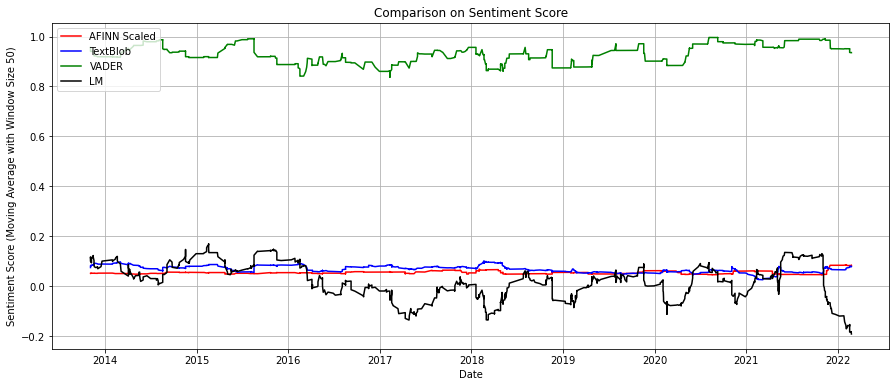

In [58]:
# WARNING - THIS CELL WILL TAKE A LONG TIME TO RUN

# AFINN Sentiment Analysis Scores
afinn = Afinn(emoticons=True)
df["AFINN"]=[afinn.score(s) for s in df.text]

# TextBlob Sentiment Analysis Scores
df["TextBlob"]=[TextBlob(s).sentiment.polarity for s in df.text]

# VADER Sentiment Analysis Scores
analyzer=SentimentIntensityAnalyzer()
df["VADER"]=[analyzer.polarity_scores(s)['compound'] for s in df.text]

# Loughran and McDonald Sentiment Scores
lm = ps.LM()
df['LMTitle'] = 0
for i in range(len(df['text'])):
    tokens = lm.tokenize(df['text'][i])
    score = lm.get_score(tokens)
    df.loc[i,"LMTitle"]=score["Polarity"]

df

# Scale AFINN score to compare it with other sentiment analyzers
df['AFINN_SCALE'] = MinMaxScaler().fit_transform(np.array(df['AFINN']).reshape(-1,1))


# inline display of plots
%matplotlib inline
plt.figure(figsize=(15, 6))

plt.plot(df.filingDate, df.AFINN_SCALE.rolling(window=50).mean(), "-r", label="AFINN Scaled")
plt.plot(df.filingDate, df.TextBlob.rolling(window=50).mean(), "-b", label="TextBlob")
plt.plot(df.filingDate, df.VADER.rolling(window=50).mean(), "-g", label="VADER")
plt.plot(df.filingDate, df.LMTitle.rolling(window=50).mean(), "-k", label="LM")


plt.legend(loc="upper left")
plt.title("Comparison on Sentiment Score")
plt.xlabel("Date")
plt.ylabel("Sentiment Score (Moving Average with Window Size 50)")
plt.grid(axis='both')
plt.show()

In [59]:
df_cat = pd.merge(df,df_price,how='left',left_on = 'filingDate',right_index = True, copy=True)
df_cat.to_csv("Amazon_all_Data.csv")

In [60]:
print(df_all['dayDiff'].isna().sum())
print(df_all['dayDiffCL'].isna().sum())
print(df_all['dayPCT'].isna().sum())
print(df_all['dayPCTCL'].isna().sum())
print(df_all['weekDiff'].isna().sum())
print(df_all['weekDiffCL'].isna().sum())
print(df_all['weekPCT'].isna().sum())
print(df_all['weekPCTCL'].isna().sum())
print(df_all['monthDiff'].isna().sum())
print(df_all['monthDiffCL'].isna().sum())
print(df_all['monthPCT'].isna().sum())
print(df_all['monthPCTCL'].isna().sum())

0
0
0
0
0
0
0
0
0
0
0
0


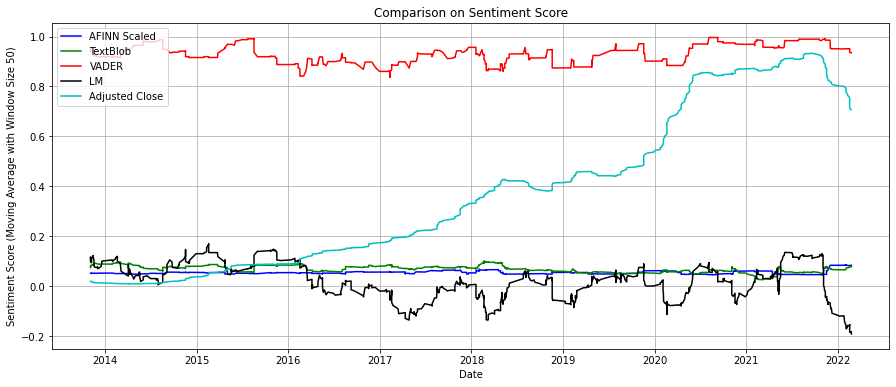

In [61]:
# Graph all stock data with Sentiment Data - First Scale difference data to be graphed and compared with sentiment data.
df_cat['dayDiff_SCALE'] = MinMaxScaler().fit_transform(np.array(df_cat['dayDiff']).reshape(-1,1))
df_cat['weekDiff_SCALE'] = MinMaxScaler().fit_transform(np.array(df_cat['weekDiff']).reshape(-1,1))
df_cat['monthDiff_SCALE'] = MinMaxScaler().fit_transform(np.array(df_cat['monthDiff']).reshape(-1,1))
df_cat['Adj_Close_SCALE'] = MinMaxScaler().fit_transform(np.array(df_cat['Adj Close']).reshape(-1,1))

# Graph Sentiment scores with Adjusted Closing Values
plt.figure(figsize=(15, 6))

plt.plot(df_cat.filingDate, df_cat.AFINN_SCALE.rolling(window=50).mean(), "-b", label="AFINN Scaled")
plt.plot(df_cat.filingDate, df_cat.TextBlob.rolling(window=50).mean(), "-g", label="TextBlob")
plt.plot(df_cat.filingDate, df_cat.VADER.rolling(window=50).mean(), "-r", label="VADER")
plt.plot(df_cat.filingDate, df_cat.LMTitle.rolling(window=50).mean(), "-k", label="LM")
plt.plot(df_cat.filingDate, df_cat.Adj_Close_SCALE.rolling(window=50).mean(), "-c", label="Adjusted Close")


plt.legend(loc="upper left")
plt.title("Comparison on Sentiment Score")
plt.xlabel("Date")
plt.ylabel("Sentiment Score (Moving Average with Window Size 50)")
plt.grid(axis='both')
plt.show()

In [62]:
df_cat['characters'] = [len(s) for s in df_cat['text']]
print(f"Average character length: {df_cat['characters'].mean()}")
print(f"Minimum character length: {df_cat['characters'].min()}")
print(f"Maximum character length: {df_cat['characters'].max()}")

Average character length: 17226.327345309383
Minimum character length: 207
Maximum character length: 612524


In [63]:
df_small = df_cat[df_cat['characters']<1000].copy()
print(df_small.shape)
df_small

(42, 43)


,accessionNumber,filingDate,reportDate,acceptanceDateTime,act,form,fileNumber,filmNumber,items,size,...,weekPCTCL,monthDiff,monthDiffCL,monthPCT,monthPCTCL,dayDiff_SCALE,weekDiff_SCALE,monthDiff_SCALE,Adj_Close_SCALE,characters
49,0000000000-22-002109,2022-02-24,,2022-02-24T12:30:08.000Z,,UPLOAD,,,,39541,...,-0.023391,17.632492,17.632492,0.104340,0.104340,0.581592,0.511505,0.854869,0.795535,590
290,0001018724-20-000024,2020-07-31,,2020-07-30T21:17:07.000Z,34,IRANNOTICE,000-22513,201063356,,124721,...,0.000878,16.722000,16.722000,0.095578,0.095578,0.451955,0.585935,0.843175,0.835461,854
318,0001018724-20-000012,2020-05-01,,2020-04-30T19:44:53.000Z,34,IRANNOTICE,000-22513,20837831,,124962,...,0.039322,9.617996,9.617996,0.077615,0.077615,0.557736,0.679828,0.751931,0.580365,867
352,0001018724-20-000006,2020-01-31,,2020-01-30T20:59:38.000Z,34,IRANNOTICE,000-22513,20562983,,124963,...,0.033935,-1.644501,-1.644501,-0.016646,-0.016646,0.513667,0.656032,0.607276,0.499850,868
378,0001018724-19-000091,2019-10-25,,2019-10-24T21:04:53.000Z,34,IRANNOTICE,000-22513,191167317,,124959,...,0.016808,1.780502,1.780502,0.019817,0.019817,0.539582,0.614199,0.651267,0.428026,874
404,0001018724-19-000073,2019-07-26,,2019-07-25T19:57:24.000Z,34,IRANNOTICE,000-22513,19975702,,124948,...,-0.065713,-9.060997,-9.060997,-0.102859,-0.102859,0.480324,0.459155,0.512019,0.480784,864
426,0001018724-19-000045,2019-04-26,,2019-04-25T19:21:50.000Z,34,IRANNOTICE,000-22513,19768880,,124952,...,0.006028,-6.571999,-6.571999,-0.072252,-0.072252,0.503848,0.595295,0.543987,0.482985,868
459,9999999995-19-000071,2019-02-04,,2019-02-05T00:15:22.000Z,33,EFFECT,333-224475,19566098,"POS AM,0001193125-19-006137,2019-02-04",1669,...,-0.026593,-0.367996,-0.367996,-0.004527,-0.004527,0.552047,0.539304,0.623671,0.390857,257
460,9999999995-19-000070,2019-02-04,,2019-02-05T00:15:21.000Z,33,EFFECT,333-221675,19566094,"POS AM,0001193125-19-006128,2019-02-04",1669,...,-0.026593,-0.367996,-0.367996,-0.004527,-0.004527,0.552047,0.539304,0.623671,0.390857,257
466,0001018724-19-000006,2019-02-01,,2019-01-31T20:45:24.000Z,34,IRANNOTICE,000-22513,19557479,,124954,...,-0.023932,2.136002,2.136002,0.025597,0.025597,0.528497,0.543751,0.655833,0.388802,870


In [64]:
df_cat = df_cat[df_cat['characters']>500].copy()
df_cat.sort_values(by='filingDate',ascending=False,inplace=True)
df_cat.reset_index(inplace=True,drop=True)
print(df_cat.shape)
df_cat

(985, 43)


,accessionNumber,filingDate,reportDate,acceptanceDateTime,act,form,fileNumber,filmNumber,items,size,...,weekPCTCL,monthDiff,monthDiffCL,monthPCT,monthPCTCL,dayDiff_SCALE,weekDiff_SCALE,monthDiff_SCALE,Adj_Close_SCALE,characters
0,0001018724-22-000019,2022-07-29,2022-06-30,2022-07-28T18:24:06.000Z,34,10-Q,000-22513,221116660,,8956127,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,184655
1,0001018724-22-000017,2022-07-28,2022-07-28,2022-07-28T16:09:30.000Z,34,8-K,000-22513,221115304,"2.02,9.01",1137143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3456
2,0000899243-22-024995,2022-07-05,2022-07-01,2022-07-05T16:44:12.000Z,,3,,,,9423,...,-0.039187,NaN,NaN,NaN,NaN,0.540668,0.494534,NaN,0.575708,2991
3,0001018724-22-000015,2022-06-03,2022-06-01,2022-06-03T12:10:24.000Z,34,8-K,000-22513,22993489,5.02,171038,...,-0.115823,-6.019997,-6.019997,-0.051749,-0.051749,0.581836,0.320379,0.551077,0.627097,2925
4,0001104659-22-066529,2022-05-31,,2022-05-31T16:04:15.000Z,34,SD,000-22513,22983166,,309293,...,0.022687,-10.649506,-10.649506,-0.097202,-0.097202,0.557148,0.640778,0.491616,0.614668,1879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
980,0001359804-13-000059,2013-11-05,2013-11-01,2013-11-05T18:48:40.000Z,,4,,,,42614,...,-0.026779,1.403000,1.403000,0.072516,0.072516,0.515981,0.573380,0.646418,0.020854,9531
981,0001359804-13-000058,2013-11-05,2013-11-01,2013-11-05T18:43:56.000Z,,4,,,,4950,...,-0.026779,1.403000,1.403000,0.072516,0.072516,0.515981,0.573380,0.646418,0.020854,4160
982,0001359804-13-000057,2013-11-04,2013-11-01,2013-11-04T20:29:33.000Z,,4,,,,6016,...,-0.012303,1.287500,1.287500,0.066972,0.066972,0.519637,0.578551,0.644935,0.020811,3926
983,0001359804-13-000056,2013-11-04,2013-11-01,2013-11-04T20:25:01.000Z,,4,,,,16489,...,-0.012303,1.287500,1.287500,0.066972,0.066972,0.519637,0.578551,0.644935,0.020811,5781


In [65]:
print(f"Average character length: {df_cat['characters'].mean()}")
print(f"Minimum character length: {df_cat['characters'].min()}")
print(f"Maximum character length: {df_cat['characters'].max()}")

Average character length: 17519.62842639594
Minimum character length: 590
Maximum character length: 612524


In [66]:
# Regraining from best Deere Model on entire dataset to be used on Cat Dataset
df = df_all[["text","Adj Close"]].copy()


lm = ps.LM()
vectorizer = CountVectorizer(tokenizer = lm.tokenize,
                                             stop_words=custom_stop_words,
                                             ngram_range =(2,2),
                                             binary=True)
#Create the training DTM and the labels
train_x = vectorizer.fit_transform(df["text"])
train_y = df["Adj Close"]
print(train_x.shape)


scaler = MaxAbsScaler()
scaler.fit(train_x)
train_x=scaler.transform(train_x)

lasso = Lasso(alpha=0.046416, #Regularization parameter.
              max_iter=75000
              )
lasso.fit(train_x,train_y)
print(np.count_nonzero(lasso.coef_))
#Check the percentage of non-zero slopes
print(np.count_nonzero(lasso.coef_)/len(lasso.coef_))

(974, 83458)
372
0.004457331831579956


In [67]:
df = df_cat[['text','Adj Close']]
df = df[df['Adj Close'].isna()==False]
test_x = vectorizer.transform(df['text'])
test_y = df['Adj Close']
print(test_x.shape)
print(test_y.shape)
test_x = scaler.transform(test_x)
print("Mean Squared Error:")
print("Deere:")
print(mean_squared_error(train_y,lasso.predict(train_x),squared=False))
print()
print("Amazon:")
print(mean_squared_error(test_y,lasso.predict(test_x),squared=False))
print()
print("R-Squared:")
print("Deere:")
print(r2_score(train_y,lasso.predict(train_x)))
print()
print("Amazon:")
print(r2_score(test_y,lasso.predict(test_x)))

(983, 83458)
(983,)
Mean Squared Error:
Deere:
33.527767753541205

Amazon:
82.60344980404508

R-Squared:
Deere:
0.859017351609048

Amazon:
-1.2541080238270386


In [68]:
df_d = df_all[["text","dayDiff"]].copy()
df_d['dayDiff'] = np.where(df_d.dayDiff > 0 ,'postive','negative')
lm = ps.LM()
vectorizer = CountVectorizer(tokenizer = lm.tokenize,
                             stop_words=custom_stop_words,
                             ngram_range =(2,2),
                             binary=True)
#Create the training DTM and the labels
train_x = vectorizer.fit_transform(df_d["text"])
train_y = df_d["dayDiff"]
print(train_x.shape)

df_c = df_cat[["text",'dayDiff']].copy()
df_c['dayDiff'] = np.where(df_c.dayDiff > 0 ,'postive','negative')
#Create the testing DTM and the labels
test_x = vectorizer.transform(df_c["text"])
test_y = df_c["dayDiff"]
print(test_x.shape)

sparselr = LogisticRegression(penalty='l1', 
                              solver='liblinear',
                              random_state=2021,
                              tol=0.0001,
                              max_iter=1000, 
                              C=2.8635392937149065)
sparselr.fit(train_x,train_y)


# Accuracy
print("Day Difference")
print("Accuracy:")
print("Deere:")
print(accuracy_score(train_y,sparselr.predict(train_x)))
print("Amazon:")
print(accuracy_score(test_y,sparselr.predict(test_x)))

# AUC Score
print("AUC:")
print("Deere:")
print(roc_auc_score(train_y,sparselr.predict_proba(train_x)[:, 1]))
print("Amazon:")
print(roc_auc_score(test_y,sparselr.predict_proba(test_x)[:, 1]))

(974, 83458)
(985, 83458)
Day Difference
Accuracy:
Deere:
0.8418891170431212
Amazon:
0.5218274111675127
AUC:
Deere:
0.9266496179020595
Amazon:
0.507390159115493


In [69]:
df_d = df_all[["text","weekDiff"]].copy()
df_d['weekDiff'] = np.where(df_d.weekDiff > 0 ,'postive','negative')
lm = ps.LM()
vectorizer = CountVectorizer(tokenizer = lm.tokenize,
                             stop_words=custom_stop_words,
                             ngram_range =(2,2),
                             binary=True)
#Create the training DTM and the labels
train_x = vectorizer.fit_transform(df_d["text"])
train_y = df_d["weekDiff"]
print(train_x.shape)

df_c = df_cat[["text",'weekDiff']].copy()
df_c['weekDiff'] = np.where(df_c.weekDiff > 0 ,'postive','negative')
#Create the testing DTM and the labels
test_x = vectorizer.transform(df_c["text"])
test_y = df_c["weekDiff"]
print(test_x.shape)


sparselr = LogisticRegression(penalty='l1', 
                              solver='liblinear',
                              random_state=2021,
                              tol=0.0001,
                              max_iter=1000, 
                              C=0.6374269228121427)
sparselr.fit(train_x,train_y)


# Accuracy
print("Week Difference")
print("Accuracy:")
print("Deere:")
print(accuracy_score(train_y,sparselr.predict(train_x)))
print("Caterpillar:")
print(accuracy_score(test_y,sparselr.predict(test_x)))

# AUC Score
print("AUC:")
print("Deere:")
print(roc_auc_score(train_y,sparselr.predict_proba(train_x)[:, 1]))
print("Caterpillar:")
print(roc_auc_score(test_y,sparselr.predict_proba(test_x)[:, 1]))

(974, 83458)
(985, 83458)
Week Difference
Accuracy:
Deere:
0.7505133470225873
Caterpillar:
0.5756345177664974
AUC:
Deere:
0.8460922254866438
Caterpillar:
0.4495567283693843


In [70]:
df_d = df_all[["text","monthDiff"]].copy()
df_d['monthDiff'] = np.where(df_d.monthDiff > 0 ,'postive','negative')
lm = ps.LM()
vectorizer = CountVectorizer(tokenizer = lm.tokenize,
                             stop_words=custom_stop_words,
                             ngram_range =(2,2),
                             binary=True)
#Create the training DTM and the labels
train_x = vectorizer.fit_transform(df_d["text"])
train_y = df_d["monthDiff"]
print(train_x.shape)

df_c = df_cat[["text",'monthDiff']].copy()
df_c['monthDiff'] = np.where(df_c.monthDiff > 0 ,'postive','negative')
#Create the testing DTM and the labels
test_x = vectorizer.transform(df_c["text"])
test_y = df_c["monthDiff"]
print(test_x.shape)


sparselr = LogisticRegression(penalty='l1', 
                              solver='liblinear',
                              random_state=2021,
                              tol=0.0001,
                              max_iter=1000, 
                              C=0.763948127667649)
sparselr.fit(train_x,train_y)


# Accuracy
print("Month Difference")
print("Accuracy:")
print("Deere:")
print(accuracy_score(train_y,sparselr.predict(train_x)))
print("Caterpillar:")
print(accuracy_score(test_y,sparselr.predict(test_x)))

# AUC Score
print("AUC:")
print("Deere:")
print(roc_auc_score(train_y,sparselr.predict_proba(train_x)[:, 1]))
print("Caterpillar:")
print(roc_auc_score(test_y,sparselr.predict_proba(test_x)[:, 1]))

(974, 83458)
(985, 83458)
Month Difference
Accuracy:
Deere:
0.7813141683778234
Caterpillar:
0.6071065989847716
AUC:
Deere:
0.8489125457875457
Caterpillar:
0.4936218296741616
